# This notebook aims to provide statistical functions, build dataFrame, and perform statistical analyses. The conditions/groups are push/pull+ healthy/lf-patients/hf-patients/sham-patients + before/after-TMS The hypotheses tested are:
- difference between healthy subjects and patients (includng lf/hf/sham-TMS) in push/pull epochs()
- the regression between CMMN properties (including components-SPMIs and graph properties) and FMA
- clustering analyses on CMMN properties (UE-brunnstrom clusters)
- ANOVA and MANOVA and post-hoc analyses (details are missed)

# Section1: fcs & load basic epoch info

In [1]:
from itertools import count
import matplotlib,numpy as np
import matplotlib.cm as cm

class bold_color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

class EEGChannel:
    '''innitilized by info chs'''
    _ids = count(0)
    
    def __init__(self, x, y,name="None"):
        self.id = next(self._ids)
        self.x = x
        self.y = y
        self.name = name
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax 

    
class EMGChannel:
    '''with polar coordinates as inputs'''
    
    _ids = count(0)
    
    def __init__(self, rho, phi,name="None"):
        self.id = next(self._ids)
        self.rho = rho
        self.phi = phi
        self.name = name
        self.x = rho * np.cos(phi/180*np.pi)
        self.y = rho * np.sin(phi/180*np.pi)
        
    def plot(self,ax,center):
        circle = plt.Circle((center[0]+self.x, center[1]+self.y), radius=0.2,fill = True)
        ax.add_patch(circle)
        label = ax.annotate(self.name, xy=(center[0]+self.x, center[1]+self.y), fontsize=18, ha="center")
        return ax        
    
    def cartesianC(self):
        return(self.x, self.y)
    
    def polarC(self):
        return(self.rho,self.phi)

# EMG Topograph_basis
def plotTopoEMG(EMGs,ax,center=[7,0]):
    for i in range(2):
        circle = plt.Circle((center[0],center[1]), 2*(i+1),fill = False)
        ax.add_artist(circle)
    for EMG in EMGs:
        ax = EMG.plot(ax,center)
    return ax

def plotTopoEEG(EEGs,ax,center=[-5,0],radius=6):
    circle = plt.Circle((center[0],center[1]),radius,fill = False)
    ax.plot()
    ax.plot([center[0]-0.5,center[0]],[radius+center[1],radius+center[1]+1])
    ax.plot([center[0]+0.5,center[0]],[radius+center[1],radius+center[1]+1])
    ax.add_artist(circle)
    for EEG in EEGs:
        ax = EEG.plot(ax,center)
    return ax    
    
def c_map(data):
    '''
    data should be numpy array (adj_m, for example)
    '''
    minima = np.min(data[np.nonzero(data)])
    maxima = np.max(data)
    if minima==maxima:
        minima-=0.2
        maxima+=0.2
    norm = matplotlib.colors.Normalize(vmin=minima,vmax=maxima,clip=True)
#     mapper = cm.ScalarMappable(norm=norm,cmap=cm.viridis)
    mapper = cm.ScalarMappable(norm=norm,cmap="bwr")
    return mapper

def c_map_bwr(data):
    '''
    data should be numpy array (adj_m, for example)
    '''
    minima = np.min(data[np.nonzero(data)])
    maxima = np.max(data)
    if minima==maxima:
        minima-=0.2
        maxima+=0.2
    boundary = (np.abs(maxima)+np.abs(minima))
    norm = matplotlib.colors.Normalize(vmin=-boundary,vmax=boundary,clip=True)
#     mapper = cm.ScalarMappable(norm=norm,cmap=cm.viridis)
    mapper = cm.ScalarMappable(norm=norm,cmap="bwr")
    return mapper

def graph_plot(adj_m,fig,ax,ignore_zero=True,center_EEG=[-5,0],center_EMG=[7,0]):
    mapper = c_map(adj_m)
    if ignore_zero==True:
        for ix,iy in np.ndindex(adj_m.shape):
            if -0.1<adj_m[ix,iy]<0.1:
                pass
            else:
                if ix>31:
                    if iy>31:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EMGs[iy-32].y+center_EMG[1]],
                                color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EEGs[iy].x+center_EEG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                else:
                    if iy>31:
                        ax.plot([EEGs[ix].x+center_EEG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EEGs[ix].y+center_EEG[1], EMGs[iy-32].y+center_EMG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EEGs[ix].x+center_EEG[0], EEGs[iy].x+center_EEG[0]],
                                [EEGs[ix].y+center_EEG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
    fig.colorbar(mapper,ax=ax)
    return fig,ax

def graph_plot_fixMapper(adj_m,adj_m_fix,fig,ax,ignore_zero=True,center_EEG=[-5,0],center_EMG=[7,0]):
    # the colorbar of the output plot only depends on adj_m_fix
    mapper = c_map_bwr(adj_m_fix)
    if ignore_zero==True:
        for ix,iy in np.ndindex(adj_m.shape):
            if -0.1<adj_m[ix,iy]<0.1:
                pass
            else:
                if ix>31:
                    if iy>31:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EMGs[iy-32].y+center_EMG[1]],
                                color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EEGs[iy].x+center_EEG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                else:
                    if iy>31:
                        ax.plot([EEGs[ix].x+center_EEG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EEGs[ix].y+center_EEG[1], EMGs[iy-32].y+center_EMG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EEGs[ix].x+center_EEG[0], EEGs[iy].x+center_EEG[0]],
                                [EEGs[ix].y+center_EEG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
    fig.colorbar(mapper,ax=ax)
    return fig,ax

def graph_plot_chooseMapper(adj_m,mapper,fig,ax,ignore_zero=True,center_EEG=[-5,0],center_EMG=[7,0]):
    # the colorbar of the output plot only depends on adj_m_fix
    if ignore_zero==True:
        for ix,iy in np.ndindex(adj_m.shape):
            if -0.1<adj_m[ix,iy]<0.1:
                pass
            else:
                if ix>31:
                    if iy>31:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EMGs[iy-32].y+center_EMG[1]],
                                color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EMGs[ix-32].x+center_EMG[0], EEGs[iy].x+center_EEG[0]],
                                [EMGs[ix-32].y+center_EMG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                else:
                    if iy>31:
                        ax.plot([EEGs[ix].x+center_EEG[0], EMGs[iy-32].x+center_EMG[0]],
                                [EEGs[ix].y+center_EEG[1], EMGs[iy-32].y+center_EMG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
                    else:
                        ax.plot([EEGs[ix].x+center_EEG[0], EEGs[iy].x+center_EEG[0]],
                                [EEGs[ix].y+center_EEG[1], EEGs[iy].y+center_EEG[1]],
                               color = mapper.to_rgba(adj_m[ix,iy]))
    fig.colorbar(mapper,ax=ax)
    return fig,ax

# setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from statannot import add_stat_annotation
from itertools import count
import os, mne, warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# calculate the Cohen's d between two samples
from numpy.random import randn
from numpy.random import seed
from numpy import mean
from numpy import var
from math import sqrt

# function to calculate Cohen's d for independent samples
def cohend(d1, d2):
    n1, n2 = len(d1), len(d2)
    s1, s2 = var(d1, ddof=1), var(d2, ddof=1)
    s = sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = mean(d1), mean(d2)
    return (u1 - u2) / s


    
chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T7c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'FDS','FCU','FCR','ECU','ECRL','BBS','TBL','LD']


################## Dataset Loading ##################
data_dir = 'E:/masterSJTU/MultiEEGEMG_stroke/'
iVC_results_dir = os.path.join(data_dir,'results','iVC')
if not os.path.exists(iVC_results_dir):
    os.makedirs(iVC_results_dir)
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
subj_idx = '15'
contraction_type = 'iMC'
session_idx = 's01'
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
epochs_hybrid = mne.read_epochs(epochs_hybrid_fName,preload=True)

EMGs=[EMGChannel(2,150,'FDS'),EMGChannel(2,170,'FCU'),EMGChannel(2, 240,'FCR'),EMGChannel(2,350,'ECU'),
      EMGChannel(2, 80,'ECRL'),EMGChannel(4,140,'BBS'),EMGChannel(4, 310,'TBL'),
      EMGChannel(4,90,'LD')]

EEGs = [EEGChannel(x=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][0]*50,
           y=epochs_hybrid.info['chs'][epochs_hybrid.info['ch_names'].index(chs_list_preImage_rParetic[chs_list_image.index(ch)])]['loc'][1]*50,
           name=ch) for ch in chs_list_image[:32]]  

Reading E:/masterSJTU/MultiEEGEMG_stroke/subj15\epochs_hybrid\subj15_iMC_s01_hybrid_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated


# Section2: df construction

In [2]:
import os, pandas as pd, numpy as np
# definition
n_chs = 40
cV_ratio = 5
n_SPMIs = int((n_chs*n_chs-n_chs)/2)
patient_subjs = ['3','6','8','11','31','33','40','22','23','26','28','29','38','41','37','36','12','16','44','45','50']
#39excluded
healthy_subjs = ['13','14','15','17','18','19','21']
data_dir = r'E:\masterSJTU\MultiEEGEMG_stroke'
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir
global_results_dir = os.path.join(data_dir,'results')
contraction_type = 'iVC'
if not os.path.exists(global_results_dir):
    os.makedirs(global_results_dir)

subj_infofName = os.path.join(data_dir,'subj_info.txt')   
subj_info_df = pd.read_csv(subj_infofName, delimiter = ",")
    
# df generation
df_colNames = ['subj_id','subj_group','FMA','bs_UE','contraction_group']
for ch1_idx in range(n_chs):
    for ch2_idx in np.arange(ch1_idx+1,n_chs):
        ch1_name = chs_list_image[ch1_idx]
        ch2_name = chs_list_image[ch2_idx]
        df_colNames.append('SPMI'+'_'+ch1_name+'_'+ch2_name)
df_gProperties_fName = os.path.join(data_dir,'subj3','temp','subj3iVC_gProperties_push_be4TMS.csv')
df_gProperties = pd.read_csv(df_gProperties_fName, skiprows=0,sep = ',',engine = 'python')
df_colNames+=df_gProperties.columns.tolist()

df_data = None
for subj in patient_subjs:
    for contraction_group in ['push','pull']:
        temp_dir = os.path.join(data_dir,'subj'+subj,'temp')
        SPMI_withoutD_z_fName = os.path.join(temp_dir,contraction_type+'_z_SPMI_'+contraction_group+'_be4TMS')
        SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
        df_gProperties_fName = os.path.join(temp_dir,'subj'+subj+contraction_type+'_gProperties_'+contraction_group+'_be4TMS.csv')
        df_gProperties = pd.read_csv(df_gProperties_fName, skiprows=0,sep = ',',engine = 'python')
        df_SPMI_data = []
        FMA = subj_info_df.loc[subj_info_df['subj_idx']==int(subj),'FMA'].values[0].split('_')[0]
        bs_UE = subj_info_df.loc[subj_info_df['subj_idx']==int(subj),'Brunnstrom_UE'].values[0]
        for ch1_idx in range(n_chs):
            for ch2_idx in np.arange(ch1_idx+1,n_chs):
                ch1_name = chs_list_image[ch1_idx]
                ch2_name = chs_list_image[ch2_idx]
                df_SPMI_data.append(SPMI_withoutD_z[ch1_idx,ch2_idx])
        if df_data is None:
            df_data = np.array([subj,'patient',FMA,bs_UE,contraction_group]+df_SPMI_data+df_gProperties.iloc[0].values.tolist())
        else:
            df_data = np.vstack((df_data,np.array([subj,'patient',FMA,bs_UE,contraction_group]+df_SPMI_data+df_gProperties.iloc[0].values.tolist())))
            
for subj in healthy_subjs:
    for contraction_group in ['push','pull']:
        temp_dir = os.path.join(data_dir,'subj'+subj,'temp')
        SPMI_withoutD_z_fName = os.path.join(temp_dir,contraction_type+'_z_SPMI_'+contraction_group+'_be4TMS')
        SPMI_withoutD_z = np.load(SPMI_withoutD_z_fName+'.npy')
        df_gProperties_fName = os.path.join(temp_dir,'subj'+subj+contraction_type+'_gProperties_'+contraction_group+'_be4TMS.csv')
        df_gProperties = pd.read_csv(df_gProperties_fName, skiprows=0,sep = ',',engine = 'python')
        df_SPMI_data = []
        FMA = subj_info_df.loc[subj_info_df['subj_idx']==int(subj),'FMA'].values[0].split('_')[0]
        bs_UE = subj_info_df.loc[subj_info_df['subj_idx']==int(subj),'Brunnstrom_UE'].values[0]
        for ch1_idx in range(n_chs):
            for ch2_idx in np.arange(ch1_idx+1,n_chs):
                ch1_name = chs_list_image[ch1_idx]
                ch2_name = chs_list_image[ch2_idx]
                df_SPMI_data.append(SPMI_withoutD_z[ch1_idx,ch2_idx])
        if df_data is None:
            df_data = np.array([subj,'healthy',FMA,bs_UE,contraction_group]+df_SPMI_data+df_gProperties.iloc[0].values.tolist())
        else:
            df_data = np.vstack((df_data,np.array([subj,'healthy',FMA,bs_UE,contraction_group]+df_SPMI_data+df_gProperties.iloc[0].values.tolist())))

df = pd.DataFrame (df_data, columns = df_colNames)
# manipulate data
df['FMA']=df['FMA'].astype(float)
df['sw_omega_absolute']=np.abs(df['sw_omega'].astype(float)) #sw_interpretation
df.iloc[:,5:5+n_SPMIs] = df.iloc[:,5:5+n_SPMIs].astype(float)

local_measure_types = ['eigenvector_centrality','closeness_centrality','degree_centrality','betweenness_centrality','betweenness_centrality_weight','closeness_centrality_weight',
                        'clusteringC_weight','closeness_vitality','closeness_vitality_weight','ecc_weight','cost_ecc_weight','ecc',
                       'cost_betweenness_centrality_weight','cost_eigenvector_centrality_weight','cost_closeness_centrality_weight',
                          'cost_closeness_vitality_weight']

convertion_dict = {'emg1':'FDS','emg2':'FCU','emg3':'FCR','emg4':'ECU','emg5':'ECRL','emg6':'BBS','emg7':'TBL','emg8':'LD'}
for local_measure_type in local_measure_types:
    for emg_idx in convertion_dict.keys():
        df = df.rename(columns={emg_idx+'_'+local_measure_type: convertion_dict[emg_idx]+'_'+local_measure_type})

measuresContaining_inf = ['_closeness_vitality','_closeness_vitality_weight','_cost_closeness_vitality_weight']
for ch in chs_list_image:
    for measure in measuresContaining_inf:
        df[ch+measure] = df[ch+measure].astype(float)
        df[ch+measure].replace(-np.inf,np.nan, inplace = True)
        df[ch+measure].replace(np.nan,-df[ch+measure].mean()*cV_ratio, inplace = True)

df_fName = os.path.join(global_results_dir,'iVC','iVC_be4TMS_df.csv')
df.to_csv(df_fName)

# Section 3: CMMN components analyses including group difference (healthy vs patients_be4TMS, push vs pull) and regression. 

## Section 3-1： We now do a mANOVA and Tukey HSD (gameshwell), pairwise Ttest posthoc
### Assumptions: 
- Normality for both factors
- homoscedasticity for between-subject factors - levene
- “homogeneity of the variance-covariance matrices - box's M - ignored for the moment
- sphericity is satisfied because there is onlt 2 levels for within-subject factor (this should be tested when there are more than 2 levels for within-subject factors)
- outliers - pg.madmedianrule or boxplot 

    Notes: ancova does not apply in our case, because there is no FMA and daysAfterOnset for healthy controls

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_Fp1i_F7i
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS       F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  ------  -------  ------  --------
subj_group         142.2595      1     26  142.2595  6.0782   0.0206  0.1895  nan
contraction_group    0.0102      1     26    0.0102  0.0050   0.9441  0.0002    1.0000
Interaction          2.3678      1     26    2.3678  1.1699   0.2894  0.0431  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     1.1740     4.3800  -3.2060  1.1044  -2.9030  23.4764  0.0079   -1.2301



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_Fp1i_FDS
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         1.9200      1     26  1.9200  2.4929   0.1265  0.0875  nan
contraction_group  0.0047      1     26  0.0047  0.0743   0.7873  0.0028    1.0000
Interaction        0.3519      1     26  0.3519  5.6230   0.0254  0.1778  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.3822     0.2285  -0.6107  0.2300  -2.6557  18.6906  0.0158   -1.1253



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fp1i_ECRL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.0220  6.0000  two-sided   0.1800  1.2980    0.5700



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1330  20.0000  two-sided   0.0100  8.7080    0.2770



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fp1i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.2980  6.0000  two-sided   0.4840  0.6600    0.3380



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.6060  20.0000  two-sided   0.0040  22.0850    0.6490



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fp1i_TBL
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.4030  6.0000  two-sided   0.4200  0.7220    0.6880



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.3190  20.0000  two-sided   0.0060  12.4940    0.6930



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_AF3i_FCR
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.6517      1     26  2.6517  4.5197   0.0432  0.1481  nan
contraction_group  0.0001      1     26  0.0001  0.0006   0.9812  0.0000    1.0000
Interaction        0.0228      1     26  0.0228  0.0979   0.7568  0.0038  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.1341     0.3218  -0.4559  0.1862  -2.4482  19.9077  0.0238   -1.0373



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_AF3i_ECRL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1470  6.0000  two-sided   0.0400  3.9650    0.9090



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6850  20.0000  two-sided   0.0280  3.7640    0.4810



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_AF3i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.3610  6.0000  two-sided   0.1120  1.8200    0.7870



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.4330  20.0000  two-sided   0.0000  119.9450    0.7560



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_AF3i_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.9410  6.0000  two-sided   0.0520  3.2450    0.9080



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1370  20.0000  two-sided   0.0100  8.7740    0.5850



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_F3i_F7i
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                  SS    DF1    DF2       MS       F    p-unc     np2       eps
-----------------  -------  -----  -----  -------  ------  -------  ------  --------
subj_group         90.4832      1     26  90.4832  5.9777   0.0216  0.1869  nan
contraction_group   0.2409      1     26   0.2409  0.2258   0.6386  0.0086    1.0000
Interaction         0.6354      1     26   0.6354  0.5954   0.4473  0.0224  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     1.2461     3.9357  -2.6895  0.8310  -3.2366  25.9847  0.0033   -1.3714



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_F3i_FCR
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.7257      1     26  2.7257  4.8076   0.0375  0.1561  nan
contraction_group  0.1168      1     26  0.1168  0.7783   0.3857  0.0291    1.0000
Interaction        0.0006      1     26  0.0006  0.0040   0.9501  0.0002  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2458     0.2561  -0.5019  0.1585  -3.1671  20.6979  0.0047   -1.3420



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F3i_ECRL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9100  6.0000  two-sided   0.7960  0.4900    0.2840



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.0680  20.0000  two-sided   0.0120  7.6720    0.5240



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F3i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.2040  6.0000  two-sided   0.5480  0.6100    0.4460



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.9920  20.0000  two-sided   0.0020  48.3680    0.9200



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F3i_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9750  6.0000  two-sided   0.7340  0.5120    0.3210



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.1440  20.0000  two-sided   0.0020  66.1520    0.7540



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_F7i_C3i
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                  SS    DF1    DF2       MS       F    p-unc     np2       eps
-----------------  -------  -----  -----  -------  ------  -------  ------  --------
subj_group         41.8344      1     26  41.8344  6.4752   0.0172  0.1994  nan
contraction_group   0.7847      1     26   0.7847  0.7974   0.3801  0.0298    1.0000
Interaction         0.0879      1     26   0.0879  0.0894   0.7674  0.0034  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     1.4821     3.3866  -1.9045  0.5847  -3.2574  23.5954  0.0034   -1.3802



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_F7i_Fp1c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS       F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  ------  -------  ------  --------
subj_group         114.8231      1     26  114.8231  2.5167   0.1247  0.0883  nan
contraction_group    0.0003      1     26    0.0003  0.0001   0.9921  0.0000    1.0000
Interaction         11.5708      1     26   11.5708  4.2386   0.0497  0.1402  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     3.4056     5.6628  -2.2571  1.8494  -1.2204  12.9039  0.2441   -0.5171



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F7i_ECRL
Normality - push: True, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.9850  6.0000  two-sided   0.1880  1.2510    0.8720



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.5320  20.0000  two-sided   0.0400  2.8680    0.4890



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F7i_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.0180  6.0000  two-sided   0.0460  3.4980    0.6340



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1500  20.0000  two-sided   0.0100  8.9820    0.5360



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F7i_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.1710  6.0000  two-sided   1.7400  0.3580    0.0350



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.9260  20.0000  two-sided   0.0160  5.8720    0.6710



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F7i_LD
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.0050  6.0000  two-sided   0.0480  3.4530    1.0000



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9930  20.0000  two-sided   0.6660  0.3520    0.1600



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_FC1i_F7c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                  SS    DF1    DF2       MS        F    p-unc     np2       eps
-----------------  -------  -----  -----  -------  -------  -------  ------  --------
subj_group          0.6312      1     26   0.6312   0.0087   0.9266  0.0003  nan
contraction_group  24.9948      1     26  24.9948  11.8472   0.0020  0.3130    1.0000
Interaction        23.9494      1     26  23.9494  11.3517   0.0024  0.3039  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)    diff      se       T      df    pval    hedges
-------  -------  ---------  ---------  ------  ------  ------  ------  ------  --------
healthy  patient     7.1008     5.3453  1.7555  3.4886  0.5032  7.9364  0.6411    0.2132



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_FC1i_FC5c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                  SS    DF1    DF2       MS       F    p-unc     np2       eps
-----------------  -------  -----  -----  -------  ------  -------  ------  --------
subj_group         72.2375      1     26  72.2375  1.4943   0.2325  0.0543  nan
contraction_group  17.5237      1     26  17.5237  5.3807   0.0285  0.1715    1.0000
Interaction        14.6228      1     26  14.6228  4.4899   0.0438  0.1473  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     4.5064     5.9492  -1.4428  1.9125  -0.7544  14.6497  0.4626   -0.3197



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_FC1i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.0600  6.0000  two-sided   0.1700  1.3470    1.1810



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.9390  20.0000  two-sided   0.0000  340.5370    1.0730



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_FC1i_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.0900  6.0000  two-sided   0.6360  0.5580    0.3280



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.1320  20.0000  two-sided   0.0020  64.4420    0.7540



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_FC1i_LD
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         4.6624      1     26  4.6624  5.8553   0.0228  0.1838  nan
contraction_group  0.1639      1     26  0.1639  0.4749   0.4968  0.0179    1.0000
Interaction        0.1466      1     26  0.1466  0.4248   0.5203  0.0161  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2297     0.5548  -0.7845  0.2398  -3.2722  25.7739  0.0030   -1.3865



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_FC5i_FDS
Normality - push: True, Normality - pull: True
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.8096      1     26  2.8096  6.6676   0.0158  0.2041  nan
contraction_group  0.0181      1     26  0.0181  0.5433   0.4677  0.0205    1.0000
Interaction        0.0007      1     26  0.0007  0.0223   0.8824  0.0009  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.4271     0.0818  -0.5089  0.1593  -3.1939  19.1236  0.0047   -1.3533



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_FC5i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6240  6.0000  two-sided   0.0780  2.3700    1.0640



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.8120  20.0000  two-sided   0.0220  4.7440    0.6040



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_FC5i_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         3.8787      1     26  3.8787  4.6688   0.0401  0.1522  nan
contraction_group  1.7540      1     26  1.7540  8.6931   0.0067  0.2506    1.0000
Interaction        1.0603      1     26  1.0603  5.2548   0.0302  0.1681  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.1285     0.1616  -0.2900  0.1765  -1.6435  25.9023  0.1124   -0.6964



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_C3i_T7c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         9.6160      1     26  9.6160  0.5209   0.4769  0.0196  nan
contraction_group  0.2078      1     26  0.2078  0.0978   0.7570  0.0037    1.0000
Interaction        9.8615      1     26  9.8615  4.6401   0.0407  0.1514  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)    diff      se       T      df    pval    hedges
-------  -------  ---------  ---------  ------  ------  ------  ------  ------  --------
healthy  patient     3.3823     3.3701  0.0121  1.5655  0.0078  8.8893  0.9000    0.0033



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_C3i_FCR
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.2251      1     26  2.2251  7.1262   0.0129  0.2151  nan
contraction_group  0.0948      1     26  0.0948  0.6449   0.4292  0.0242    1.0000
Interaction        0.0671      1     26  0.0671  0.4567   0.5051  0.0173  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.0768     0.4635  -0.5403  0.1719  -3.1438  13.6165  0.0074   -1.3321



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_C3i_ECRL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.5350  6.0000  two-sided   0.3520  0.8130    0.5930



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.8220  20.0000  two-sided   0.0220  4.8380    0.5200



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_C3i_BBS
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                  SS    DF1    DF2       MS        F    p-unc     np2       eps
-----------------  -------  -----  -----  -------  -------  -------  ------  --------
subj_group          8.4814      1     26   8.4814   6.4052   0.0178  0.1977  nan
contraction_group  10.3414      1     26  10.3414  19.3389   0.0002  0.4265    1.0000
Interaction         0.1462      1     26   0.1462   0.2734   0.6055  0.0104  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.1675     0.6132  -0.7807  0.1824  -4.2814  24.5684  0.0010   -1.8142



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_T7i_FDS
Normality - push: True, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         3.9387      1     26  3.9387  5.3233   0.0293  0.1699  nan
contraction_group  0.3405      1     26  0.3405  2.1624   0.1534  0.0768    1.0000
Interaction        0.0041      1     26  0.0041  0.0263   0.8724  0.0010  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.4874     0.1052  -0.5926  0.1759  -3.3686  14.8160  0.0043   -1.4273



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_T7i_FCR
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         3.3783      1     26  3.3783  8.3305   0.0077  0.2427  nan
contraction_group  0.3697      1     26  0.3697  2.0449   0.1646  0.0729    1.0000
Interaction        0.0514      1     26  0.0514  0.2843   0.5984  0.0108  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2434     0.3938  -0.6372  0.2148  -2.9670  16.5389  0.0088   -1.2572



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_T7i_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.4560  6.0000  two-sided   0.0980  2.0030    0.9020



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.5830  20.0000  two-sided   0.0000  163.6070    0.8030



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_CP1i_FCU
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.7068      1     26  2.7068  8.5753   0.0070  0.2480  nan
contraction_group  0.0533      1     26  0.0533  0.8013   0.3789  0.0299    1.0000
Interaction        0.0002      1     26  0.0002  0.0038   0.9516  0.0001  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.4382     0.0647  -0.5029  0.1462  -3.4400  16.6174  0.0032   -1.4576



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP1i_BBS
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.9040  6.0000  two-sided   0.2120  1.1550    0.8000



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.8290  20.0000  two-sided   0.0020  34.7340    0.7350



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_CP5i_FC1c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                  SS    DF1    DF2       MS       F    p-unc     np2       eps
-----------------  -------  -----  -----  -------  ------  -------  ------  --------
subj_group         18.8853      1     26  18.8853  0.8014   0.3789  0.0299  nan
contraction_group   1.3533      1     26   1.3533  0.6748   0.4189  0.0253    1.0000
Interaction        10.3855      1     26  10.3855  5.1787   0.0313  0.1661  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     1.6875     4.0232  -2.3357  1.0251  -2.2785  23.5020  0.0321   -0.9654



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_CP5i_FCU
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.5059      1     26  2.5059  6.3104   0.0185  0.1953  nan
contraction_group  0.1999      1     26  0.1999  2.4112   0.1326  0.0849    1.0000
Interaction        0.0277      1     26  0.0277  0.3338   0.5684  0.0127  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.3581     0.0791  -0.4372  0.2123  -2.0593  12.8826  0.0603   -0.8726



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP5i_ECRL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.1630  6.0000  two-sided   0.5780  0.5900    0.2770



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.5000  20.0000  two-sided   0.0420  2.7100    0.4090



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP5i_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.1300  6.0000  two-sided   0.6040  0.5750    0.5210



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.4030  20.0000  two-sided   0.0000  112.7930    0.8920



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_CP5i_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS        F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  -------  -------  ------  --------
subj_group         6.9074      1     26  6.9074  10.1618   0.0037  0.2810  nan
contraction_group  1.5752      1     26  1.5752   6.6290   0.0161  0.2032    1.0000
Interaction        0.0158      1     26  0.0158   0.0665   0.7986  0.0025  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.4586     0.3137  -0.7723  0.1979  -3.9030  21.3077  0.0010   -1.6538



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_P3i_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.0130  6.0000  two-sided   0.0480  3.4790    1.1960



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          5.3070  20.0000  two-sided   0.0000  725.6650    0.8390



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_P7i_F3c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS       F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  ------  -------  ------  --------
subj_group         178.4923      1     26  178.4923  6.0526   0.0208  0.1888  nan
contraction_group    0.9039      1     26    0.9039  0.3932   0.5361  0.0149    1.0000
Interaction          2.0197      1     26    2.0197  0.8786   0.3572  0.0327  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     1.6291     5.3135  -3.6844  1.3357  -2.7584  14.0400  0.0154   -1.1688



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_P7i_FCR
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         1.8984      1     26  1.8984  5.0535   0.0333  0.1627  nan
contraction_group  0.1185      1     26  0.1185  0.6279   0.4353  0.0236    1.0000
Interaction        0.3316      1     26  0.3316  1.7563   0.1966  0.0633  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.1037     0.1438  -0.2475  0.1913  -1.2940  14.2017  0.2163   -0.5483



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_P7i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9570  6.0000  two-sided   0.7500  0.5060    0.3700



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.2540  20.0000  two-sided   0.0080  10.9960    0.7280



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_P7i_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.8450  6.0000  two-sided   0.2300  1.0900    1.1920



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6420  20.0000  two-sided   0.0320  3.4860    0.5960



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_PO3i_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.2650  6.0000  two-sided   0.0340  4.4390    0.9120



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc       BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ---------  --------
contraction_group  pull  push  True      True          6.5700  20.0000  two-sided   0.0000  9037.2600    0.9700



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_PO3i_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS        F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  -------  -------  ------  --------
subj_group         2.2346      1     26  2.2346   2.7506   0.1092  0.0957  nan
contraction_group  4.9731      1     26  4.9731  18.7652   0.0002  0.4192    1.0000
Interaction        1.1506      1     26  1.1506   4.3414   0.0472  0.1431  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.0230     0.1074  -0.1303  0.1523  -0.8553  24.7793  0.4006   -0.3624



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_O1i_ECRL
Normality - push: True, Normality - pull: False
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.5280  6.0000  two-sided   0.3540  0.8080    0.5590



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6060  20.0000  two-sided   0.0340  3.2650    0.4860



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_O1i_BBS
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.8360  6.0000  two-sided   0.8700  0.4670    0.3540



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.6590  20.0000  two-sided   0.0040  24.6010    0.8870



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_O1i_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.3070  6.0000  two-sided   0.4780  0.6640    0.5430



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.7390  20.0000  two-sided   0.0260  4.1510    0.5750



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fz_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.4040  6.0000  two-sided   0.4200  0.7220    0.5670



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.3600  20.0000  two-sided   0.0000  103.0760    1.0700



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fz_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.1410  6.0000  two-sided   0.5940  0.5800    0.5800



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.3270  20.0000  two-sided   0.0060  12.6970    0.6630

groupE: SPMI_Cz_FCR
Normality - push: False, Normality - pull: True
N

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Cz_BBS
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.2090  6.0000  two-sided   0.1380  1.5630    0.9340



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.5290  20.0000  two-sided   0.0040  18.9450    0.8110



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_Pz_O1c
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS        F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  -------  -------  ------  --------
subj_group         153.8135      1     26  153.8135  10.9081   0.0028  0.2955  nan
contraction_group    0.0161      1     26    0.0161   0.0106   0.9189  0.0004    1.0000
Interaction          0.2777      1     26    0.2777   0.1828   0.6725  0.0070  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)    diff      se       T      df    pval    hedges
-------  -------  ---------  ---------  ------  ------  ------  ------  ------  --------
healthy  patient     6.2945     2.6297  3.6648  1.8385  1.9934  6.7256  0.0881    0.8446



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)    diff   

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_Pz_FCU
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         1.3166      1     26  1.3166  2.3935   0.1339  0.0843  nan
contraction_group  0.0377      1     26  0.0377  0.3438   0.5627  0.0130    1.0000
Interaction        0.5190      1     26  0.5190  4.7262   0.0390  0.1538  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2059     0.3706  -0.5764  0.1998  -2.8851  17.2092  0.0102   -1.2225



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_Pz_FCR
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         7.3229      1     26  7.3229  6.3943   0.0179  0.1974  nan
contraction_group  1.0128      1     26  1.0128  4.4107   0.0456  0.1450    1.0000
Interaction        0.2021      1     26  0.2021  0.8801   0.3568  0.0327  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2129     0.4835  -0.6964  0.2249  -3.0962  19.7744  0.0057   -1.3120



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Pz_ECRL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.7680  6.0000  two-sided   0.9440  0.4480    0.2440



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6580  20.0000  two-sided   0.0300  3.5850    0.5210



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Pz_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          5.9720  6.0000  two-sided   0.0020  41.3530    0.7980



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.6110  20.0000  two-sided   0.0000  173.1800    0.8110



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Oz_ECRL
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.2440  6.0000  two-sided   0.1320  1.6190    0.8580



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.4780  20.0000  two-sided   0.0440  2.6080    0.5160



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Oz_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.5240  6.0000  two-sided   1.2380  0.3960    0.2460



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.6890  20.0000  two-sided   0.0020  26.1520    0.8350



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Oz_TBL
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9560  6.0000  two-sided   0.7520  0.5060    0.2540



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.4410  20.0000  two-sided   0.0480  2.4490    0.4510



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Oz_LD
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.0510  6.0000  two-sided   0.6680  0.5410    0.3690



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.4440  20.0000  two-sided   0.0480  2.4610    0.4800



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_Fp1c_FC1c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS       F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  ------  -------  ------  --------
subj_group         133.3006      1     26  133.3006  5.5088   0.0268  0.1748  nan
contraction_group    0.1480      1     26    0.1480  0.0650   0.8008  0.0025    1.0000
Interaction          1.1023      1     26    1.1023  0.4839   0.4929  0.0183  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     0.0678     3.9549  -3.8871  0.8580  -4.5306  22.1653  0.0010   -1.9197



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fp1c_BBS
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.5480  6.0000  two-sided   0.0880  2.1950    1.4180



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.8150  20.0000  two-sided   0.0020  33.7540    0.7410



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_Fp1c_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.8410  6.0000  two-sided   0.2300  1.0860    0.6170



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.5370  20.0000  two-sided   0.0400  2.8930    0.5060



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_AF3c_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.4000  6.0000  two-sided   0.4220  0.7200    0.5580



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.5360  20.0000  two-sided   0.0040  19.2210    0.6280



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F3c_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.8480  6.0000  two-sided   0.2280  1.0930    0.6630



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.7080  20.0000  two-sided   0.0020  27.1550    0.8820



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F3c_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.6270  6.0000  two-sided   0.3100  0.8850    0.9170



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.6040  20.0000  two-sided   0.0040  22.0130    0.8300



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_F7c_FC1c
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS       F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  ------  -------  ------  --------
subj_group         168.8994      1     26  168.8994  4.3169   0.0477  0.1424  nan
contraction_group    0.0122      1     26    0.0122  0.0090   0.9251  0.0003    1.0000
Interaction          3.2749      1     26    3.2749  2.4284   0.1312  0.0854  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     0.2825     4.8517  -4.5692  1.1435  -3.9959  22.0329  0.0010   -1.6932



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_F7c_FCR
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         1.9902      1     26  1.9902  4.9531   0.0349  0.1600  nan
contraction_group  1.0168      1     26  1.0168  7.0868   0.0131  0.2142    1.0000
Interaction        0.0291      1     26  0.0291  0.2030   0.6560  0.0077  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2063     0.1764  -0.3827  0.1894  -2.0209  10.7115  0.0690   -0.8563



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F7c_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.1900  6.0000  two-sided   0.0120  10.3170    0.8760



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.2800  20.0000  two-sided   0.0000  87.3970    1.0620



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_F7c_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.8710  6.0000  two-sided   0.2220  1.1180    0.6290



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.6640  20.0000  two-sided   0.0040  24.8370    0.8770



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_FC1c_CP5c
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                   SS    DF1    DF2        MS       F    p-unc     np2       eps
-----------------  --------  -----  -----  --------  ------  -------  ------  --------
subj_group         155.4599      1     26  155.4599  6.2723   0.0189  0.1944  nan
contraction_group    0.6530      1     26    0.6530  0.3300   0.5706  0.0125    1.0000
Interaction          0.2398      1     26    0.2398  0.1212   0.7306  0.0046  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient     0.7744     4.7733  -3.9989  1.0394  -3.8474  24.3806  0.0010   -1.6302



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_FC1c_FDS
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         7.4479      1     26  7.4479  5.0376   0.0335  0.1623  nan
contraction_group  0.0024      1     26  0.0024  0.0158   0.9009  0.0006    1.0000
Interaction        0.0748      1     26  0.0748  0.4942   0.4883  0.0187  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.4484     0.3094  -0.7578  0.2406  -3.1493  25.8547  0.0041   -1.3344



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se       

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_FC1c_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.4460  6.0000  two-sided   1.3420  0.3840    0.2100



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.1110  20.0000  two-sided   0.0020  61.8170    0.9680



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_FC5c_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.6450  6.0000  two-sided   0.3020  0.9000    0.7630



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.7230  20.0000  two-sided   0.0000  218.1110    1.0430



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_C3c_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.8720  6.0000  two-sided   0.2200  1.1190    0.6920



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.9270  20.0000  two-sided   0.0160  5.8800    0.7360



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_C3c_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.2850  6.0000  two-sided   1.5700  0.3650    0.0700



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.8970  20.0000  two-sided   0.0180  5.5580    0.6400



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_T7c_FDS
Normality - push: True, Normality - pull: True
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS        F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  -------  -------  ------  --------
subj_group         2.9240      1     26  2.9240  12.1259   0.0018  0.3180  nan
contraction_group  0.0135      1     26  0.0135   0.2364   0.6309  0.0090    1.0000
Interaction        0.0011      1     26  0.0011   0.0190   0.8915  0.0007  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.4657     0.0518  -0.5175  0.1076  -4.8089  22.7360  0.0010   -2.0377



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se     

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_T7c_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.7480  6.0000  two-sided   0.2620  0.9930    0.6280



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.7340  20.0000  two-sided   0.0260  4.1150    0.6520



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_T7c_TBL
Normality - push: True, Normality - pull: False
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS        F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  -------  -------  ------  --------
subj_group         6.1837      1     26  6.1837   7.6568   0.0103  0.2275  nan
contraction_group  7.0731      1     26  7.0731  31.9595   0.0000  0.5514    1.0000
Interaction        1.0716      1     26  1.0716   4.8421   0.0369  0.1570  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.0956     0.3523  -0.4479  0.2387  -1.8766  11.6006  0.0860   -0.7951



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_CP1c_FCR
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.5198      1     26  2.5198  4.8258   0.0371  0.1566  nan
contraction_group  0.0042      1     26  0.0042  0.0126   0.9116  0.0005    1.0000
Interaction        0.0022      1     26  0.0022  0.0066   0.9360  0.0003  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.3228     0.1815  -0.5043  0.2165  -2.3290  17.2454  0.0323   -0.9868



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se      

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP1c_BBS
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9360  6.0000  two-sided   0.7720  0.4990    0.4050



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.8300  20.0000  two-sided   0.0200  4.9070    0.6250



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_CP5c_FCR
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         1.4039      1     26  1.4039  5.9743   0.0216  0.1868  nan
contraction_group  0.0060      1     26  0.0060  0.0273   0.8700  0.0011    1.0000
Interaction        0.1287      1     26  0.1287  0.5834   0.4519  0.0219  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2553     0.2211  -0.4764  0.1468  -3.2441  22.9648  0.0036   -1.3746



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP5c_ECU
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric          T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  -------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          -1.3740  6.0000  two-sided   0.4380  0.7040   -0.1990



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric          T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  -------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          -2.8580  20.0000  two-sided   0.0200  5.1700   -0.5020



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP5c_BBS
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: False


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.7480  6.0000  two-sided   0.9640  0.4430    0.2820



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.7470  20.0000  two-sided   0.0000  229.4550    0.8580



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_CP5c_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.4700  6.0000  two-sided   1.3100  0.3870    0.1470



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1060  20.0000  two-sided   0.0120  8.2580    0.4570



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_P3c_FCR
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.1939      1     26  2.1939  6.7791   0.0150  0.2068  nan
contraction_group  0.2237      1     26  0.2237  3.3974   0.0767  0.1156    1.0000
Interaction        0.1830      1     26  0.1830  2.7788   0.1075  0.0966  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.2902     0.2989  -0.5891  0.1599  -3.6853  16.9825  0.0018   -1.5616



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T  

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_P3c_BBS
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1990  6.0000  two-sided   0.0380  4.1670    1.0800



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.6150  20.0000  two-sided   0.0040  22.5000    0.8760



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_P3c_TBL
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.3170  6.0000  two-sided   0.4720  0.6700    0.3450



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.8270  20.0000  two-sided   0.0200  4.8750    0.6400



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_P7c_BBS
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          4.1100  6.0000  two-sided   0.0120  9.6270    1.5850



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          3.9360  20.0000  two-sided   0.0020  43.1970    0.8060



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_PO3c_FCU
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         2.1861      1     26  2.1861  4.7572   0.0384  0.1547  nan
contraction_group  0.0926      1     26  0.0926  0.7475   0.3952  0.0279    1.0000
Interaction        0.0234      1     26  0.0234  0.1891   0.6673  0.0072  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.3383     0.1652  -0.5035  0.1394  -3.6112  19.1600  0.0018   -1.5302



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_PO3c_ECRL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.2300  6.0000  two-sided   0.1340  1.5960    0.5470



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.7640  20.0000  two-sided   0.0240  4.3470    0.6930

conttE: SPMI_PO3c_BBS
Normality - push: True, Normality - pull: False
No

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


groupE: SPMI_PO3c_TBL
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS        F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  -------  -------  ------  --------
subj_group         1.9637      1     26  1.9637   6.2408   0.0191  0.1936  nan
contraction_group  1.9415      1     26  1.9415  10.2077   0.0036  0.2819    1.0000
Interaction        0.0006      1     26  0.0006   0.0033   0.9549  0.0001  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.3734     0.0667  -0.4401  0.1250  -3.5225  21.2571  0.0020   -1.4926



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


intE: SPMI_O1c_FDS
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc     np2       eps
-----------------  ------  -----  -----  ------  ------  -------  ------  --------
subj_group         0.9371      1     26  0.9371  0.8734   0.3586  0.0325  nan
contraction_group  0.0600      1     26  0.0600  1.1043   0.3030  0.0407    1.0000
Interaction        0.2844      1     26  0.2844  5.2350   0.0305  0.1676  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T       df    pval    hedges
-------  -------  ---------  ---------  -------  ------  -------  -------  ------  --------
healthy  patient    -0.1296     0.0045  -0.1342  0.2764  -0.4855  18.3426  0.6446   -0.2057



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)     diff      se        T 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_O1c_BBS
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          0.9730  6.0000  two-sided   0.7360  0.5120    0.4840



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc      BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  --------  --------
contraction_group  pull  push  True      True          4.5150  20.0000  two-sided   0.0000  142.0720    0.7760



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: SPMI_O1c_TBL
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True


healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.1170  6.0000  two-sided   0.6140  0.5690    0.2840



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T      dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  -------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.7870  20.0000  two-sided   0.0220  4.5330    0.5090



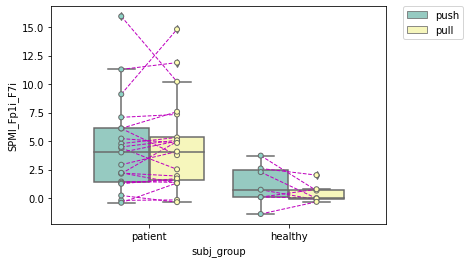

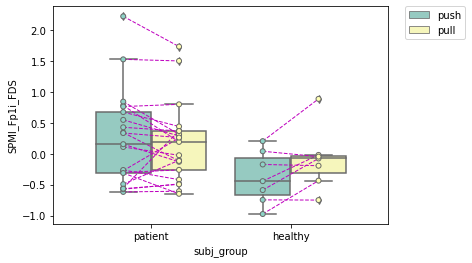

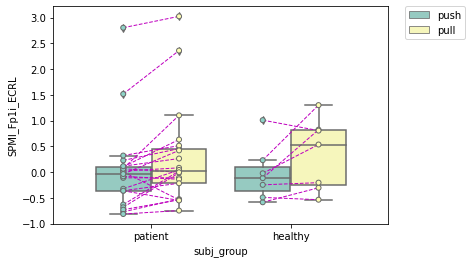

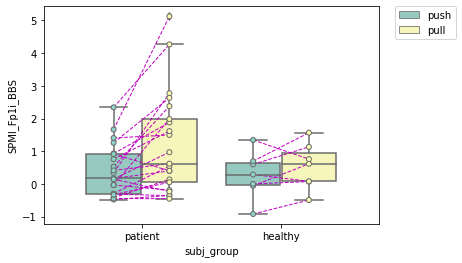

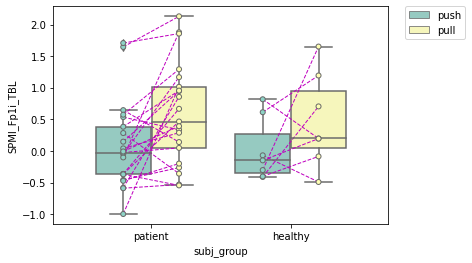

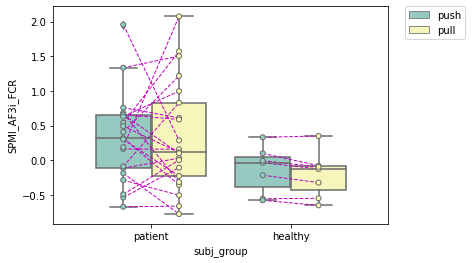

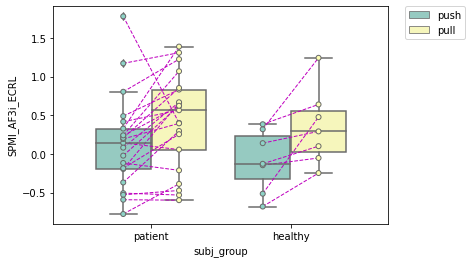

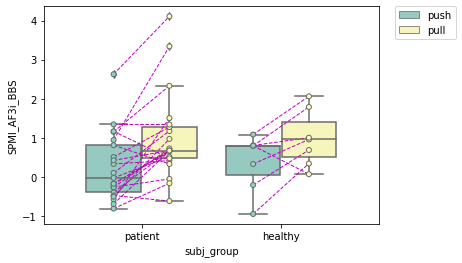

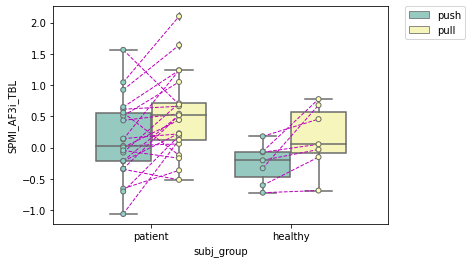

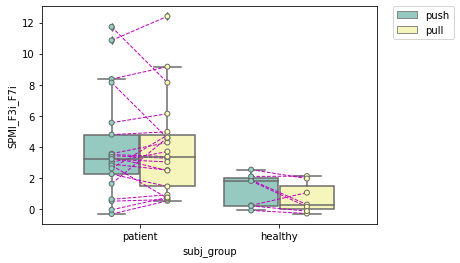

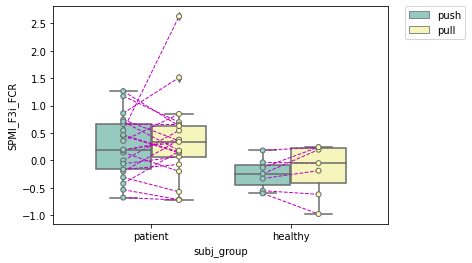

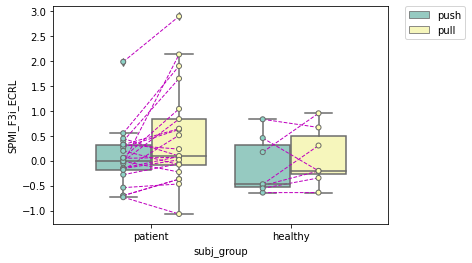

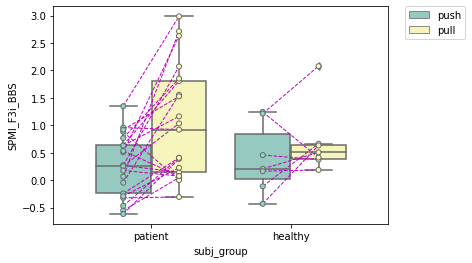

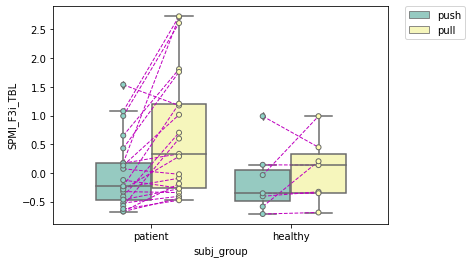

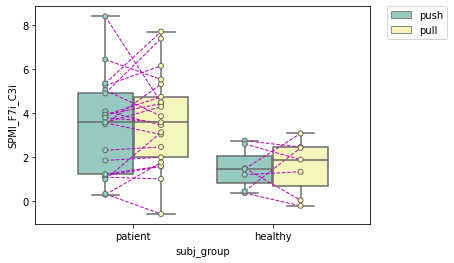

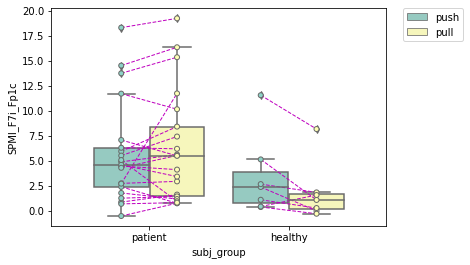

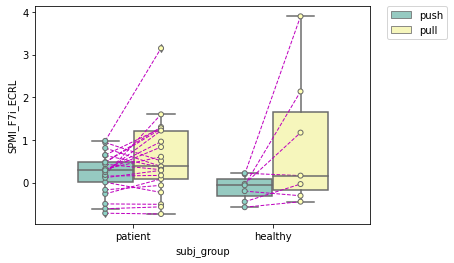

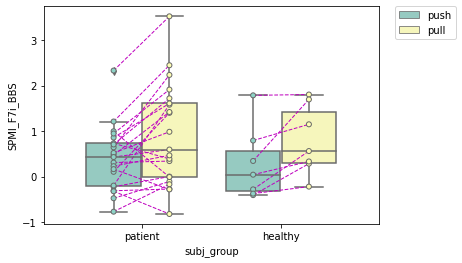

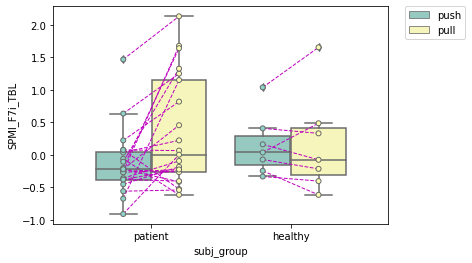

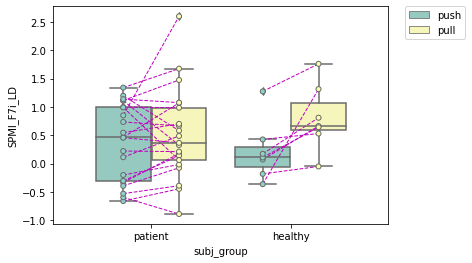

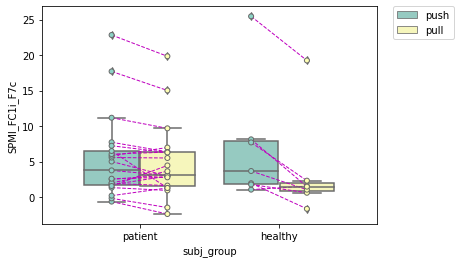

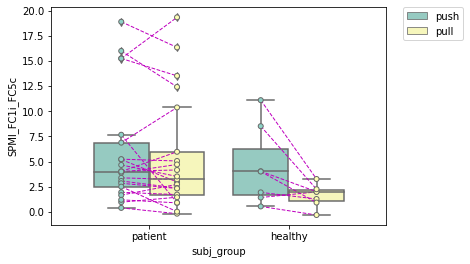

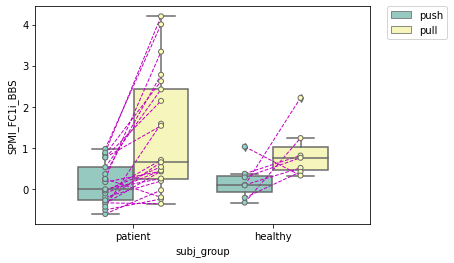

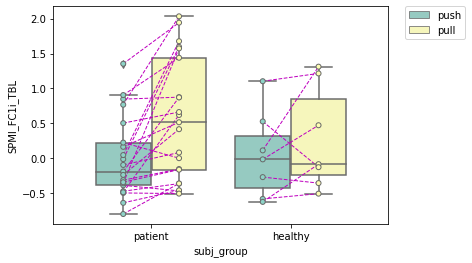

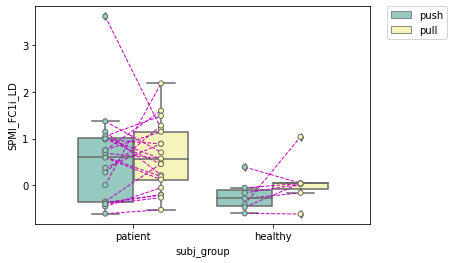

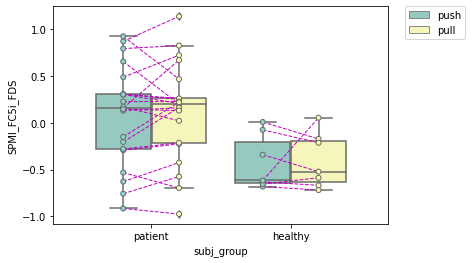

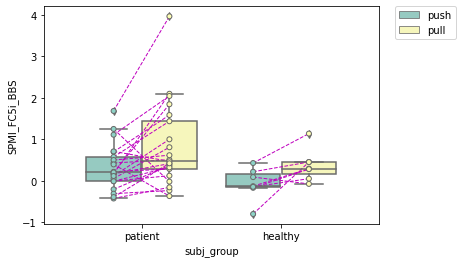

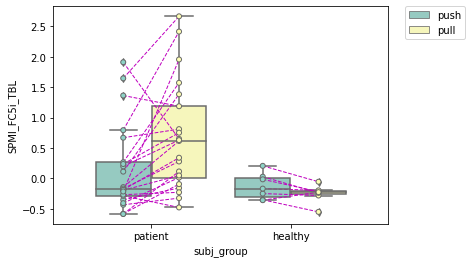

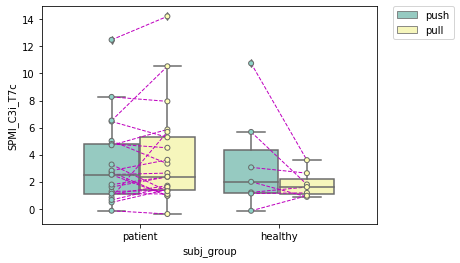

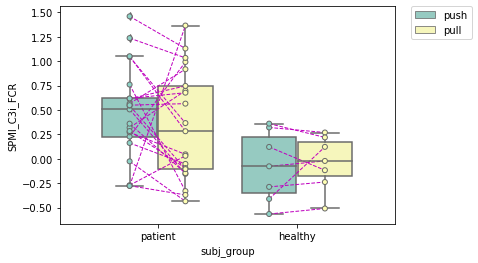

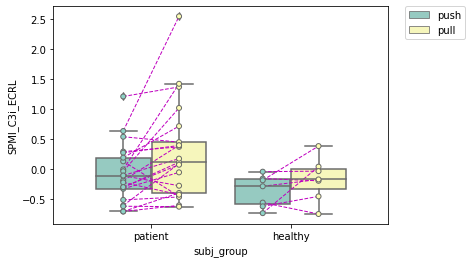

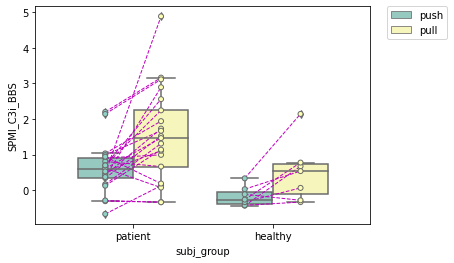

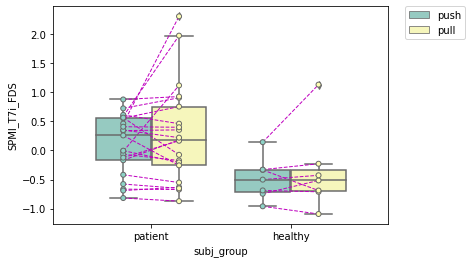

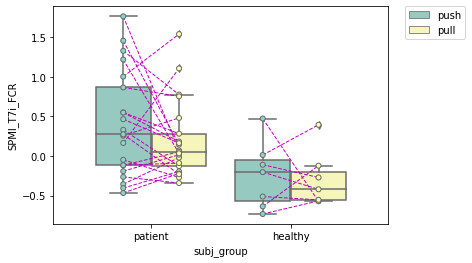

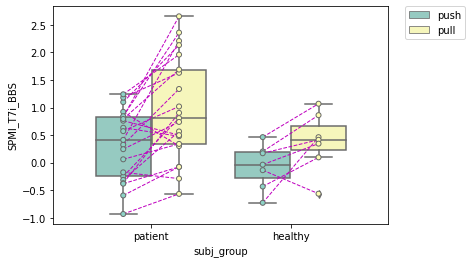

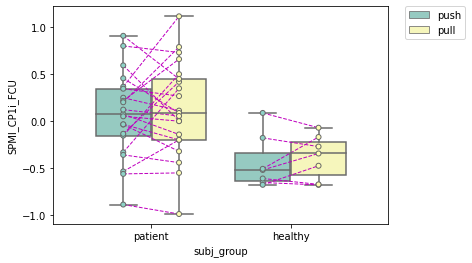

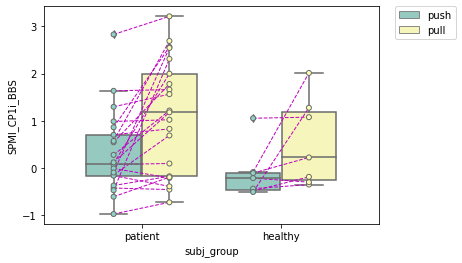

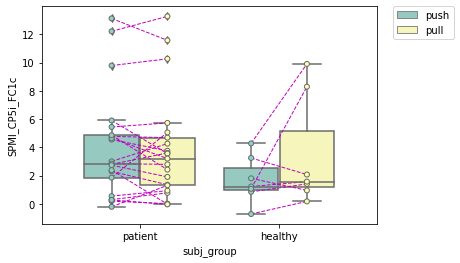

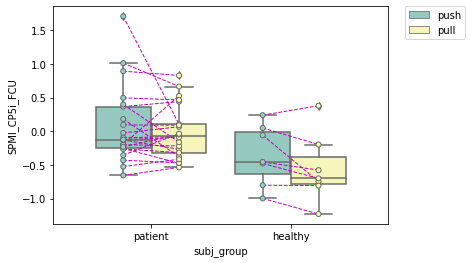

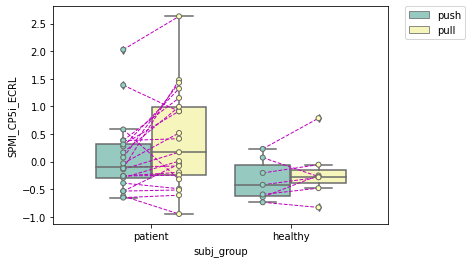

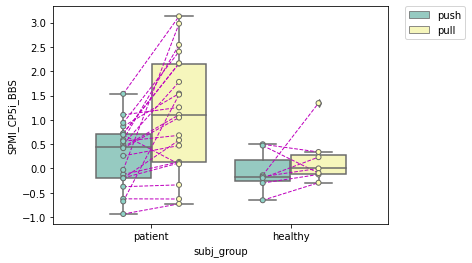

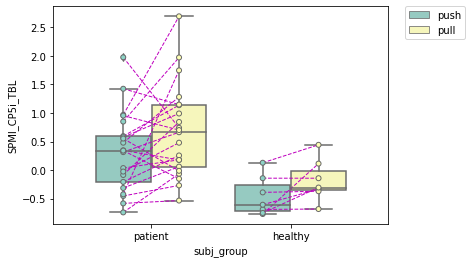

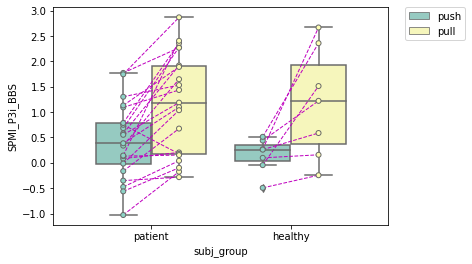

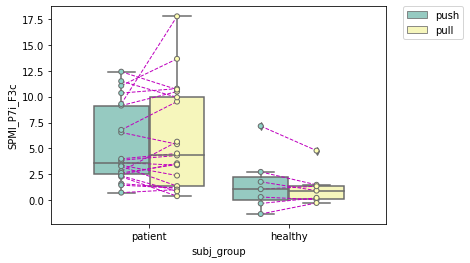

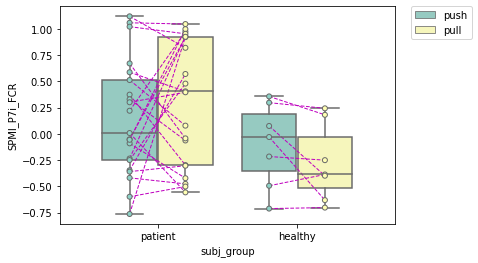

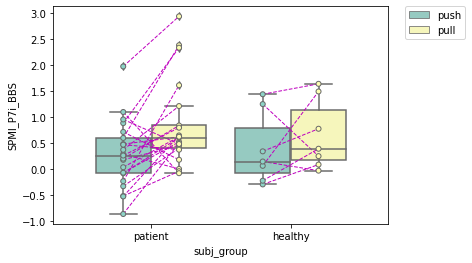

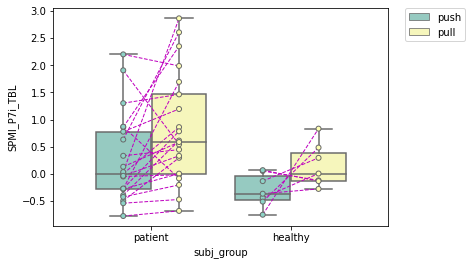

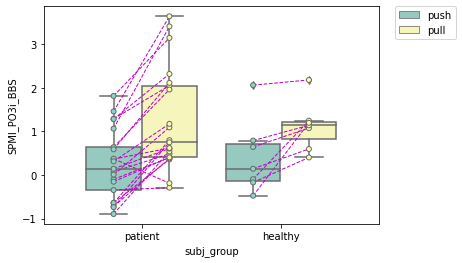

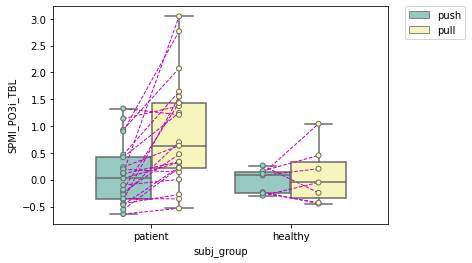

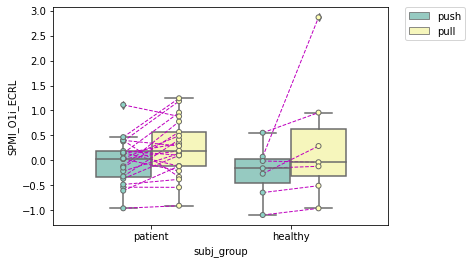

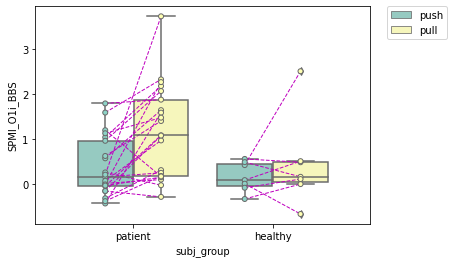

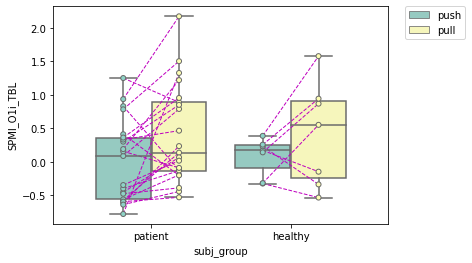

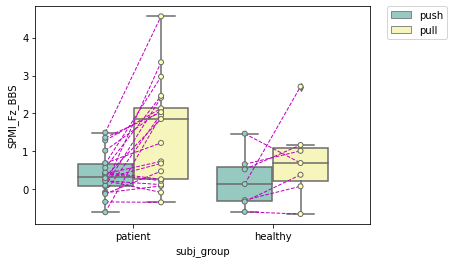

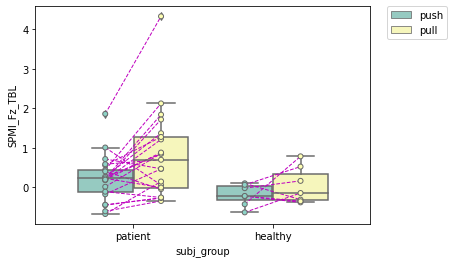

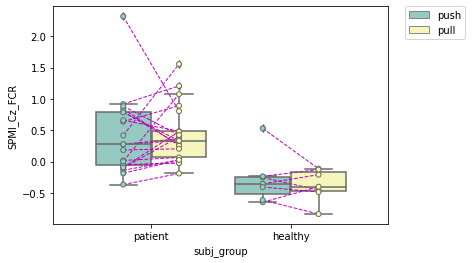

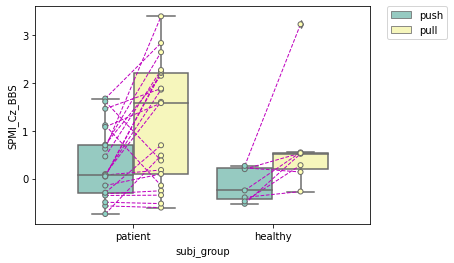

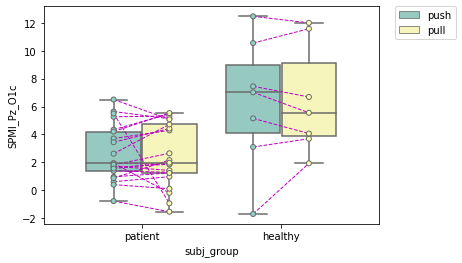

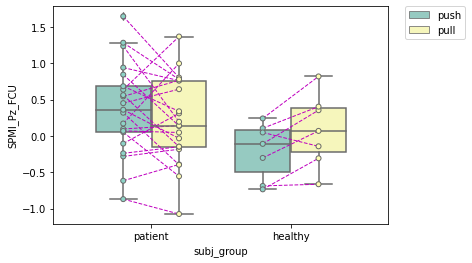

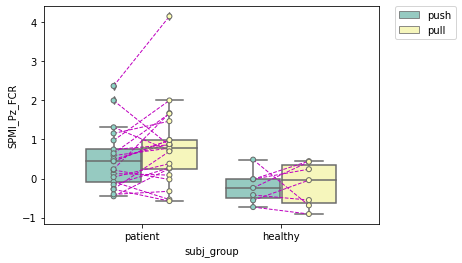

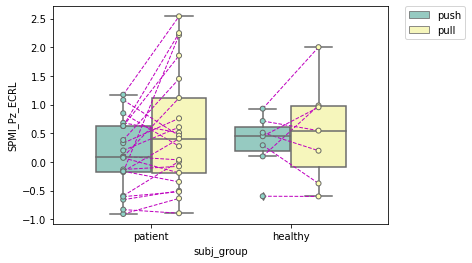

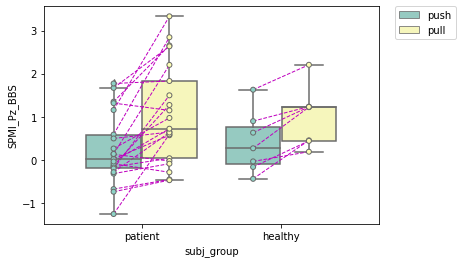

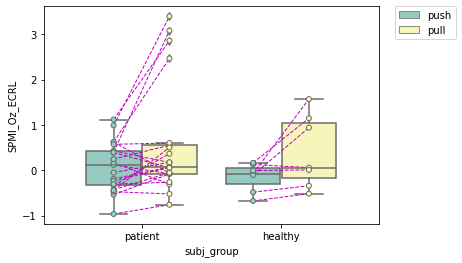

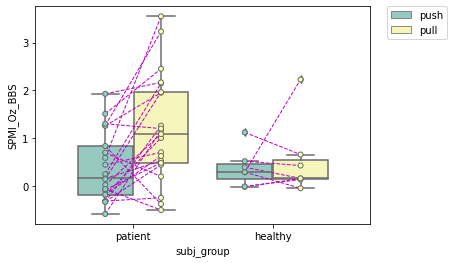

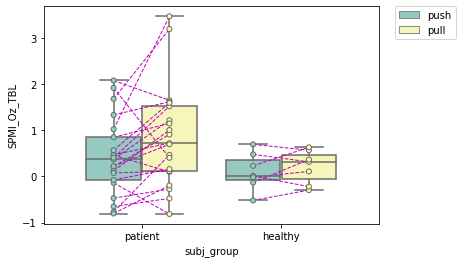

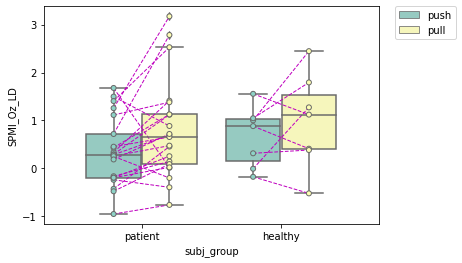

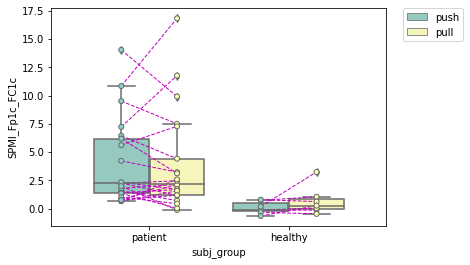

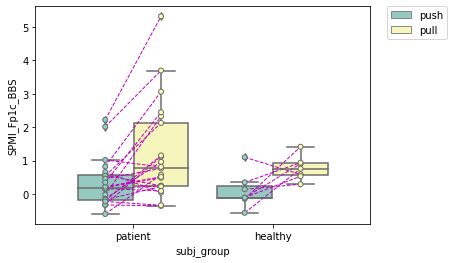

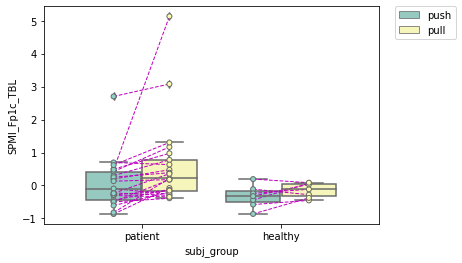

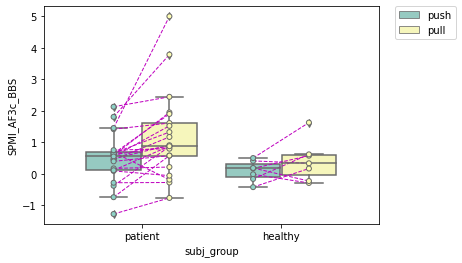

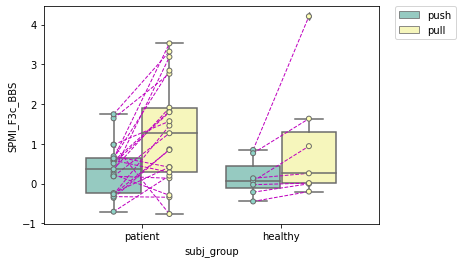

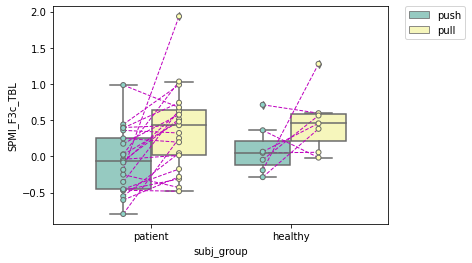

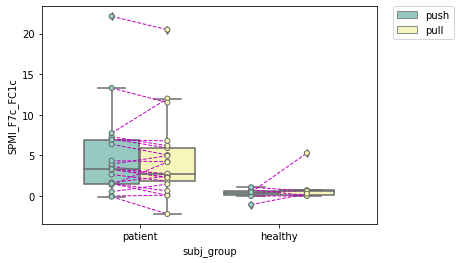

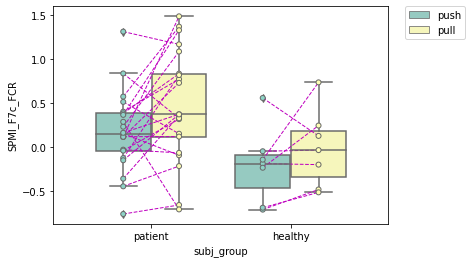

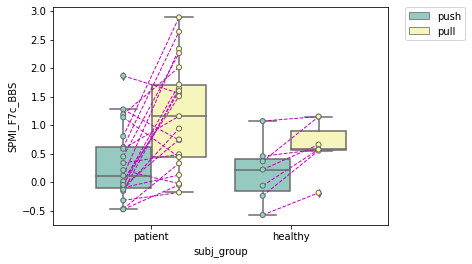

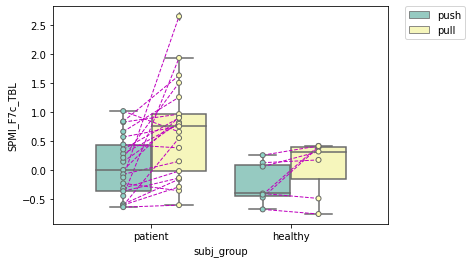

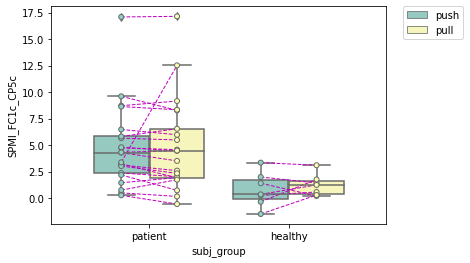

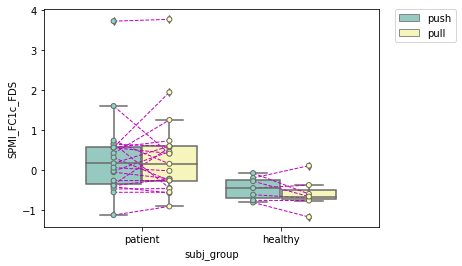

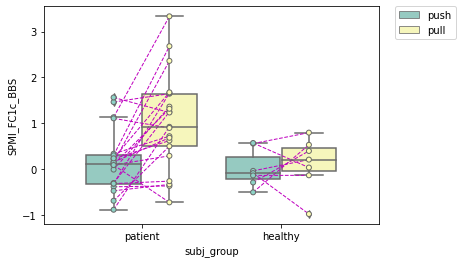

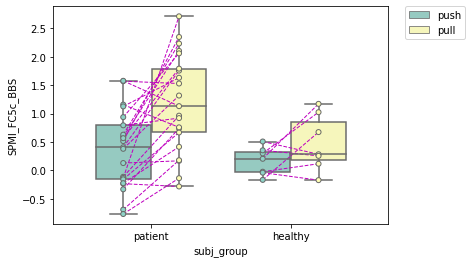

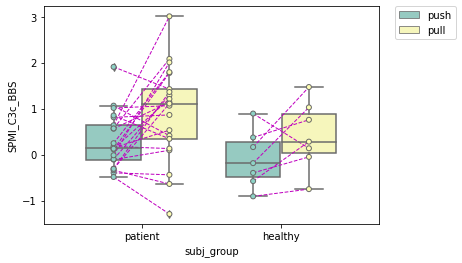

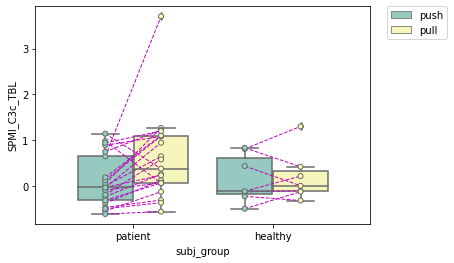

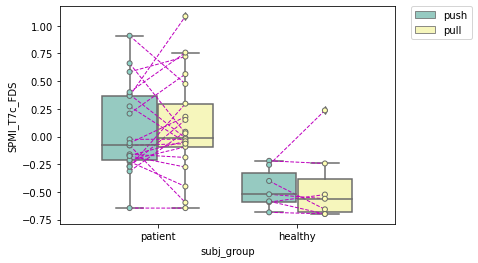

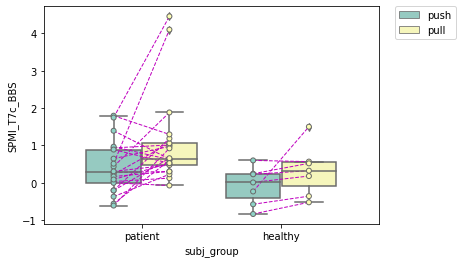

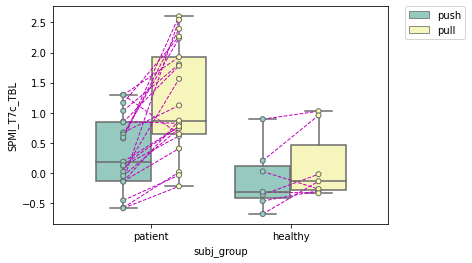

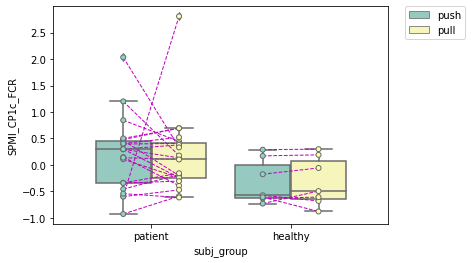

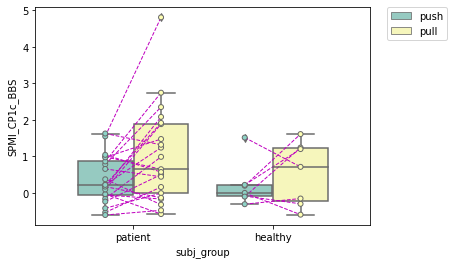

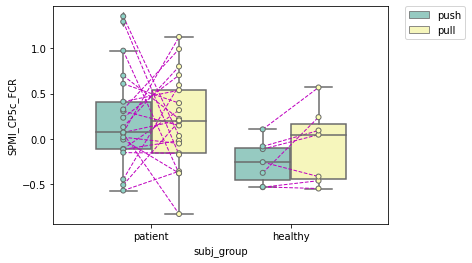

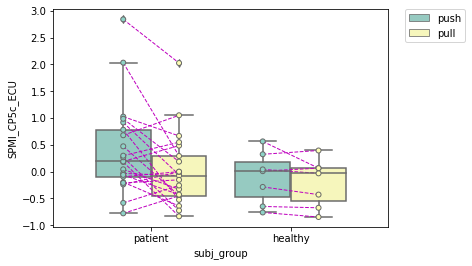

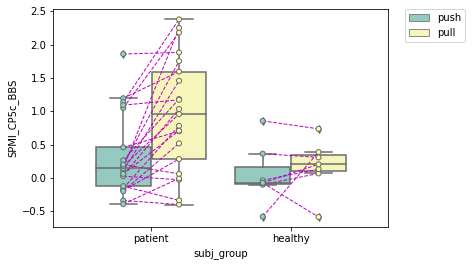

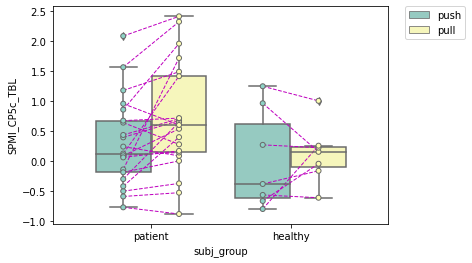

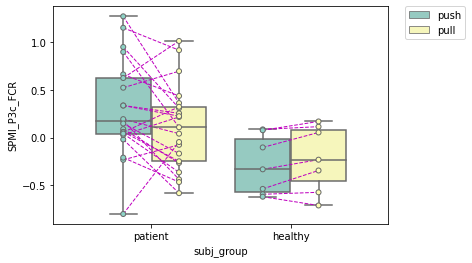

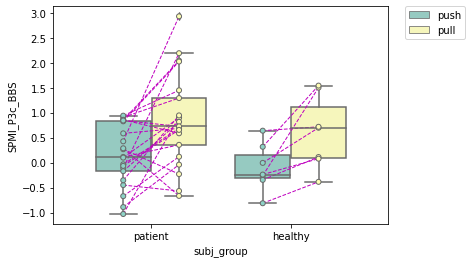

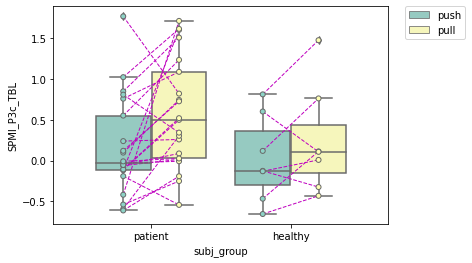

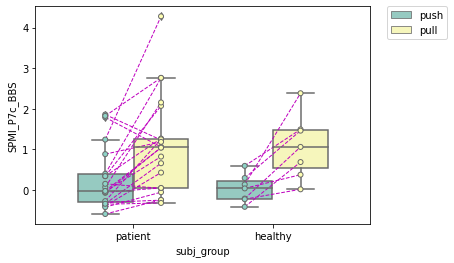

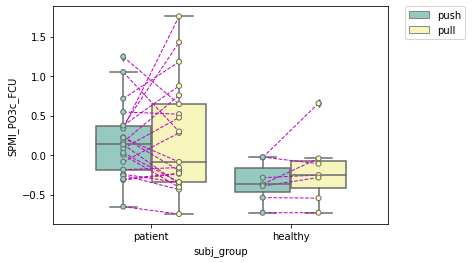

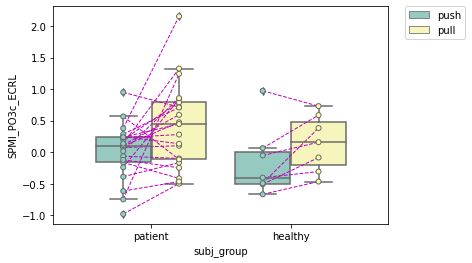

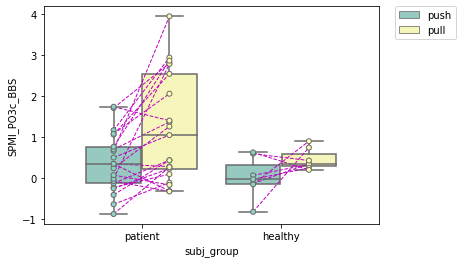

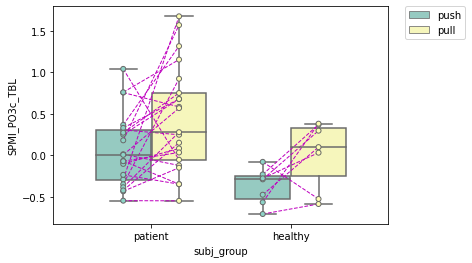

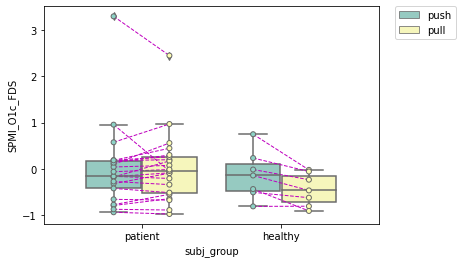

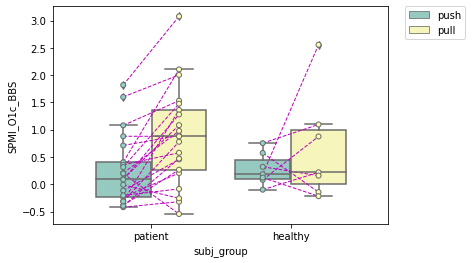

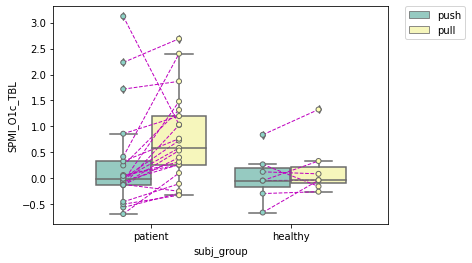

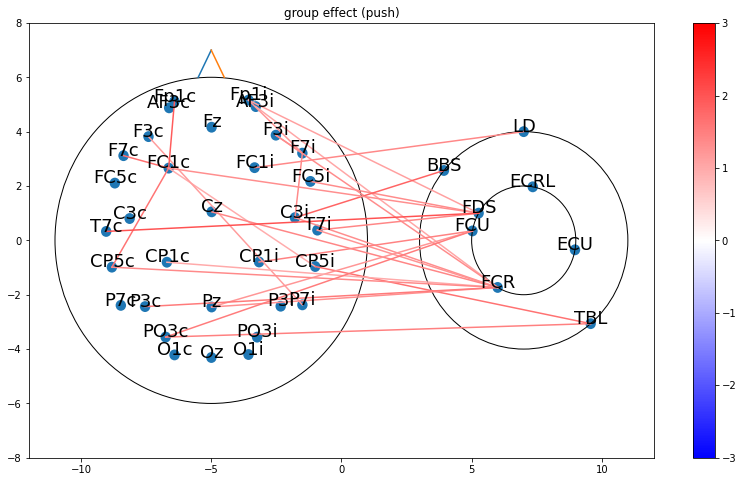

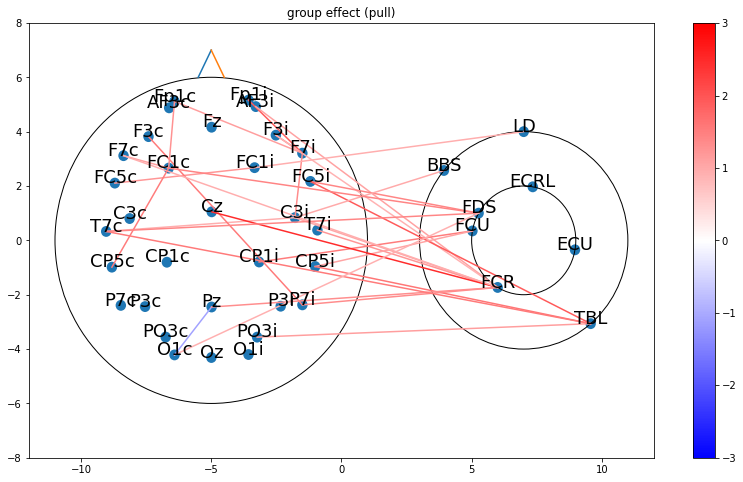

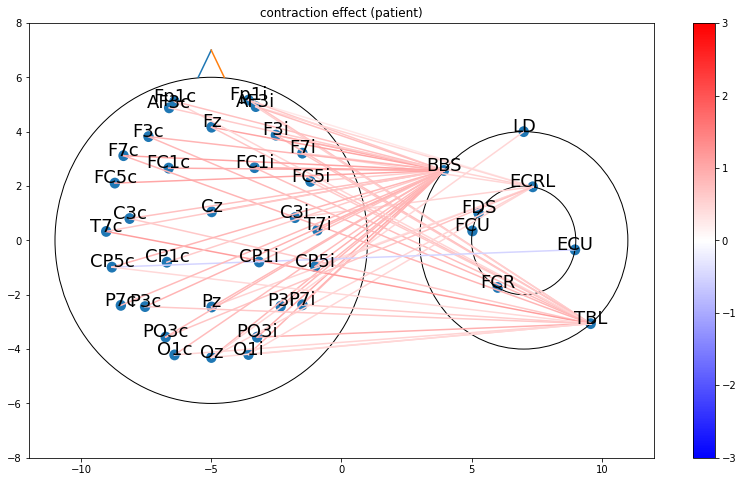

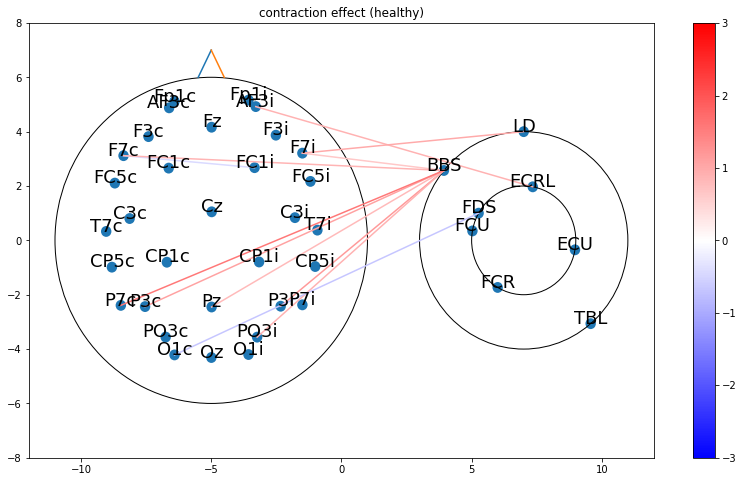

In [7]:
from bioinfokit.analys import stat
import pingouin as pg
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.expand_frame_repr', False)
bof_factor = 1 # 2levels for between/within subject var
bof_factor_ttest = 2 
n_chs = 40
alpha=.05
cons_sigInt = []
cons_sigSubj = []
cons_sigContt = []
cons_push_patient_healthy={}
cons_pull_patient_healthy={}
cons_patient_pull_push={}
cons_healthy_pull_push={}

for ch1_idx in range(n_chs):
    for ch2_idx in np.arange(ch1_idx+1,n_chs):
        ch1_name = chs_list_image[ch1_idx]
        ch2_name = chs_list_image[ch2_idx]
        res_var = 'SPMI_'+ch1_name+'_'+ch2_name
        aov = pg.mixed_anova(dv=res_var, within='contraction_group', between='subj_group', subject='subj_id', data=df)
        if aov['p-unc'].tolist()[2] < alpha: #interaction effect
            cons_sigInt.append(res_var)
            ### We use gameshowell here instead of Tukey HSD due to the unequal sample sizes
#             hsd_push = pg.pairwise_tukey(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
#             hsd_pull = pg.pairwise_tukey(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
            gsw_push = pg.pairwise_gameshowell(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
            gsw_pull = pg.pairwise_gameshowell(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
#             hsd_push['p-tukey'] = hsd_push['p-tukey']*bof_factor
#             hsd_pull['p-tukey'] = hsd_pull['p-tukey']*bof_factor
            ttest_contraction_healthy = pg.pairwise_ttests(dv=res_var, within = 'contraction_group',subject='subj_id', data=df.query('subj_group=="healthy"'), 
                                                           padjust='bonf').round(3)
            ttest_contraction_patient = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', subject='subj_id',data=df.query('subj_group=="patient"')).round(3)
            ttest_contraction_healthy['p-unc'] =   ttest_contraction_healthy['p-unc'] *bof_factor_ttest
            ttest_contraction_patient['p-unc'] =   ttest_contraction_patient['p-unc'] *bof_factor_ttest
#             if hsd_push['p-tukey'][0]<alpha:
#                 cons_push_patient_healthy[res_var] = -hsd_push['hedges'][0]
#             if hsd_pull['p-tukey'][0]<alpha:
#                 cons_pull_patient_healthy[res_var] = -hsd_pull['hedges'][0]
            if gsw_push['pval'][0]<alpha:
                cons_push_patient_healthy[res_var] = -gsw_push['hedges'][0]
            if gsw_pull['pval'][0]<alpha:
                cons_pull_patient_healthy[res_var] = -gsw_pull['hedges'][0]
            if ttest_contraction_healthy['p-unc'][0]<alpha:
                cons_healthy_pull_push[res_var] = ttest_contraction_healthy['hedges'][0]
            if ttest_contraction_patient['p-unc'][0]<alpha:
                cons_patient_pull_push[res_var] = ttest_contraction_patient['hedges'][0]
            if (gsw_push['pval']<alpha).any() or (gsw_pull['pval']<alpha).any() or (ttest_contraction_healthy['p-unc']<alpha).any() or \
            (ttest_contraction_patient['p-unc']<alpha).any():
                print('intE: ' + bold_color.BOLD+res_var+bold_color.END)
                print('Normality - push: {0}, Normality - pull: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                               group='contraction_group').loc['push','normal'],
                      pg.normality(data=df,dv=res_var,group='contraction_group').loc['pull','normal']))
                print('Normality - healthy: {0}, Normality - patients: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                                                group='subj_group').loc['healthy','normal'],
                                                                                                   pg.normality(data=df,dv=res_var,
                                                                                                                group='subj_group').loc['patient','normal']))
                # HOMOGENEITY FOR BETWEEN SUBJECT VAR
                print('Homogeneity - subj_group: {}'.format( pg.homoscedasticity(data=df,dv=res_var,
                                                                                                    group='subj_group')['equal_var'].values[0]))
                # Sphericity is met, we use normality check to cover outlier test
                
                pg.print_table(aov,floatfmt='.4f')
                
                print('push: posthoc on group')
                pg.print_table(gsw_push,floatfmt='.4f')
                print('\n')
                print('pull: posthoc on group')
                pg.print_table(gsw_pull,floatfmt='.4f')
                print('\n')
                print('healthy: pull vs (-) push (paired ttest)')
                pg.print_table(ttest_contraction_healthy,floatfmt='.4f')
                print('\n')
                print('patient: pull vs (-) push (paired ttest)')
                pg.print_table(ttest_contraction_patient,floatfmt='.4f')
               
                plt.figure()
                ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3") 
                
                stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
                handles, labels = stplot.get_legend_handles_labels()
                l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                for i in range(2):
                    plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
                             [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
                             linewidth=1,c='m')

                fig = ax.get_figure()
                fig.savefig(os.path.join(iVC_results_dir,res_var+'_mANOVA_bp.eps'))
                continue
            
        elif aov['p-unc'].tolist()[0] < alpha: #main group effect
            cons_sigSubj.append(res_var)
            ### Tukey HSD
#             hsd_push = pg.pairwise_tukey(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
#             hsd_pull = pg.pairwise_tukey(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
#             hsd_push['p-tukey'] = hsd_push['p-tukey']*bof_factor
#             hsd_pull['p-tukey'] = hsd_pull['p-tukey']*bof_factor
            gsw_push = pg.pairwise_gameshowell(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
            gsw_pull = pg.pairwise_gameshowell(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')

            if (gsw_push['pval'][0]<alpha) & (res_var not in cons_push_patient_healthy.keys()):
                cons_push_patient_healthy[res_var] = -gsw_push['hedges'][0]
            if (gsw_pull['pval'][0]<alpha) & (res_var not in cons_pull_patient_healthy.keys()):
                cons_pull_patient_healthy[res_var] = -gsw_pull['hedges'][0]
            if (gsw_push['pval']<alpha).any() or (gsw_pull['pval']<alpha).any() :
                print('groupE: '+bold_color.BOLD+res_var+bold_color.END)
                print('Normality - push: {0}, Normality - pull: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                               group='contraction_group').loc['push','normal'],
                      pg.normality(data=df,dv=res_var,group='contraction_group').loc['pull','normal']))
                print('Normality - healthy: {0}, Normality - patients: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                                                group='subj_group').loc['healthy','normal'],
                                                                                                   pg.normality(data=df,dv=res_var,
                                                                                                                group='subj_group').loc['patient','normal']))
                # HOMOGENEITY FOR BETWEEN SUBJECT VAR
                print('Homogeneity - subj_group: {}'.format(pg.homoscedasticity(data=df,dv=res_var,
                                                                                                    group='subj_group')['equal_var'].values[0]))
                # Sphericity is met, we use normality check to cover outlier test

                pg.print_table(aov,floatfmt='.4f')
                print('push: posthoc on group')
                pg.print_table(gsw_push,floatfmt='.4f')
                print('\n')
                print('pull: posthoc on group')
                pg.print_table(gsw_pull,floatfmt='.4f')

                plt.figure()
                ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3") 

                stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
                handles, labels = stplot.get_legend_handles_labels()
                l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                for i in range(3):
                    plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
                             [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
                             linewidth=1,c='m')

                fig = ax.get_figure()
                fig.savefig(os.path.join(iVC_results_dir,res_var+'_mANOVA_bp.eps'))
                continue

        elif aov['p-unc'].tolist()[1] < alpha: #main contraction effect
            cons_sigContt.append(res_var)
            ### paired t-test
            ttest_contraction_healthy = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', 
                                                        subject='subj_id', data=df.query('subj_group=="healthy"')).round(3)
            ttest_contraction_patient = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', 
                                                        subject='subj_id', data=df.query('subj_group=="patient"')).round(3)
            ttest_contraction_healthy['p-unc'] =   ttest_contraction_healthy['p-unc'] *bof_factor_ttest
            ttest_contraction_patient['p-unc'] =   ttest_contraction_patient['p-unc'] *bof_factor_ttest
            if (ttest_contraction_healthy['p-unc'][0]<alpha) & (res_var not in cons_healthy_pull_push.keys()):
                cons_healthy_pull_push[res_var] = ttest_contraction_healthy['hedges'][0]
            if (ttest_contraction_patient['p-unc'][0]<alpha) & (res_var not in cons_patient_pull_push.keys()):
                cons_patient_pull_push[res_var] = ttest_contraction_patient['hedges'][0]

            if (ttest_contraction_healthy['p-unc']<alpha).any() or (ttest_contraction_patient['p-unc']<alpha).any():
                print('conttE: '+bold_color.BOLD+res_var+bold_color.END)
                print('Normality - push: {0}, Normality - pull: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                               group='contraction_group').loc['push','normal'],
                      pg.normality(data=df,dv=res_var,group='contraction_group').loc['pull','normal']))
                print('Normality - healthy: {0}, Normality - patients: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                                                group='subj_group').loc['healthy','normal'],
                                                                                                   pg.normality(data=df,dv=res_var,
                                                                                                                group='subj_group').loc['patient','normal']))
                # HOMOGENEITY FOR BETWEEN SUBJECT VAR
                print('Homogeneity - subj_group: {}'.format(pg.homoscedasticity(data=df,dv=res_var,
                                                                                                    group='subj_group')['equal_var'].values[0]))
                # Sphericity is met, we use normality check to cover outlier test


                print('\n')
                print('healthy: pull vs (-) push (paired ttest)')
                pg.print_table(ttest_contraction_healthy,floatfmt='.4f')
                print('\n')
                print('patient: pull vs (-) push (paired ttest)')
                pg.print_table(ttest_contraction_patient,floatfmt='.4f')

                plt.figure()
                ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3") 

                stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
                handles, labels = stplot.get_legend_handles_labels()
                l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
                for i in range(3):
                    plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
                             [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
                             linewidth=1,c='m')

                fig = ax.get_figure()
                fig.savefig(os.path.join(iVC_results_dir,res_var+'_mANOVA_bp.eps'))




            

topo_m4plot = None
topo_list = [cons_push_patient_healthy, cons_pull_patient_healthy, cons_patient_pull_push, cons_healthy_pull_push]
for topo in topo_list:
    topo_m = np.zeros([n_chs,n_chs])
    for topo_SPMI in topo.keys():
        ch1_name = topo_SPMI.split('_')[1]
        ch2_name = topo_SPMI.split('_')[2]
        ch1_idx = chs_list_image.index(ch1_name)
        ch2_idx = chs_list_image.index(ch2_name)
        topo_m[ch1_idx,ch2_idx]= topo[topo_SPMI]
    if topo_m.any() == False:
        continue
    if topo_m4plot is None:
        topo_m4plot = topo_m
    fig,ax = plt.subplots(figsize=(14, 8))
    ax = plt.gca()
    ax = plotTopoEMG(EMGs,ax)
    ax = plotTopoEEG(EEGs,ax)
    ax.set_xlim([-12,12])
    ax.set_ylim([-8,8])
    fig,ax = graph_plot_fixMapper(topo_m,topo_m4plot,fig,ax)
    if topo == cons_push_patient_healthy:
        ax.set_title('group effect (push)')
        fig.savefig(os.path.join(iVC_results_dir,'p_h_push_topo.eps'))
    elif topo == cons_pull_patient_healthy:
        ax.set_title('group effect (pull)')
        fig.savefig(os.path.join(iVC_results_dir,'p_h_pull_topo.eps'))
    elif topo == cons_healthy_pull_push:
        ax.set_title('contraction effect (healthy)')
        fig.savefig(os.path.join(iVC_results_dir,'pull_push_healthy_topo.eps'))
    else:
        ax.set_title('contraction effect (patient)')
        fig.savefig(os.path.join(iVC_results_dir,'pull_push_patient_topo.eps'))
        


## Section 3-2: regression-push (greedy search) and visualization, Hedge's g indicated by color

SPMI_FC5i_BBS
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     19.75
Date:                Sun, 16 May 2021   Prob (F-statistic):           0.000279
Time:                        13:07:11   Log-Likelihood:                -76.135
No. Observations:                  21   AIC:                             156.3
Df Residuals:                      19   BIC:                             158.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.0388      2.453     1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

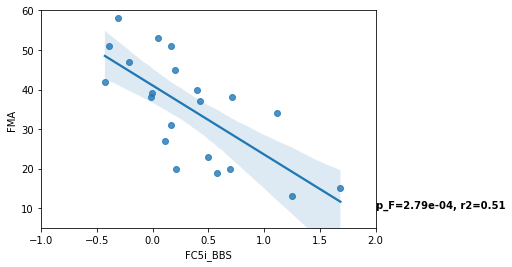

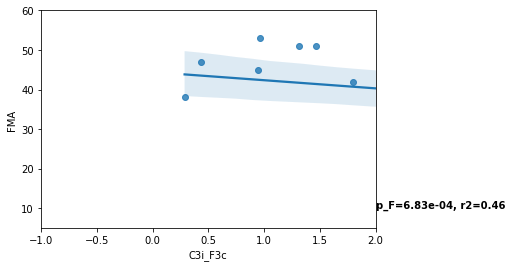

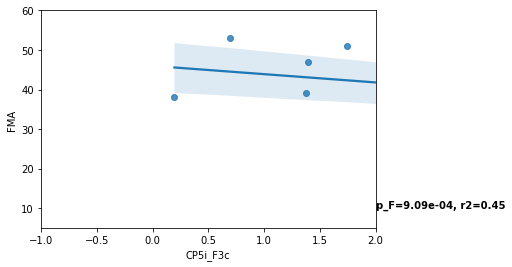

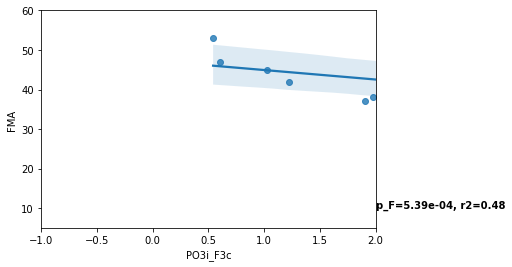

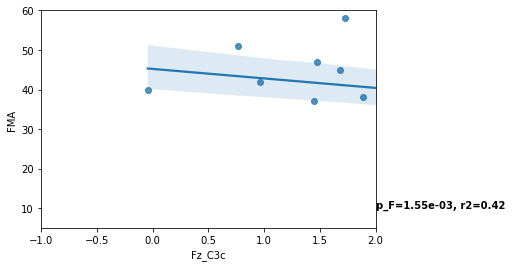

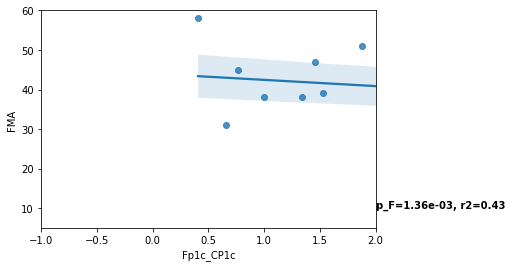

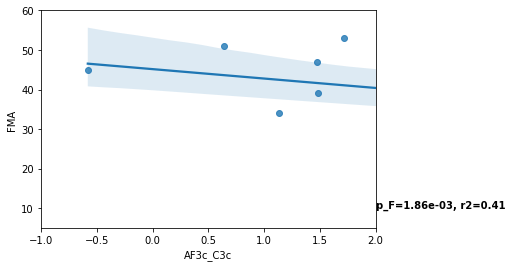

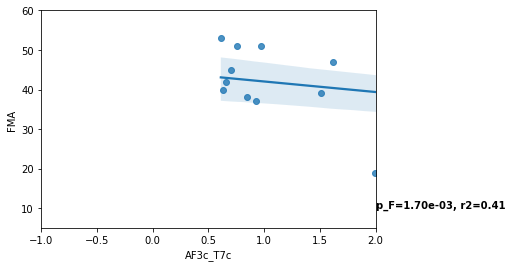

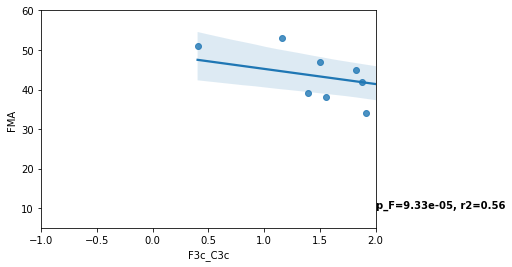

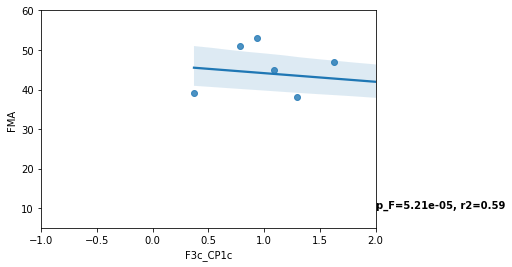

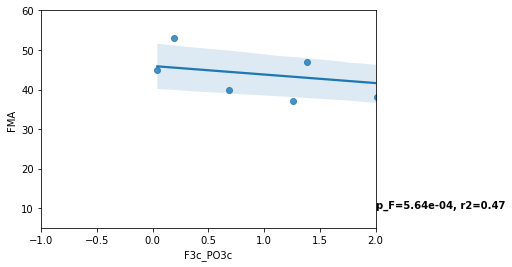

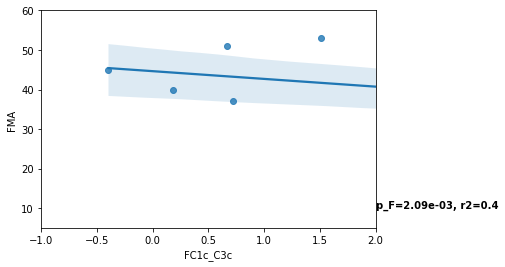

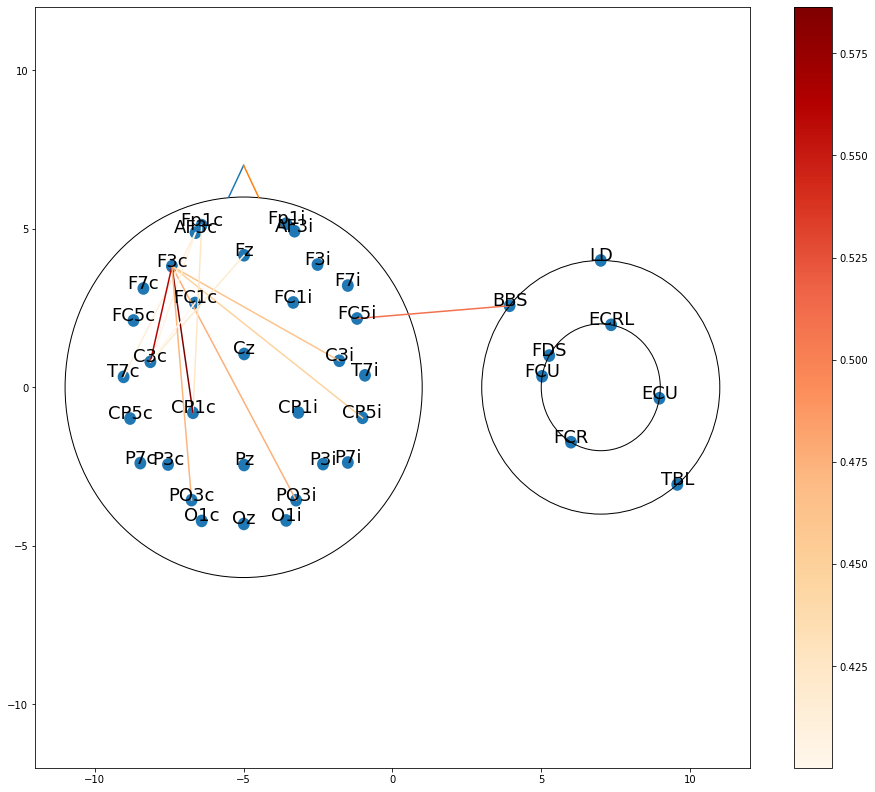

In [57]:
import scipy
from numpy import mean
from numpy import var
from math import sqrt
import statsmodels.api as sm
alpha = 1e-2
r2_threshold = 0.4

related_cons=[]
model_stats = []
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'FMA'].to_numpy().astype(np.float)
for ch1_idx in range(n_chs):
    for ch2_idx in np.arange(ch1_idx+1,n_chs):
        ch1_name = chs_list_image[ch1_idx]
        ch2_name = chs_list_image[ch2_idx]
        SPMI_ch1ch2_patient_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),
                                            'SPMI_'+ch1_name+'_'+ch2_name].to_numpy().astype(np.float)
        
        SPMI_ch1ch2_patient_push =sm.add_constant(SPMI_ch1ch2_patient_push)
        model = sm.OLS(FMAs,SPMI_ch1ch2_patient_push).fit()
        if (model.f_pvalue<alpha) & (model.rsquared>r2_threshold):
            print('SPMI_'+ch1_name+'_'+ch2_name)
            print(model.summary())
#             print(model.predict(SPMI_ch1ch2_patient_push))
#             print(FMAs)
            related_cons.append([ch1_name,ch2_name,model.rsquared])
#             model_stats.append([round(model.f_pvalue,2),round(model.rsquared_adj,2)])
            model_stats.append(["{:.2e}".format(model.f_pvalue),round(model.rsquared,2)])

#visualization
import seaborn as sns
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'FMA'].to_numpy().astype(np.float)
for i in range(len(related_cons)):
    ch1_name = related_cons[i][0]
    ch2_name = related_cons[i][1]
    SPMI_ch1ch2_patient_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),
                                            'SPMI_'+ch1_name+'_'+ch2_name].to_numpy().astype(np.float)

    plt.figure()
    ax = sns.regplot(x=SPMI_ch1ch2_patient_push, y=FMAs)
    ax.set(xlabel=ch1_name+'_'+ch2_name, ylabel='FMA')
    ax.set_xlim([-1,2])
    ax.set_ylim([5,60])
    plt.text(2, 10, "p_F="+str(model_stats[i][0])+", r2="+str(model_stats[i][1]), horizontalalignment='left', 
             size='medium', color='black', weight='semibold')
    regPlot_fName = os.path.join(global_results_dir,'iVC',ch1_name+'-'+ch2_name+'push_FMAreg.eps')
    figure = ax.get_figure()
    figure.savefig(regPlot_fName)
########### customization ###################

con_reg_push_g_fName = os.path.join(iVC_results_dir,'con_reg_push_g.eps') #after-before
#########################################
con_reg = np.zeros([n_chs,n_chs])
for con in related_cons:
    con_reg[chs_list_image.index(con[0]),chs_list_image.index(con[1])]=con[2]
fig,ax = plt.subplots(figsize=(16, 14))
ax = plt.gca()
ax = plotTopoEMG(EMGs,ax)
ax = plotTopoEEG(EEGs,ax)
# fig,ax = graph_plot_fixMapper(con_reg,con_reg,fig,ax)
minima = np.min(con_reg[np.nonzero(con_reg)])
maxima = np.max(con_reg)
if minima==maxima:
    minima-=0.2
    maxima+=0.2
norm = matplotlib.colors.Normalize(vmin=minima,vmax=maxima,clip=True)
mapper = cm.ScalarMappable(norm=norm,cmap='OrRd')
fig,ax = graph_plot_chooseMapper(con_reg,mapper,fig,ax)
plt.xlim([-12,12])
plt.ylim([-12,12])
fig.savefig(con_reg_push_g_fName)

## Section 3-3: regression-pull (greedy search) and visualization 

SPMI_F3i_C3c
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     13.59
Date:                Tue, 25 May 2021   Prob (F-statistic):            0.00157
Time:                        21:38:04   Log-Likelihood:                -77.954
No. Observations:                  21   AIC:                             159.9
Df Residuals:                      19   BIC:                             162.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.3726      3.353     13

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

NameError: name 'mapper' is not defined

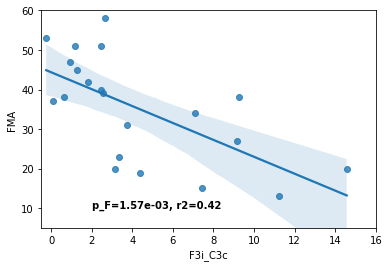

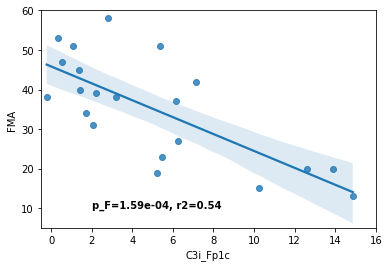

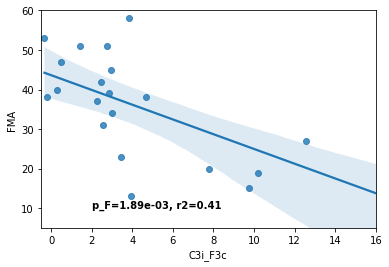

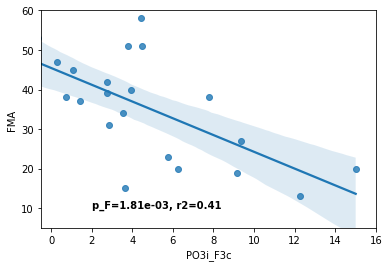

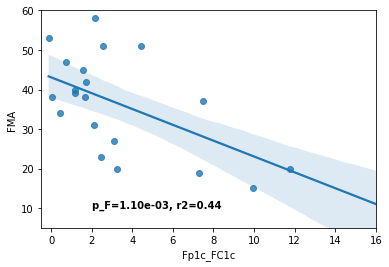

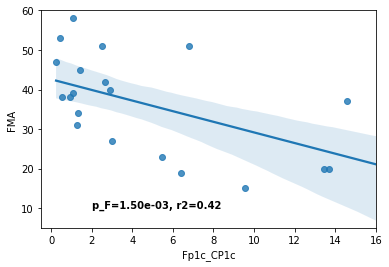

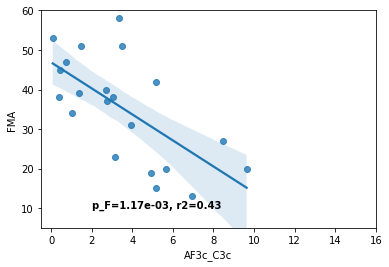

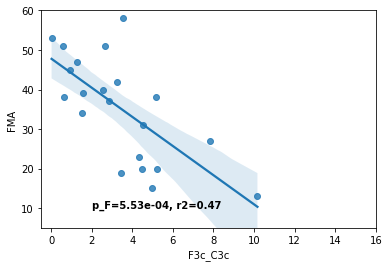

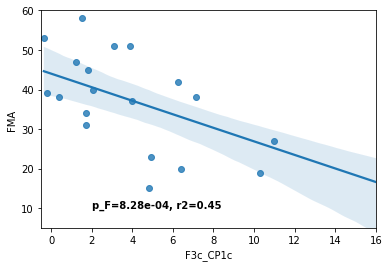

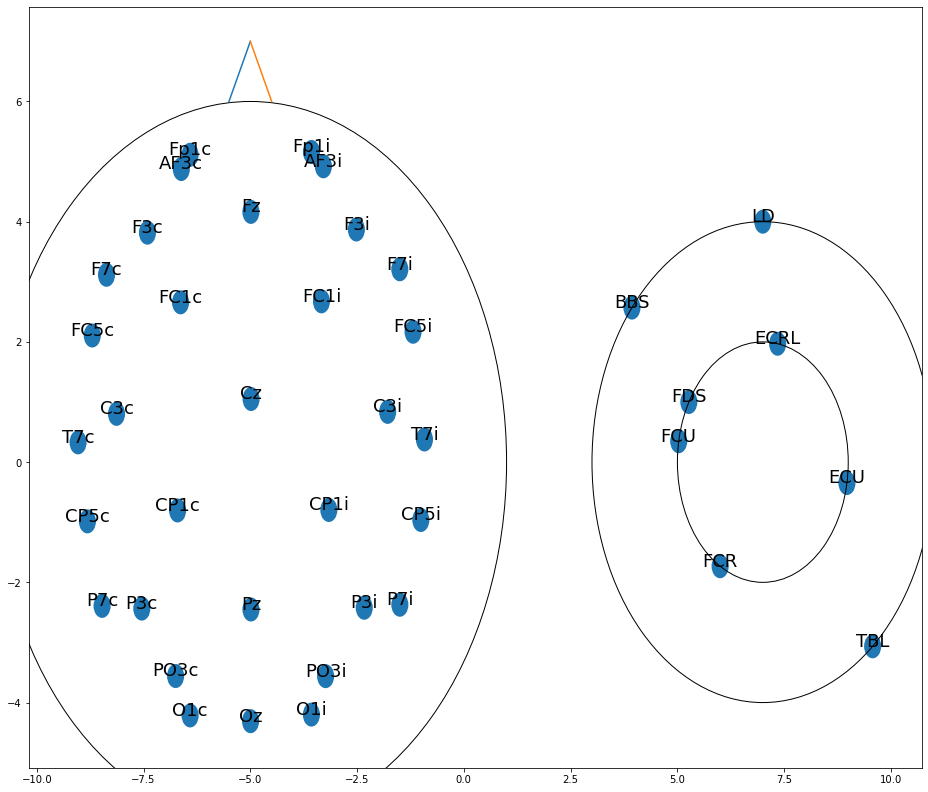

In [10]:
import scipy
from numpy import mean
from numpy import var
from math import sqrt
import statsmodels.api as sm
alpha = 1e-2
r2_threshold = 0.4
related_cons=[]
model_stats = []
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)
for ch1_idx in range(n_chs):
    for ch2_idx in np.arange(ch1_idx+1,n_chs):
        ch1_name = chs_list_image[ch1_idx]
        ch2_name = chs_list_image[ch2_idx]
        SPMI_ch1ch2_patient_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),
                                            'SPMI_'+ch1_name+'_'+ch2_name].to_numpy().astype(np.float)
        SPMI_ch1ch2_patient_pull =sm.add_constant(SPMI_ch1ch2_patient_pull)
        model = sm.OLS(FMAs,SPMI_ch1ch2_patient_pull).fit()
        if (model.f_pvalue<alpha) & (model.rsquared>r2_threshold):
            print('SPMI_'+ch1_name+'_'+ch2_name)
            print(model.summary())
#             print(model.predict(SPMI_ch1ch2_patient_push))
#             print(FMAs)
            related_cons.append([ch1_name,ch2_name,model.rsquared])
#             model_stats.append([round(model.f_pvalue,2),round(model.rsquared_adj,2)])
            model_stats.append(["{:.2e}".format(model.f_pvalue),round(model.rsquared,2)])

#visualization
import seaborn as sns
for i in range(len(related_cons)):
    ch1_name = related_cons[i][0]
    ch2_name = related_cons[i][1]
    SPMI_ch1ch2_patient_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),
                                            'SPMI_'+ch1_name+'_'+ch2_name].to_numpy().astype(np.float)

    plt.figure()
    ax = sns.regplot(x=SPMI_ch1ch2_patient_pull, y=FMAs)
    ax.set(xlabel=ch1_name+'_'+ch2_name, ylabel='FMA')
    ax.set_xlim([-0.5,16])
    ax.set_ylim([5,60])
    plt.text(2, 10, "p_F="+str(model_stats[i][0])+", r2="+str(model_stats[i][1]), horizontalalignment='left', 
             size='medium', color='black', weight='semibold')
    regPlot_fName = os.path.join(global_results_dir,'iVC',ch1_name+'-'+ch2_name+'pull_FMAreg.eps')
    figure = ax.get_figure()
    figure.savefig(regPlot_fName)
########### customization ###################

con_reg_pull_g_fName = os.path.join(iVC_results_dir,'con_reg_pull_g.eps') #after-before
#########################################
if len(related_cons)!=0:
    con_reg = np.zeros([n_chs,n_chs])
    for con in related_cons:
        con_reg[chs_list_image.index(con[0]),chs_list_image.index(con[1])]=con[2]
    fig,ax = plt.subplots(figsize=(16, 14))
    ax = plt.gca()
    ax = plotTopoEMG(EMGs,ax)
    ax = plotTopoEEG(EEGs,ax)
#     fig,ax = graph_plot_fixMapper(con_reg,con_reg,fig,ax)
    fig,ax = graph_plot_chooseMapper(con_reg,mapper,fig,ax)
    plt.xlim([-12,12])
    plt.ylim([-12,12])
    fig.savefig(con_reg_pull_g_fName)
else:
    print('Not Found!')

## Section 3-4: integral regression

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.708
Method:                 Least Squares   F-statistic:                     13.14
Date:                Sun, 16 May 2021   Prob (F-statistic):           6.26e-05
Time:                        13:29:18   Log-Likelihood:                -68.336
No. Observations:                  21   AIC:                             146.7
Df Residuals:                      16   BIC:                             151.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7485      2.809     16.996      0.0

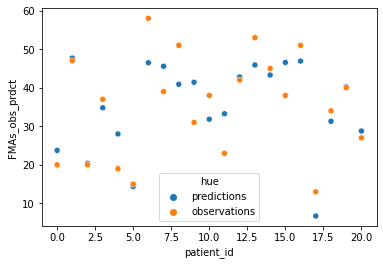

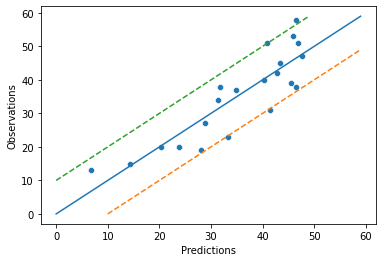

In [64]:
# integral model
push_X_names=['SPMI_F3c_C3c','SPMI_F3c_CP1c','SPMI_FC5i_BBS']
pull_X_names=['SPMI_C3i_Fp1c']
# pull_X_names=[]
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)
X=[]
for name in push_X_names:
    X.append(df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),name].to_numpy().astype(np.float))
for name in pull_X_names:
    X.append(df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),name].to_numpy().astype(np.float))

X=np.array(X)
X=np.swapaxes(X,0,1)
X=sm.add_constant(X)
model = sm.OLS(FMAs,X).fit()
predictions = model.predict(X)
print(model.summary())
print('\n')
print(predictions)
print(FMAs)

patient_id = np.arange(len(predictions))
patient_id = np.hstack([patient_id,patient_id])
FMAs_obs_prdct = np.hstack([predictions,FMAs])
hue =np.hstack([['predictions']*len(predictions),['observations']*len(FMAs)])
data_intReg = {'patient_id':patient_id,'FMAs_obs_prdct':FMAs_obs_prdct,'hue':hue}
df_intReg = pd.DataFrame(data_intReg)
# df_intReg
fig = sns.scatterplot(x='patient_id',y='FMAs_obs_prdct',hue='hue',data=df_intReg)
plt.figure()
sns.scatterplot(x=predictions,y=FMAs)
ax = sns.lineplot(x=np.arange(60),y=np.arange(60))
ax = sns.lineplot(x=np.arange(10,60),y=np.arange(50))
ax = sns.lineplot(x=np.arange(0,50),y=np.arange(10,60))
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.xlabel("Predictions") #x label
plt.ylabel("Observations") 
plt.savefig(os.path.join(iVC_results_dir,'con_reg_performance.eps') )

## Section 3-5: clustering analyses

In [65]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bioinfokit.visuz import cluster
X_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),push_X_names].to_numpy().astype(np.float)
X_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),pull_X_names].to_numpy().astype(np.float)
X=np.hstack([X_push,X_pull])
target = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'bs_UE'].to_numpy()
X_st =  StandardScaler().fit_transform(X)
pca_out = PCA().fit(X_st)
loadings = pca_out.components_
# get biplot
pca_scores = PCA().fit_transform(X_st)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=np.array(push_X_names+pull_X_names), var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2),colorlist = target)


# Section 4: CMMN graph properties 
## Section 4-1: group difference - graph properties

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: radius
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  -----  -------  -----  -------
subj_group         0.720      1     26  0.720  1.306    0.263  0.048  nan
contraction_group  2.161      1     26  2.161  9.289    0.005  0.263    1.000
Interaction        0.292      1     26  0.292  1.254    0.273  0.046  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric          T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  -------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          -0.4200  6.0000  two-sided   1.3780  0.3800   -0.1850



patient: pull vs (-) push (paired ttest)

POST HOC TESTS

Co

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: diameter
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc    np2      eps
-----------------  ------  -----  -----  ------  ------  -------  -----  -------
subj_group          3.429      1     26   3.429   1.612    0.215  0.058  nan
contraction_group  10.286      1     26  10.286  11.974    0.002  0.315    1.000
Interaction         0.381      1     26   0.381   0.443    0.511  0.017  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric          T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  -------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          -0.7600  6.0000  two-sided   0.9520  0.4460   -0.3720



patient: pull vs (-) push (paired ttest)

POS

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: AF3i_closeness_centrality
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  -----  -------  -----  -------
subj_group         0.065      1     26  0.065  3.535    0.071  0.120  nan
contraction_group  0.024      1     26  0.024  9.543    0.005  0.268    1.000
Interaction        0.006      1     26  0.006  2.577    0.120  0.090  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.5300  6.0000  two-sided   0.0080  13.7600    0.6900



patient: pull vs (-) push (paired ttest)

P

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: FCR_cost_closeness_centrality_weight
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.380      1     26  0.380   1.396    0.248  0.051  nan
contraction_group  1.099      1     26  1.099  15.989    0.000  0.381    1.000
Interaction        0.142      1     26  0.142   2.067    0.162  0.074  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.0020  6.0000  two-sided   0.7100  0.5230    0.2410



patient: pull vs (-) push (paire

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: BBS_eigenvector_centrality
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.003      1     26  0.003   1.380    0.251  0.050  nan
contraction_group  0.004      1     26  0.004  34.782    0.000  0.572    1.000
Interaction        0.000      1     26  0.000   3.047    0.093  0.105  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.0920  6.0000  two-sided   0.1620  1.3910    1.0050



patient: pull vs (-) push (paired ttes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: BBS_closeness_centrality
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.014      1     26  0.014   0.592    0.449  0.022  nan
contraction_group  0.225      1     26  0.225  61.438    0.000  0.703    1.000
Interaction        0.002      1     26  0.002   0.604    0.444  0.023  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          4.1400  6.0000  two-sided   0.0120  9.8800    1.1140



patient: pull vs (-) push (paired ttest)

PO

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: BBS_degree_centrality
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.065      1     26  0.065   1.581    0.220  0.057  nan
contraction_group  0.275      1     26  0.275  24.960    0.000  0.490    1.000
Interaction        0.026      1     26  0.026   2.332    0.139  0.082  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.1680  6.0000  two-sided   0.5740  0.5920    0.5210



patient: pull vs (-) push (paired ttest)

P

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: BBS_cost_closeness_centrality_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.848      1     26  0.848   1.439    0.241  0.052  nan
contraction_group  6.126      1     26  6.126  37.546    0.000  0.591    1.000
Interaction        0.321      1     26  0.321   1.970    0.172  0.070  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.4650  6.0000  two-sided   0.0980  2.0210    0.7130



patient: pull vs (-) push (pai

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: TBL_closeness_centrality
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.051      1     26  0.051   5.346    0.029  0.171  nan
contraction_group  0.105      1     26  0.105  27.086    0.000  0.510    1.000
Interaction        0.015      1     26  0.015   3.955    0.057  0.132  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.8930  6.0000  two-sided   0.0160  7.9390    1.8520



patient: pull vs (-) push (paired ttest)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: TBL_cost_closeness_centrality_weight
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.604      1     26  0.604   1.549    0.224  0.056  nan
contraction_group  2.427      1     26  2.427  23.206    0.000  0.472    1.000
Interaction        0.001      1     26  0.001   0.014    0.907  0.001  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1840  6.0000  two-sided   0.0380  4.1070    0.8650



patient: pull vs (-) push (paire

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: LD_closeness_centrality
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.008      1     26  0.008   0.581    0.453  0.022  nan
contraction_group  0.070      1     26  0.070  18.521    0.000  0.416    1.000
Interaction        0.001      1     26  0.001   0.158    0.694  0.006  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.1810  6.0000  two-sided   0.1440  1.5190    0.6740



patient: pull vs (-) push (paired ttest)

PO

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: LD_degree_centrality
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.033      1     26  0.033   1.625    0.214  0.059  nan
contraction_group  0.064      1     26  0.064  12.906    0.001  0.332    1.000
Interaction        0.000      1     26  0.000   0.028    0.868  0.001  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.5610  6.0000  two-sided   0.3400  0.8320    0.7520



patient: pull vs (-) push (paired ttest)

PO

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: LD_cost_closeness_centrality_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.250      1     26  0.250   0.496    0.488  0.019  nan
contraction_group  3.801      1     26  3.801  25.163    0.000  0.492    1.000
Interaction        0.003      1     26  0.003   0.017    0.896  0.001  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.5730  6.0000  two-sided   0.0840  2.2520    0.7500



patient: pull vs (-) push (paire

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: ipsiH_closenessC
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.053      1     26  0.053   3.680    0.066  0.124  nan
contraction_group  0.073      1     26  0.073  17.541    0.000  0.403    1.000
Interaction        0.000      1     26  0.000   0.104    0.749  0.004  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          3.1440  6.0000  two-sided   0.0400  3.9540    0.5960



patient: pull vs (-) push (paired ttest)

POST HOC 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: ipsiH_cost_closenessC_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc    np2      eps
-----------------  ------  -----  -----  ------  ------  -------  -----  -------
subj_group          2.023      1     26   2.023   0.605    0.444  0.023  nan
contraction_group  11.046      1     26  11.046  15.501    0.001  0.374    1.000
Interaction         0.241      1     26   0.241   0.338    0.566  0.013  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.4190  6.0000  two-sided   0.4120  0.7320    0.4830



patient: pull vs (-) push (p

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: contraH_closenessC
Normality - push: True, Normality - pull: True
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.039      1     26  0.039   2.887    0.101  0.100  nan
contraction_group  0.095      1     26  0.095  21.309    0.000  0.450    1.000
Interaction        0.003      1     26  0.003   0.564    0.459  0.021  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.0810  6.0000  two-sided   0.1660  1.3750    0.8100



patient: pull vs (-) push (paired ttest)

POST HO

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: contraH_degreeC
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.054      1     26  0.054   4.755    0.038  0.155  nan
contraction_group  0.056      1     26  0.056  15.305    0.001  0.371    1.000
Interaction        0.006      1     26  0.006   1.630    0.213  0.059  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.7210  6.0000  two-sided   0.2720  0.9680    0.7110



patient: pull vs (-) push (paired ttest)

POST HOC 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: contraH_cost_closenessC_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc    np2      eps
-----------------  ------  -----  -----  ------  ------  -------  -----  -------
subj_group          2.854      1     26   2.854   0.843    0.367  0.031  nan
contraction_group  11.465      1     26  11.465  13.394    0.001  0.340    1.000
Interaction         0.121      1     26   0.121   0.141    0.710  0.005  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.6660  6.0000  two-sided   0.2940  0.9180    0.5630



patient: pull vs (-) push 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: forearm_cost_closenessC_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  -----  -------  -----  -------
subj_group         1.803      1     26  1.803  3.026    0.094  0.104  nan
contraction_group  1.643      1     26  1.643  8.961    0.006  0.256    1.000
Interaction        0.117      1     26  0.117  0.641    0.431  0.024  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc     BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  -------  --------
contraction_group  pull  push  True      True          4.5100  6.0000  two-sided   0.0080  13.5390    0.8720



patient: pull vs (-) push (paired ttes

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: arm_closenessC
Normality - push: True, Normality - pull: False
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.053      1     26  0.053   2.884    0.101  0.100  nan
contraction_group  0.159      1     26  0.159  51.737    0.000  0.666    1.000
Interaction        0.008      1     26  0.008   2.627    0.117  0.092  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6720  6.0000  two-sided   0.0740  2.4850    0.8610



patient: pull vs (-) push (paired ttest)

POST HOC T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: arm_degreeC
Normality - push: False, Normality - pull: False
Normality - healthy: False, Normality - patients: False
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.192      1     26  0.192   2.855    0.103  0.099  nan
contraction_group  0.654      1     26  0.654  51.098    0.000  0.663    1.000
Interaction        0.028      1     26  0.028   2.173    0.152  0.077  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.0960  6.0000  two-sided   0.1620  1.3960    1.1160



patient: pull vs (-) push (paired ttest)

POST HOC T

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: arm_cost_closenessC_weight
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.267      1     26  0.267   0.386    0.540  0.015  nan
contraction_group  5.424      1     26  5.424  29.945    0.000  0.535    1.000
Interaction        0.413      1     26  0.413   2.278    0.143  0.081  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.4910  6.0000  two-sided   0.0940  2.0740    0.4650



patient: pull vs (-) push (paired ttest)



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: ipsiF_closenessC
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.044      1     26  0.044   5.036    0.034  0.162  nan
contraction_group  0.054      1     26  0.054  24.213    0.000  0.482    1.000
Interaction        0.009      1     26  0.009   4.010    0.056  0.134  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6690  6.0000  two-sided   0.0740  2.4780    0.8780



patient: pull vs (-) push (paired ttest)

POST HOC

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: ipsiMotor_closenessC
Normality - push: True, Normality - pull: True
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.047      1     26  0.047   4.276    0.049  0.141  nan
contraction_group  0.045      1     26  0.045  25.304    0.000  0.493    1.000
Interaction        0.000      1     26  0.000   0.264    0.612  0.010  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.8540  6.0000  two-sided   0.0580  2.9790    0.7260



patient: pull vs (-) push (paired ttest)

POST H

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: ipsiMotor_cost_closenessC_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                 SS    DF1    DF2      MS       F    p-unc    np2      eps
-----------------  ------  -----  -----  ------  ------  -------  -----  -------
subj_group          1.392      1     26   1.392   0.420    0.523  0.016  nan
contraction_group  10.565      1     26  10.565  12.765    0.001  0.329    1.000
Interaction         0.134      1     26   0.134   0.162    0.691  0.006  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.3760  6.0000  two-sided   0.4360  0.7050    0.4710



patient: pull vs (-) pus

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: ipsiPO_cost_closenessC_weight
Normality - push: False, Normality - pull: True
Normality - healthy: True, Normality - patients: False
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.664      1     26  0.664   0.208    0.652  0.008  nan
contraction_group  9.947      1     26  9.947  12.371    0.002  0.322    1.000
Interaction        0.131      1     26  0.131   0.162    0.690  0.006  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.3690  6.0000  two-sided   0.4400  0.7010    0.4400



patient: pull vs (-) push (paired tte

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: contraF_closenessC
Normality - push: False, Normality - pull: False
Normality - healthy: True, Normality - patients: True
Homogeneity - subj_group: False

ANOVA SUMMARY

Source                SS    DF1    DF2     MS       F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  ------  -------  -----  -------
subj_group         0.091      1     26  0.091   7.292    0.012  0.219  nan
contraction_group  0.053      1     26  0.053  18.976    0.000  0.422    1.000
Interaction        0.011      1     26  0.011   3.914    0.059  0.131  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          2.6530  6.0000  two-sided   0.0760  2.4380    0.7970



patient: pull vs (-) push (paired ttest)

POST 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


conttE: contraMotor_closenessC
Normality - push: False, Normality - pull: True
Normality - healthy: False, Normality - patients: True
Homogeneity - subj_group: True

ANOVA SUMMARY

Source                SS    DF1    DF2     MS      F    p-unc    np2      eps
-----------------  -----  -----  -----  -----  -----  -------  -----  -------
subj_group         0.069      1     26  0.069  5.947    0.022  0.186  nan
contraction_group  0.037      1     26  0.037  8.251    0.008  0.241    1.000
Interaction        0.004      1     26  0.004  0.920    0.346  0.034  nan



healthy: pull vs (-) push (paired ttest)

POST HOC TESTS

Contrast           A     B     Paired    Parametric         T     dof  Tail         p-unc    BF10    hedges
-----------------  ----  ----  --------  ------------  ------  ------  ---------  -------  ------  --------
contraction_group  pull  push  True      True          1.2340  6.0000  two-sided   0.5260  0.6250    0.6080



patient: pull vs (-) push (paired ttest)

POST HO

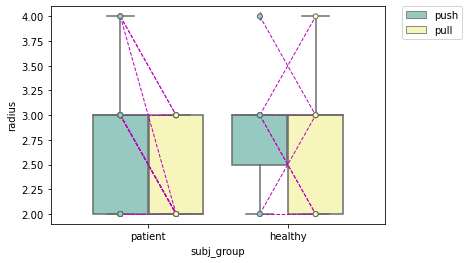

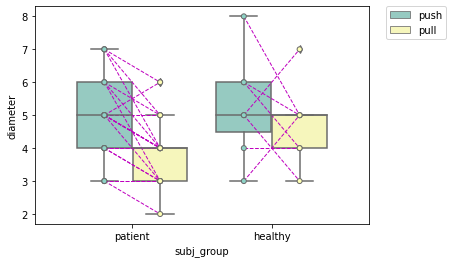

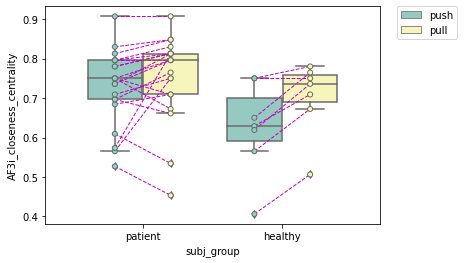

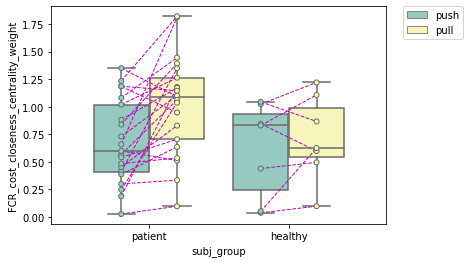

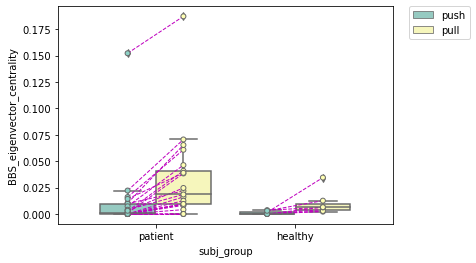

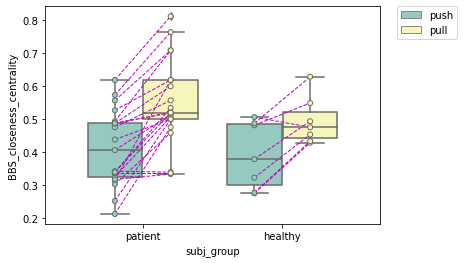

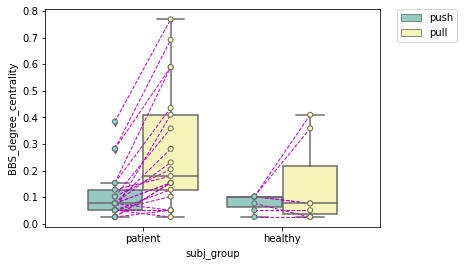

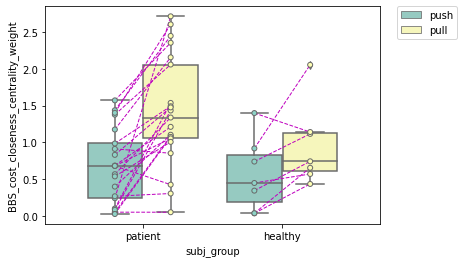

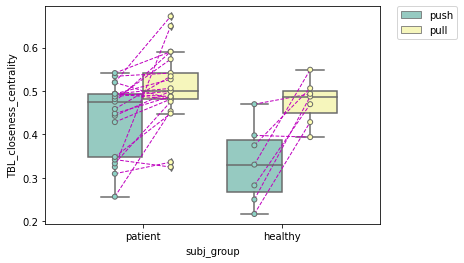

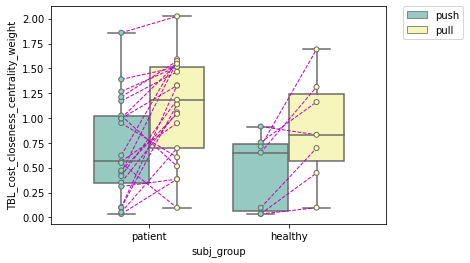

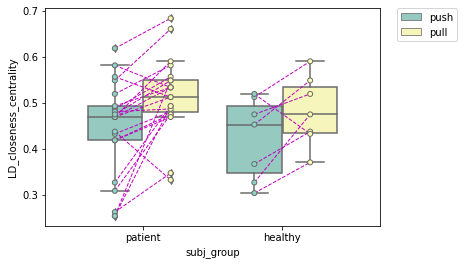

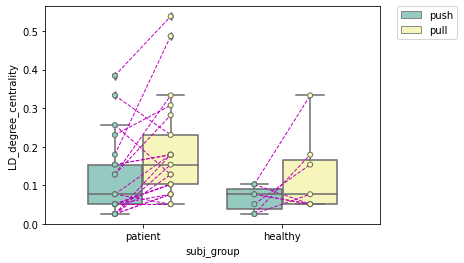

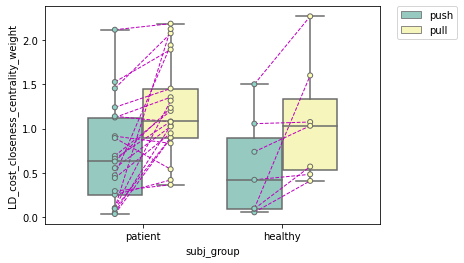

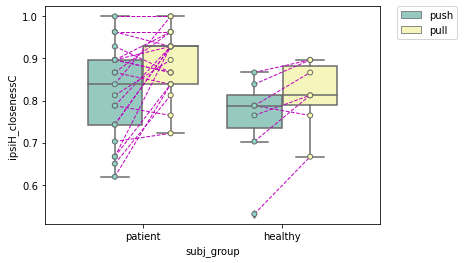

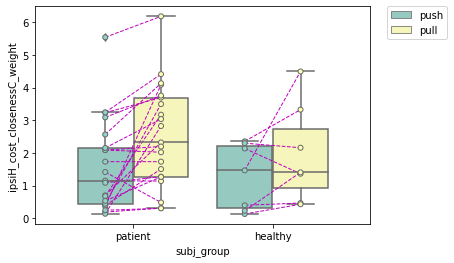

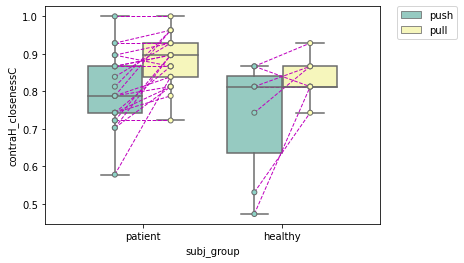

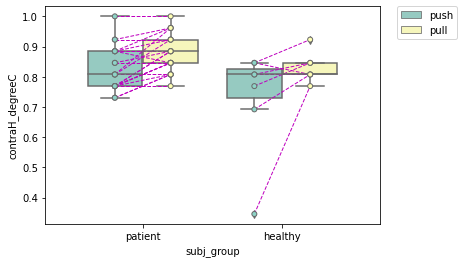

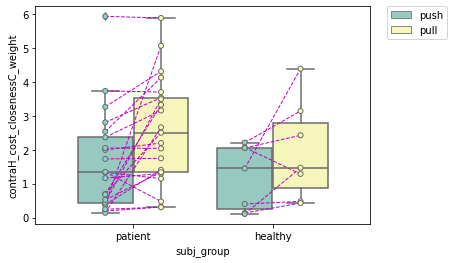

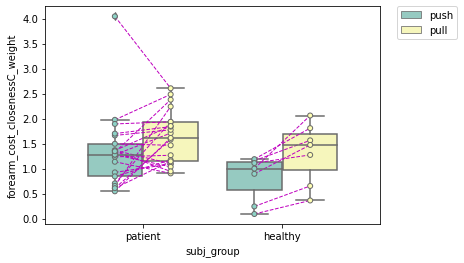

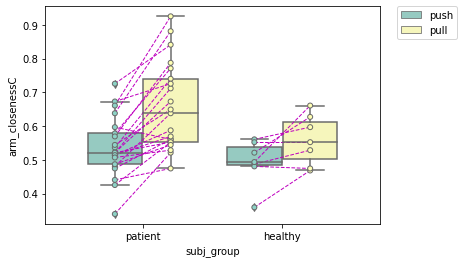

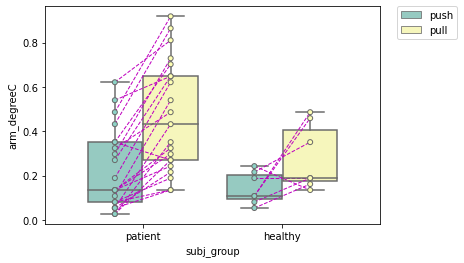

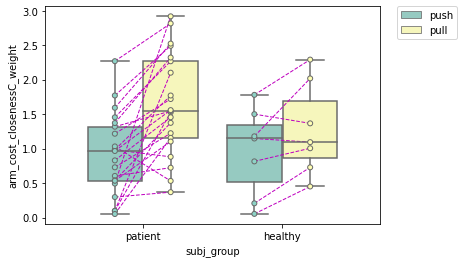

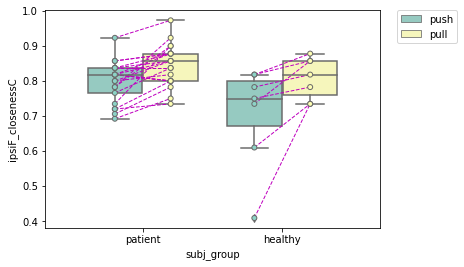

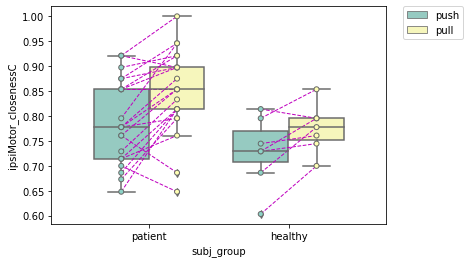

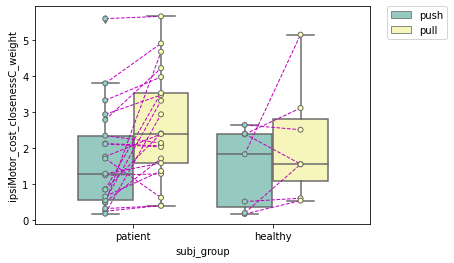

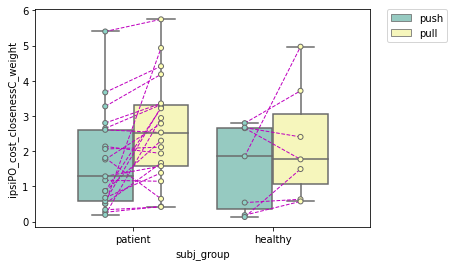

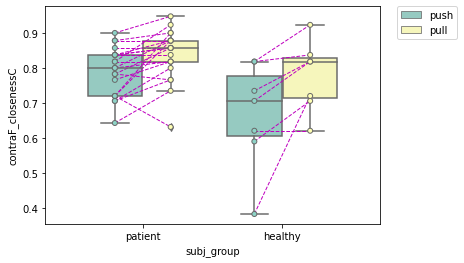

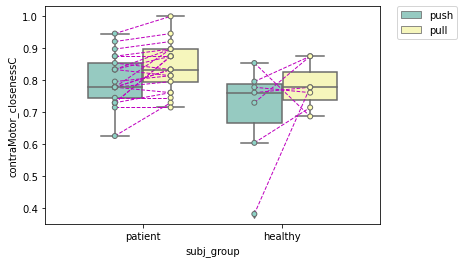

In [18]:
from bioinfokit.analys import stat
import pingouin as pg
bof_factor_ttest=2
plt.rcParams.update({'figure.max_open_warning': 0})
pd.set_option('display.expand_frame_repr', False)
gProperties= ['radius','diameter', 'density', 's_metric', 'transitivity', 'local_efficiency', 'global_efficiency',
                   'sw_omega', 'node_connectivity_wholeG','average_shortestPathLength_weight',
                   'wiener_idx', 'size','size_weight','assortativityCoefficient', 'assortativityCoefficient_weight',
                   'cost_size_weight','cost_average_shortestP_length_weight',
                   'mean_clusteringC', 'g_cliqueNumber', 'g_numberOfMaxClique','non_randomness','relative_nonRandomness',
                   'wiener_idx_minST_weight', 'wiener_idx_maxST_weight','size_minST_weight','size_maxST_weight']
gProperties_local = ['eigenvector_centrality','closeness_centrality','degree_centrality','betweenness_centrality',
#                      'closeness_vitality',
#                      'ecc_weight','clusteringC_weight','cost_eigenvector_centrality_weight','closeness_centrality_weight','cost_closeness_vitality_weight'
                     'cost_betweenness_centrality_weight',
                     'cost_closeness_centrality_weight']
 
groups = ['ipsiH','contraH','forearm','arm','ipsiF','ipsiMotor','ipsiPO','mesial','contraF','contraMotor','contraPO']
gProperties_group = ['betweennessC','closenessC','degreeC','cost_betweennessC_weight','cost_closenessC_weight']

for ch in chs_list_image:
    gProperties+=[ch+'_'+gProperty_local for gProperty_local in gProperties_local]
for group in groups:
    gProperties+=[group+'_'+gProperty_group for gProperty_group in gProperties_group]

alpha=.01
# bof_factor = 1
gProperties_sigInt = []
gProperties_sigSubj = []
gProperties_sigContt = []
gProperties_push_patient_healthy = {}
gProperties_pull_patient_healthy = {}
gProperties_patient_pull_push = {}
gProperties_healthy_pull_push = {}

res = stat()
for gProperty in gProperties:
    res_var = gProperty
    df[gProperties] = df[gProperties].astype(float)
    aov = pg.mixed_anova(dv=res_var, within='contraction_group', between='subj_group', subject='subj_id', data=df)
    if aov['p-unc'].tolist()[2] < alpha: #interaction effect
        gProperties_sigInt.append(res_var)
        ### Tukey HSD
#         hsd_push = pg.pairwise_tukey(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
#         hsd_pull = pg.pairwise_tukey(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
#         hsd_push['p-tukey'] = hsd_push['p-tukey']*bof_factor
#         hsd_pull['p-tukey'] = hsd_pull['p-tukey']*bof_factor
        gsw_push = pg.pairwise_gameshowell(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
        gsw_pull = pg.pairwise_gameshowell(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
    
        ttest_contraction_healthy = pg.pairwise_ttests(dv=res_var, within = 'contraction_group',subject='subj_id', data=df.query('subj_group=="healthy"'), 
                                                       padjust='bonf').round(3)
        ttest_contraction_patient = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', subject='subj_id',data=df.query('subj_group=="patient"')).round(3)
        ttest_contraction_healthy['p-unc'] =   ttest_contraction_healthy['p-unc'] *bof_factor_ttest
        ttest_contraction_patient['p-unc'] =   ttest_contraction_patient['p-unc'] *bof_factor_ttest
        if gsw_push['pval'][0]<alpha:
            gProperties_push_patient_healthy[res_var] = -gsw_push['hedges'][0]
        if gsw_pull['pval'][0]<alpha:
            gProperties_pull_patient_healthy[res_var] = -gsw_pull['hedges'][0]
        if ttest_contraction_healthy['p-unc'][0]<alpha:
            gProperties_healthy_pull_push[res_var] = ttest_contraction_healthy['hedges'][0]
        if ttest_contraction_patient['p-unc'][0]<alpha:
            gProperties_patient_pull_push[res_var] = ttest_contraction_patient['hedges'][0]
        if (gsw_push['pval']<alpha).any() or (gsw_pull['pval']<alpha).any() or (ttest_contraction_healthy['p-unc']<alpha).any() or \
        (ttest_contraction_patient['p-unc']<alpha).any():
            print('intE: ' + bold_color.BOLD+res_var+bold_color.END)
            print('Normality - push: {0}, Normality - pull: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                           group='contraction_group').loc['push','normal'],
                  pg.normality(data=df,dv=res_var,group='contraction_group').loc['pull','normal']))
            print('Normality - healthy: {0}, Normality - patients: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                                            group='subj_group').loc['healthy','normal'],
                                                                                               pg.normality(data=df,dv=res_var,
                                                                                                            group='subj_group').loc['patient','normal']))
            # HOMOGENEITY FOR BETWEEN SUBJECT VAR
            print('Homogeneity - subj_group: {}'.format( pg.homoscedasticity(data=df,dv=res_var,
                                                                                                group='subj_group')['equal_var'].values[0]))
            # Sphericity is met, we use normality check to cover outlier test

            pg.print_table(aov,floatfmt='.4f')
            print('push: posthoc on group')
            pg.print_table(gsw_push,floatfmt='.4f')
            print('\n')
            print('pull: posthoc on group')
            pg.print_table(gsw_pull,floatfmt='.4f')
            print('\n')
            print('healthy: pull vs (-) push (paired ttest)')
            pg.print_table(ttest_contraction_healthy,floatfmt='.4f')
            print('\n')
            print('patient: pull vs (-) push (paired ttest)')
            pg.print_table(ttest_contraction_patient,floatfmt='.4f')

            plt.figure()
            ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3") 

            stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
            handles, labels = stplot.get_legend_handles_labels()
            l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            for i in range(2):
                plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
                         [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
                         linewidth=1,c='m')

            fig = ax.get_figure()
            fig.savefig(os.path.join(iVC_results_dir,res_var+'_mANOVA_bp.eps'))
            continue

    elif aov['p-unc'].tolist()[0] < alpha: #main group effect
        gProperties_sigSubj.append(res_var)
        ### Tukey HSD
#         hsd_push = pg.pairwise_tukey(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
#         hsd_pull = pg.pairwise_tukey(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
#         hsd_push['p-tukey'] = hsd_push['p-tukey']*bof_factor
#         hsd_pull['p-tukey'] = hsd_pull['p-tukey']*bof_factor
        gsw_push = pg.pairwise_gameshowell(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
        gsw_pull = pg.pairwise_gameshowell(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
#         if (hsd_push['p-tukey'][0]<alpha) & (res_var not in gProperties_push_patient_healthy.keys()):
#             gProperties_push_patient_healthy[res_var] = -hsd_push['hedges'][0]
#         if (hsd_pull['p-tukey'][0]<alpha) & (res_var not in gProperties_pull_patient_healthy.keys()):
#             gProperties_pull_patient_healthy[res_var] = -hsd_pull['hedges'][0]
        if gsw_push['pval'][0]<alpha:
            gProperties_push_patient_healthy[res_var] = -gsw_push['hedges'][0]
        if gsw_pull['pval'][0]<alpha:
            gProperties_pull_patient_healthy[res_var] = -gsw_pull['hedges'][0]
        if (gsw_push['pval']<alpha).any() or (gsw_pull['pval']<alpha).any() :
            print('groupE: '+bold_color.BOLD+res_var+bold_color.END)
            print('Normality - push: {0}, Normality - pull: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                           group='contraction_group').loc['push','normal'],
                  pg.normality(data=df,dv=res_var,group='contraction_group').loc['pull','normal']))
            print('Normality - healthy: {0}, Normality - patients: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                                            group='subj_group').loc['healthy','normal'],
                                                                                               pg.normality(data=df,dv=res_var,
                                                                                                            group='subj_group').loc['patient','normal']))
            # HOMOGENEITY FOR BETWEEN SUBJECT VAR
            print('Homogeneity - subj_group: {}'.format(pg.homoscedasticity(data=df,dv=res_var,
                                                                                                group='subj_group')['equal_var'].values[0]))
            # Sphericity is met, we use normality check to cover outlier test

            pg.print_table(aov,floatfmt='.4f')
            print('push: posthoc on group')
            pg.print_table(gsw_push,floatfmt='.4f')
            print('\n')
            print('pull: posthoc on group')
            pg.print_table(gsw_pull,floatfmt='.4f')

            plt.figure()
            ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3") 

            stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
            handles, labels = stplot.get_legend_handles_labels()
            l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            for i in range(3):
                plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
                         [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
                         linewidth=1,c='m')

            fig = ax.get_figure()
            fig.savefig(os.path.join(iVC_results_dir,res_var+'_mANOVA_bp.eps'))
            continue

    elif aov['p-unc'].tolist()[1] < alpha: #main contraction effect
        gProperties_sigContt.append(res_var)
        ### paired t-test
        ttest_contraction_healthy = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', 
                                                    subject='subj_id', data=df.query('subj_group=="healthy"')).round(3)
        ttest_contraction_patient = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', 
                                                    subject='subj_id', data=df.query('subj_group=="patient"')).round(3)
        ttest_contraction_healthy['p-unc'] =   ttest_contraction_healthy['p-unc'] *bof_factor_ttest
        ttest_contraction_patient['p-unc'] =   ttest_contraction_patient['p-unc'] *bof_factor_ttest
        if (ttest_contraction_healthy['p-unc'][0]<alpha) & (res_var not in gProperties_healthy_pull_push.keys()):
            gProperties_healthy_pull_push[res_var] = ttest_contraction_healthy['hedges'][0]
        if (ttest_contraction_patient['p-unc'][0]<alpha) & (res_var not in gProperties_patient_pull_push.keys()):
            gProperties_patient_pull_push[res_var] = ttest_contraction_patient['hedges'][0]

        if (ttest_contraction_healthy['p-unc']<alpha).any() or (ttest_contraction_patient['p-unc']<alpha).any():
            print('conttE: '+bold_color.BOLD+res_var+bold_color.END)
            print('Normality - push: {0}, Normality - pull: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                           group='contraction_group').loc['push','normal'],
                  pg.normality(data=df,dv=res_var,group='contraction_group').loc['pull','normal']))
            print('Normality - healthy: {0}, Normality - patients: {1}'.format(pg.normality(data=df,dv=res_var,
                                                                                                            group='subj_group').loc['healthy','normal'],
                                                                                               pg.normality(data=df,dv=res_var,
                                                                                                            group='subj_group').loc['patient','normal']))
            # HOMOGENEITY FOR BETWEEN SUBJECT VAR
            print('Homogeneity - subj_group: {}'.format(pg.homoscedasticity(data=df,dv=res_var,
                                                                                                group='subj_group')['equal_var'].values[0]))
            # Sphericity is met, we use normality check to cover outlier test

            pg.print_table(aov)
            print('\n')
            print('healthy: pull vs (-) push (paired ttest)')
            pg.print_table(ttest_contraction_healthy,floatfmt='.4f')
            print('\n')
            print('patient: pull vs (-) push (paired ttest)')
            pg.print_table(ttest_contraction_patient,floatfmt='.4f')

            plt.figure()
            ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3") 

            stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
            handles, labels = stplot.get_legend_handles_labels()
            l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            for i in range(3):
                plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
                         [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
                         linewidth=1,c='m')

            fig = ax.get_figure()
            fig.savefig(os.path.join(iVC_results_dir,res_var+'_mANOVA_bp.eps'))




## Section 4-5: reg-push on gProperties - 

size_weight
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.237
Method:                 Least Squares   F-statistic:                     7.220
Date:                Mon, 17 May 2021   Prob (F-statistic):             0.0146
Time:                        11:23:27   Log-Likelihood:                -80.236
No. Observations:                  21   AIC:                             164.5
Df Residuals:                      19   BIC:                             166.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.3069      5.801      8.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

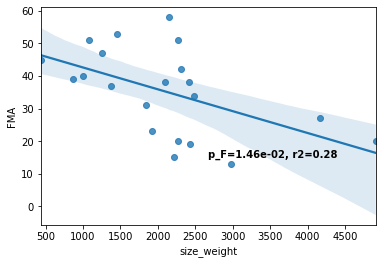

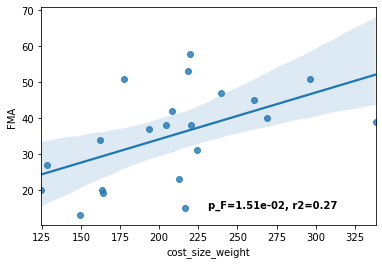

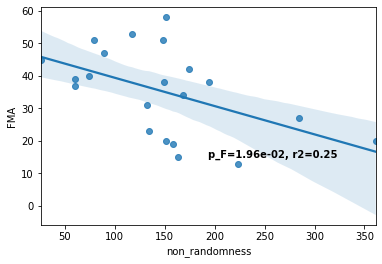

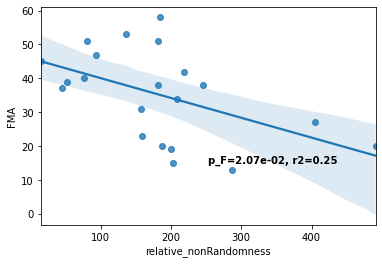

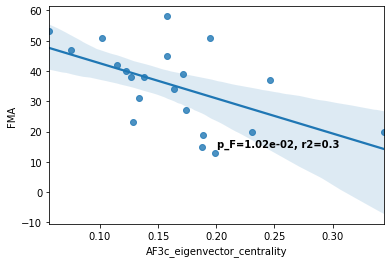

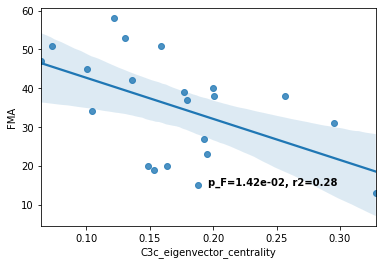

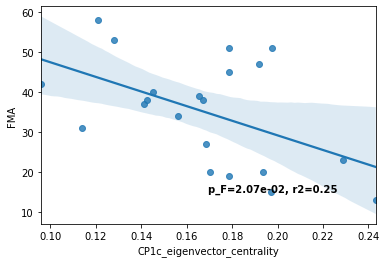

In [106]:
import scipy
from numpy import mean
from numpy import var
from math import sqrt
import statsmodels.api as sm
alpha = 5e-2
r2_threshold = 0.25

related_gProperties=[]
model_stats = []
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'FMA'].to_numpy().astype(np.float)

gProperties= ['radius','diameter', 'density', 's_metric', 'transitivity', 'local_efficiency', 'global_efficiency',
                   'sw_omega', 'node_connectivity_wholeG','average_shortestPathLength_weight',
                   'wiener_idx', 'size','size_weight','assortativityCoefficient',
                   'cost_size_weight','cost_average_shortestP_length_weight',
                   'mean_clusteringC', 'g_cliqueNumber', 'g_numberOfMaxClique','non_randomness','relative_nonRandomness',
                   'wiener_idx_minST_weight', 'wiener_idx_maxST_weight','size_minST_weight','size_maxST_weight']
gProperties_local = ['eigenvector_centrality','closeness_centrality','degree_centrality','betweenness_centrality',
#                      'closeness_vitality',
#                      'ecc_weight','clusteringC_weight','cost_eigenvector_centrality_weight','closeness_centrality_weight','cost_closeness_vitality_weight'
                     'cost_betweenness_centrality_weight',
                     'cost_closeness_centrality_weight']
 
groups = ['ipsiH','contraH','forearm','arm','ipsiF','ipsiMotor','ipsiPO','mesial','contraF','contraMotor','contraPO']
gProperties_group = ['betweennessC','closenessC','degreeC','cost_betweennessC_weight','cost_closenessC_weight']

for ch in chs_list_image:
    gProperties+=[ch+'_'+gProperty_local for gProperty_local in gProperties_local]
for group in groups:
    gProperties+=[group+'_'+gProperty_group for gProperty_group in gProperties_group]


for gProperty in gProperties:
    gProperty_patient_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),gProperty].to_numpy().astype(np.float)
    gProperty_patient_push = sm.add_constant(gProperty_patient_push)
    model = sm.OLS(FMAs,gProperty_patient_push).fit()
    if (model.f_pvalue<alpha) & (model.rsquared>r2_threshold):
        print(gProperty)
        print(model.summary())
        related_gProperties.append(gProperty)
#             model_stats.append([round(model.f_pvalue,2),round(model.rsquared_adj,2)])
        model_stats.append(["{:.2e}".format(model.f_pvalue),round(model.rsquared,2)])

#visualization
import seaborn as sns

for i in range(len(related_gProperties)):
    gProperty_patient_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),related_gProperties[i]].to_numpy().astype(np.float)

    plt.figure()
    ax = sns.regplot(x=gProperty_patient_push, y=FMAs)
    ax.set(xlabel=related_gProperties[i], ylabel='FMA')
#     ax.set_xlim(-0.05,0.35)
    plt.text((ax.get_xlim()[0]+ax.get_xlim()[-1])/2, 15, "p_F="+str(model_stats[i][0])+", r2="+str(model_stats[i][1]), horizontalalignment='left', 
             size='medium', color='black', weight='semibold')
    regPlot_fName = os.path.join(global_results_dir,'iVC',related_gProperties[i]+'push_FMAreg.eps')
    figure = ax.get_figure()
    figure.savefig(regPlot_fName)


## Section 4-6 reg-pull on gProperties

Fp1i_cost_closeness_centrality_weight
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.298
Method:                 Least Squares   F-statistic:                     9.487
Date:                Mon, 17 May 2021   Prob (F-statistic):            0.00616
Time:                        11:43:33   Log-Likelihood:                -79.366
No. Observations:                  21   AIC:                             162.7
Df Residuals:                      19   BIC:                             164.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.



ipsiF_cost_closenessC_weight
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     8.752
Date:                Mon, 17 May 2021   Prob (F-statistic):            0.00807
Time:                        11:43:33   Log-Likelihood:                -79.640
No. Observations:                  21   AIC:                             163.3
Df Residuals:                      19   BIC:                             165.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.9981 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

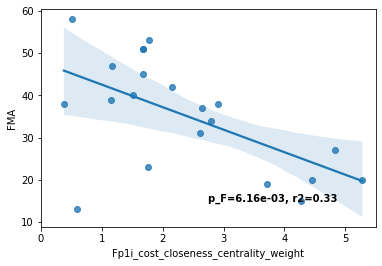

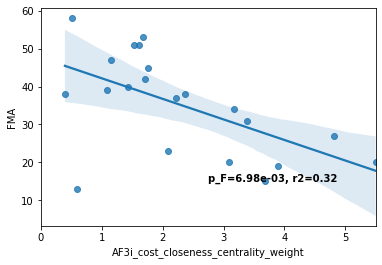

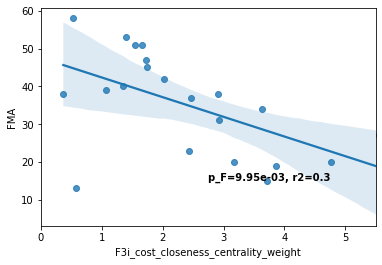

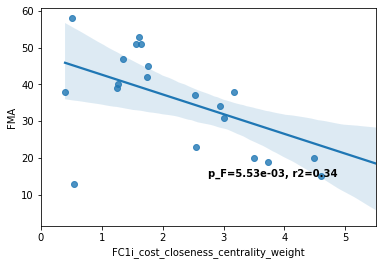

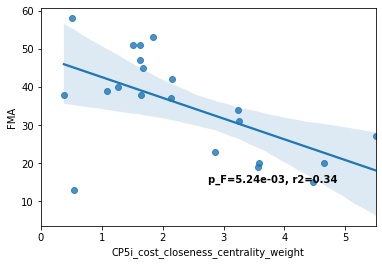

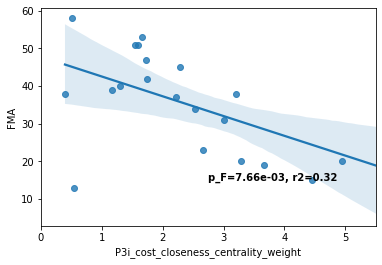

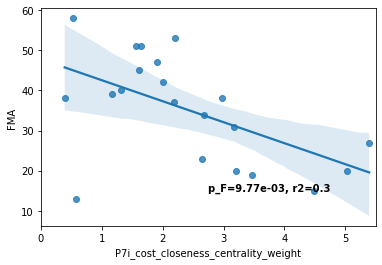

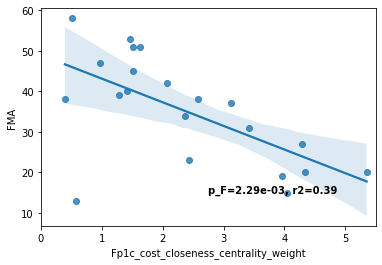

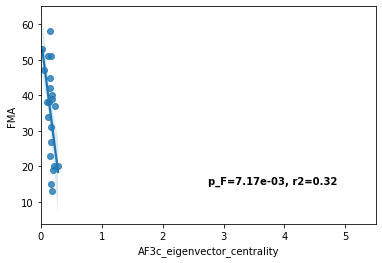

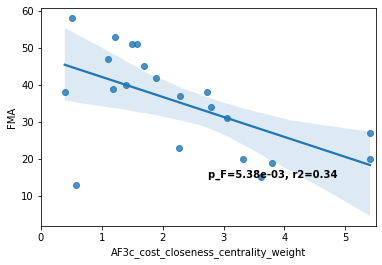

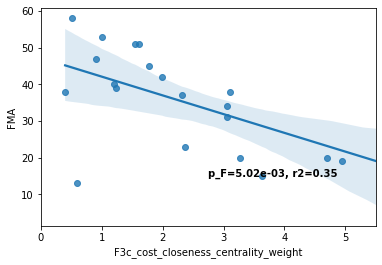

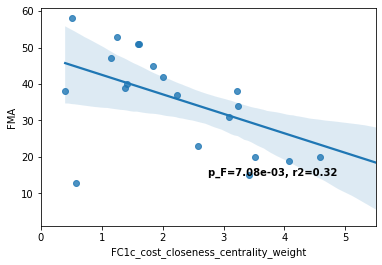

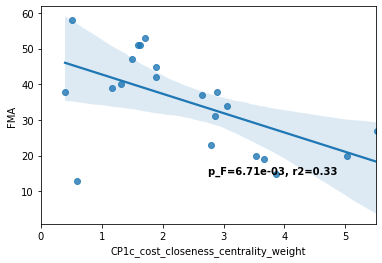

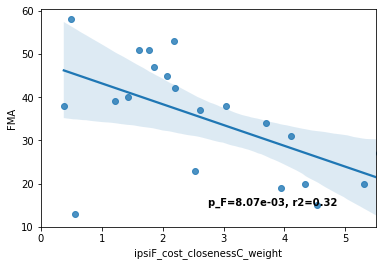

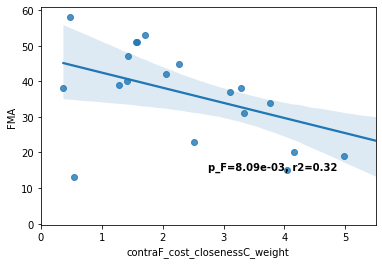

In [110]:
import scipy
from numpy import mean
from numpy import var
from math import sqrt
import statsmodels.api as sm
alpha = 1e-2
r2_threshold = 0.01

related_gProperties=[]
model_stats = []
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)
gProperties= ['radius','diameter', 'density', 's_metric', 'transitivity', 'local_efficiency', 'global_efficiency',
                   'sw_omega', 'node_connectivity_wholeG','average_shortestPathLength_weight',
                   'wiener_idx', 'size','size_weight','assortativityCoefficient',
                   'cost_size_weight','cost_average_shortestP_length_weight',
                   'mean_clusteringC', 'g_cliqueNumber', 'g_numberOfMaxClique','non_randomness','relative_nonRandomness',
                   'wiener_idx_minST_weight', 'wiener_idx_maxST_weight','size_minST_weight','size_maxST_weight']
gProperties_local = ['eigenvector_centrality','closeness_centrality','degree_centrality','betweenness_centrality',
#                      'closeness_vitality',
#                      'ecc_weight','clusteringC_weight','cost_eigenvector_centrality_weight','closeness_centrality_weight','cost_closeness_vitality_weight'
                     'cost_betweenness_centrality_weight',
                     'cost_closeness_centrality_weight']
 
groups = ['ipsiH','contraH','forearm','arm','ipsiF','ipsiMotor','ipsiPO','mesial','contraF','contraMotor','contraPO']
gProperties_group = ['betweennessC','betweennessC_weight','closenessC','closenessC_weight','degreeC','cost_betweennessC_weight','cost_closenessC_weight']

for ch in chs_list_image:
    gProperties+=[ch+'_'+gProperty_local for gProperty_local in gProperties_local]
for group in groups:
    gProperties+=[group+'_'+gProperty_group for gProperty_group in gProperties_group]
    
for gProperty in gProperties:
    gProperty_patient_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),gProperty].to_numpy().astype(np.float)
    gProperty_patient_pull = sm.add_constant(gProperty_patient_pull)
    model = sm.OLS(FMAs,gProperty_patient_pull).fit()
    if (model.f_pvalue<alpha) & (model.rsquared>r2_threshold):
        print(gProperty)
        print(model.summary())
        related_gProperties.append(gProperty)
#             model_stats.append([round(model.f_pvalue,2),round(model.rsquared_adj,2)])
        model_stats.append(["{:.2e}".format(model.f_pvalue),round(model.rsquared,2)])

#visualization
import seaborn as sns

for i in range(len(related_gProperties)):
    gProperty_patient_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),related_gProperties[i]].to_numpy().astype(np.float)

    plt.figure()
    ax = sns.regplot(x=gProperty_patient_pull, y=FMAs)
    ax.set(xlabel=related_gProperties[i], ylabel='FMA')
    ax.set_xlim([0,5.5])
    plt.text((ax.get_xlim()[0]+ax.get_xlim()[-1])/2, 15, "p_F="+str(model_stats[i][0])+", r2="+str(model_stats[i][1]), horizontalalignment='left', 
             size='medium', color='black', weight='semibold')
    regPlot_fName = os.path.join(global_results_dir,'iVC',related_gProperties[i]+'pull_FMAreg.eps')
    figure = ax.get_figure()
    figure.savefig(regPlot_fName)


## Section 4-7: integreal reg

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     12.44
Date:                Mon, 17 May 2021   Prob (F-statistic):           6.76e-05
Time:                        11:53:20   Log-Likelihood:                -66.416
No. Observations:                  21   AIC:                             144.8
Df Residuals:                      15   BIC:                             151.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         51.4390      3.396     15.146      0.0

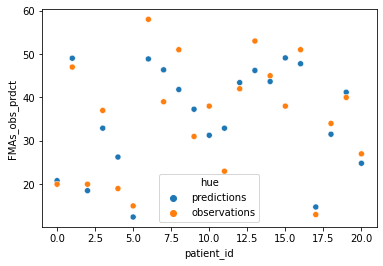

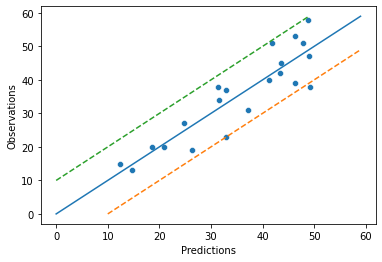

In [111]:
# integral model
push_X_names=['SPMI_F3c_C3c','SPMI_F3c_CP1c','SPMI_FC5i_BBS'] #include SPMIs
#,'C3c_closeness_centrality','C3c_closeness_vitality_weight','emg3_cost_betweenness_centrality'
pull_X_names=['SPMI_C3i_Fp1c','Fp1c_cost_closeness_centrality_weight']
# ,'CP5i_cost_closeness_centrality_weight','P3i_cost_closeness_centrality_weight',
#  'Fp1c_cost_closeness_centrality_weight', 'AF3c_cost_closeness_centrality_weight','F3c_cost_closeness_centrality_weight',
#  'FC1c_cost_closeness_centrality_weight','CP1c_cost_closeness_centrality_weight','contraF_cost_closenessC_weight'
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)
X=[]
for name in push_X_names:
    X.append(df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),name].to_numpy().astype(np.float))
for name in pull_X_names:
    X.append(df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),name].to_numpy().astype(np.float))

X=np.array(X)
X=np.swapaxes(X,0,1)
X=sm.add_constant(X)
model = sm.OLS(FMAs,X).fit()
predictions = model.predict(X)
print(model.summary())
print('\n')
print(predictions)
print(FMAs)

patient_id = np.arange(len(predictions))
patient_id = np.hstack([patient_id,patient_id])
FMAs_obs_prdct = np.hstack([predictions,FMAs])
hue =np.hstack([['predictions']*len(predictions),['observations']*len(FMAs)])
data_intReg = {'patient_id':patient_id,'FMAs_obs_prdct':FMAs_obs_prdct,'hue':hue}
df_intReg = pd.DataFrame(data_intReg)
# df_intReg
sns.scatterplot(x='patient_id',y='FMAs_obs_prdct',hue='hue',data=df_intReg)
plt.figure()
sns.scatterplot(x=predictions,y=FMAs)
ax = sns.lineplot(x=np.arange(60),y=np.arange(60))
ax = sns.lineplot(x=np.arange(10,60),y=np.arange(0,50))
ax = sns.lineplot(x=np.arange(0,50),y=np.arange(10,60))
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.xlabel("Predictions") #x label
plt.ylabel("Observations") 
plt.savefig(os.path.join(iVC_results_dir,'gP_reg_performance.eps') )

## Section 4-7*: integral reg - PCA

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     13.97
Date:                Fri, 16 Apr 2021   Prob (F-statistic):           4.35e-05
Time:                        19:52:09   Log-Likelihood:                -67.603
No. Observations:                  21   AIC:                             145.2
Df Residuals:                      16   BIC:                             150.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.6190      1.513     23.546      0.0

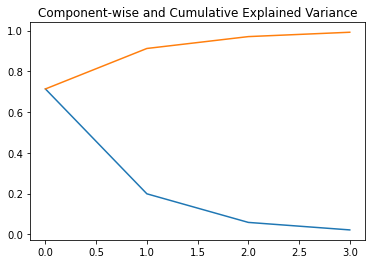

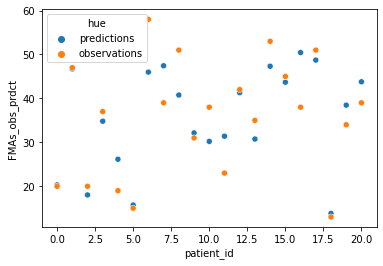

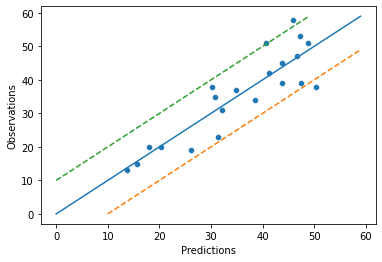

In [74]:
from sklearn.decomposition import PCA
push_X_names=['SPMI_F3c_C3c','SPMI_F3c_CP1c'] #include SPMIs
#,'C3c_closeness_centrality','C3c_closeness_vitality_weight','emg3_cost_betweenness_centrality'
pull_X_names=['SPMI_C3i_Fp1c','Fp1i_cost_closeness_centrality_weight','CP5i_cost_closeness_centrality_weight','P3i_cost_closeness_centrality_weight',
 'Fp1c_cost_closeness_centrality_weight', 'AF3c_cost_closeness_centrality_weight','F3c_cost_closeness_centrality_weight',
 'FC1c_cost_closeness_centrality_weight','CP1c_cost_closeness_centrality_weight','contraF_cost_closenessC_weight']
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)
X=[]
for name in push_X_names:
    X.append(df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),name].to_numpy().astype(np.float))
for name in pull_X_names:
    X.append(df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),name].to_numpy().astype(np.float))
X=np.array(X)
X=np.swapaxes(X,0,1)
pca = PCA(n_components=4)
pca_result = pca.fit_transform(X)
plt.plot(range(4), pca.explained_variance_ratio_)
plt.plot(range(4), np.cumsum(pca.explained_variance_ratio_))
plt.title("Component-wise and Cumulative Explained Variance")
plt.savefig('')
X=sm.add_constant(pca_result)
model = sm.OLS(FMAs,X).fit()
predictions = model.predict(X)
print(model.summary())
print('\n')
print(predictions)
print(FMAs)

patient_id = np.arange(len(predictions))
patient_id = np.hstack([patient_id,patient_id])
FMAs_obs_prdct = np.hstack([predictions,FMAs])
hue =np.hstack([['predictions']*len(predictions),['observations']*len(FMAs)])
data_intReg = {'patient_id':patient_id,'FMAs_obs_prdct':FMAs_obs_prdct,'hue':hue}
df_intReg = pd.DataFrame(data_intReg)
# df_intReg
plt.figure()
sns.scatterplot(x='patient_id',y='FMAs_obs_prdct',hue='hue',data=df_intReg)
plt.figure()
sns.scatterplot(x=predictions,y=FMAs)
ax = sns.lineplot(x=np.arange(60),y=np.arange(60))
ax = sns.lineplot(x=np.arange(10,60),y=np.arange(0,50))
ax = sns.lineplot(x=np.arange(0,50),y=np.arange(10,60))
ax.lines[1].set_linestyle("--")
ax.lines[2].set_linestyle("--")
plt.xlabel("Predictions") #x label
plt.ylabel("Observations") 
plt.savefig(os.path.join(iVC_results_dir,'gP_reg_performance.eps') )

## Section 4-8 clustering analyses

In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bioinfokit.visuz import cluster
push_X_names=['SPMI_F3c_C3c','SPMI_F3c_CP1c','contraMotor_betweennessC_weight'] #include SPMIs
#,'C3c_closeness_centrality','C3c_closeness_vitality_weight','emg3_cost_betweenness_centrality','SPMI_F3c_CP1c'
pull_X_names=['contraF_cost_closenessC_weight']
# 'Fp1c_cost_closeness_centrality_weight', 'AF3c_cost_closeness_centrality_weight','F3c_cost_closeness_centrality_weight','CP5i_cost_closeness_centrality_weight',
# 'FC1c_cost_closeness_centrality_weight','CP1c_cost_closeness_centrality_weight','contraF_cost_closenessC_weight'，'Fp1i_cost_closeness_centrality_weight',
# ','P3i_cost_closeness_centrality_weight'
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)

    
X_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),push_X_names].to_numpy().astype(np.float)
X_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),pull_X_names].to_numpy().astype(np.float)
X=np.hstack([X_push,X_pull])
# X = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),push_X_names].to_numpy().astype(np.float)
target = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'bs_UE'].to_numpy()
X_st =  StandardScaler().fit_transform(X)
pca_out = PCA().fit(X_st)
loadings = pca_out.components_
# get biplot
pca_scores = PCA().fit_transform(X_st)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=np.array(push_X_names+pull_X_names), var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2),colorlist = target)


## Section 4-8* exploration (do not run until necessary)

In [87]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from bioinfokit.visuz import cluster
push_X_names=['SPMI_F3c_C3c','C3c_closeness_centrality','emg3_cost_betweenness_centrality'] #include SPMIs
pull_X_names=['Fp1i_cost_closeness_centrality','Pz_eigenvector_centrality']
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),'FMA'].to_numpy().astype(np.float)

    
X = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),push_X_names+pull_X_names].to_numpy().astype(np.float)
# X = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),push_X_names].to_numpy().astype(np.float)
target = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'bs_UE'].to_numpy()
X_st =  StandardScaler().fit_transform(X)
pca_out = PCA().fit(X_st)
loadings = pca_out.components_
# get biplot
pca_scores = PCA().fit_transform(X_st)
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=np.array(push_X_names+pull_X_names), var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
               var2=round(pca_out.explained_variance_ratio_[1]*100, 2),colorlist = target)
# cluster.biplot(cscore=pca_scores, loadings=loadings, labels=np.array(push_X_names), var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
#                var2=round(pca_out.explained_variance_ratio_[1]*100, 2),colorlist = target)


## Optional: ANOVA result, bp, profile plot and scatter plot for a response variable
2 implement: set statistics add regression


ANOVA SUMMARY

Source                     SS    DF1    DF2          MS      F    p-unc    np2      eps
-----------------  ----------  -----  -----  ----------  -----  -------  -----  -------
subj_group         982456.999      1     26  982456.999  0.417    0.524  0.016  nan
contraction_group      44.416      1     26      44.416  0.000    0.983  0.000    1.000
Interaction        146803.373      1     26  146803.373  1.466    0.237  0.053  nan

push: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)      diff       se       T     df    pval    hedges
-------  -------  ---------  ---------  --------  -------  ------  -----  ------  --------
healthy  patient   1904.420   2092.066  -187.645  482.406  -0.389  9.669   0.718    -0.165



pull: posthoc on group

POST HOC TESTS

A        B          mean(A)    mean(B)      diff       se       T      df    pval    hedges
-------  -------  ---------  ---------  --------  -------  ------  ------  ------  --------
healthy  pa

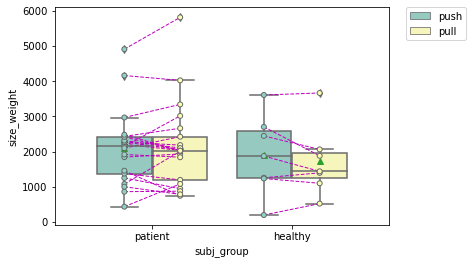

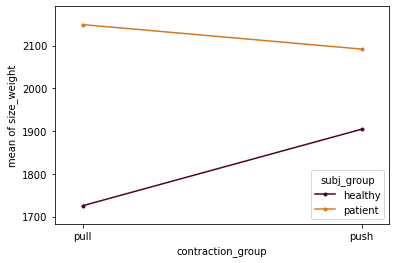

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     3.501
Date:                Thu, 10 Jun 2021   Prob (F-statistic):             0.0520
Time:                        13:20:38   Log-Likelihood:                -80.168
No. Observations:                  21   AIC:                             166.3
Df Residuals:                      18   BIC:                             169.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.4488      5.955      8.304      0.0

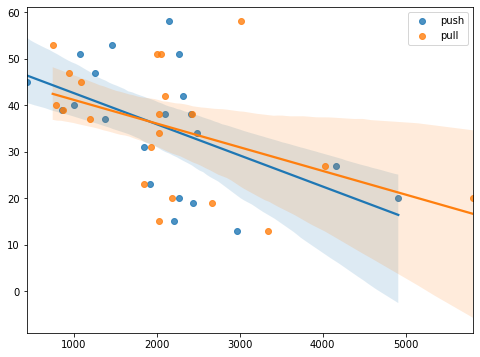

In [21]:
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
from bioinfokit.analys import stat
import pingouin as pg
res = stat()
bof_factor_ttest=2
res_var = 'size_weight'
#average_shortestPathLength_weight
# res.anova_stat(df=df, res_var=res_var, anova_model=res_var+' ~ C(contraction_group)*C(subj_group)',ss_typ=3)
# print(res.anova_summary)
# res.tukey_hsd(df=df, res_var=res_var, xfac_var=['contraction_group','subj_group'], 
#                   anova_model=res_var+' ~ C(contraction_group)*C(subj_group)')
# print(res.tukey_summary)
aov = pg.mixed_anova(dv=res_var, within='contraction_group', between='subj_group', subject='subj_id', data=df)
# hsd_push = pg.pairwise_tukey(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
# hsd_pull = pg.pairwise_tukey(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
# hsd_push['p-tukey'] = hsd_push['p-tukey']*bof_factor
# hsd_pull['p-tukey'] = hsd_pull['p-tukey']*bof_factor
gsw_push = pg.pairwise_gameshowell(data=df.query('contraction_group=="push"'),dv=res_var,between = 'subj_group')
gsw_pull = pg.pairwise_gameshowell(data=df.query('contraction_group=="pull"'),dv=res_var,between = 'subj_group')
ttest_contraction_healthy = pg.pairwise_ttests(dv=res_var, within = 'contraction_group',subject='subj_id', data=df.query('subj_group=="healthy"'), 
                                               padjust='bonf').round(3)
ttest_contraction_patient = pg.pairwise_ttests(dv=res_var, within = 'contraction_group', subject='subj_id',data=df.query('subj_group=="patient"')).round(3)
ttest_contraction_healthy['p-unc'] =   ttest_contraction_healthy['p-unc'] * bof_factor_ttest
ttest_contraction_patient['p-unc'] =   ttest_contraction_patient['p-unc'] * bof_factor_ttest
pg.print_table(aov)
print('push: posthoc on group')
pg.print_table(gsw_push)
print('\n')
print('pull: posthoc on group')
pg.print_table(gsw_pull)
print('\n')
print('healthy: pull vs (-) push (paired ttest)')
pg.print_table(ttest_contraction_healthy)
print('\n')
print('patient: pull vs (-) push (paired ttest)')
pg.print_table(ttest_contraction_patient)

plt.figure()
ax = sns.boxplot(x="subj_group", y=res_var, hue="contraction_group", data=df, palette="Set3",showmeans=True) 

stplot = sns.stripplot(x="subj_group", y=res_var, hue="contraction_group", data=df,palette="Set3",linewidth=1,dodge=True,jitter=False)
handles, labels = stplot.get_legend_handles_labels()
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
for i in range(2):
    plt.plot([stplot.collections[2*i].get_offsets().data[:,0].tolist(),stplot.collections[2*i+1].get_offsets().data[:,0].tolist()],
             [stplot.collections[2*i].get_offsets().data[:,1].tolist(),stplot.collections[2*i+1].get_offsets().data[:,1].tolist()],'--',
             linewidth=1,c='m')



# plt.plot([ax.get_children()[2].get_xdata()[0],ax.get_children()[16].get_xdata()[0]],
#          [ax.get_children()[7].get_ydata()[0],ax.get_children()[21].get_ydata()[0]],'--')
# plt.plot([ax.get_children()[10].get_xdata()[0],ax.get_children()[24].get_xdata()[0]],
#          [ax.get_children()[14].get_ydata()[0],ax.get_children()[28].get_ydata()[0]],'--')

# # if saving bp is what you wanted, uncomment those lines
# ax.set_ylim([-50,450])
# fig = ax.get_figure()
# fig.savefig(os.path.join(iVC_results_dir,res_var+'_ANOVA_bp.eps'))

fig = interaction_plot(x=df['contraction_group'], trace=df['subj_group'], response=df[res_var],colors=['#4c061d','#d17a22'])
plt.show()
fig,ax = plt.subplots(figsize = (8,6))
FMAs = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),'FMA'].to_numpy().astype(np.float)
res_var_patient_push = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='push'),res_var].to_numpy().astype(np.float)
res_var_patient_pull = df.loc[(df['subj_group']=='patient')&(df['contraction_group']=='pull'),res_var].to_numpy().astype(np.float)
sns.regplot(ax=ax,x=res_var_patient_push, y=FMAs,label='push')
X=np.array([res_var_patient_pull,res_var_patient_push])
X=np.swapaxes(X,0,1)
X=sm.add_constant(X)
model = sm.OLS(FMAs,X).fit()
print(model.summary())
# ax.set_xlim([-0.1,16])
# ax.set_ylim([5,60])
# plt.text(2, 10, "p_F="+str(model_stats[i][0])+", r2_adj="+str(model_stats[i][1]), horizontalalignment='left', 
#              size='medium', color='black', weight='semibold')
sns.regplot(ax=ax, x=res_var_patient_pull, y=FMAs, label='pull')
ax.legend()
plt.show()


# Section 5: Supplementary analyses: 
## Session 5-1: Relation between SPMI and coh single subject
we randomly select subj31,33 from lTMS group, 16,36 from sham, 22,29 hTMS

Reading E:\masterSJTU\MultiEEGEMG_stroke\subj29\epochs_hybrid\subj29_iVC_s01_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
17 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj29\epochs_hybrid\subj29_iVC_s02_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
16 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj29\epochs_hybrid\subj29_iVC_s03_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
11 matching events found
No baseline correct

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

Reading E:\masterSJTU\MultiEEGEMG_stroke\subj29\epochs_hybrid\subj29_iVC_s04_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
19 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj29\epochs_hybrid\subj29_iVC_s05_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
10 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj29\epochs_hybrid\subj29_iVC_s06_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
12 matching events found
No baseline correct

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

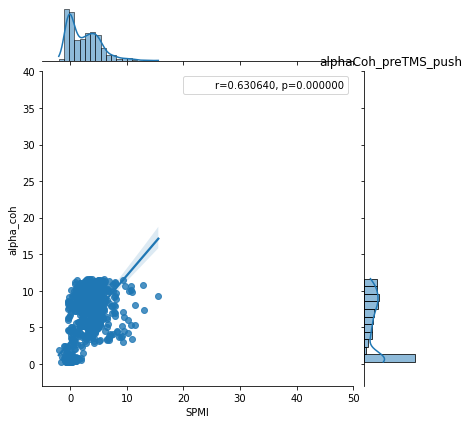

<Figure size 432x288 with 0 Axes>

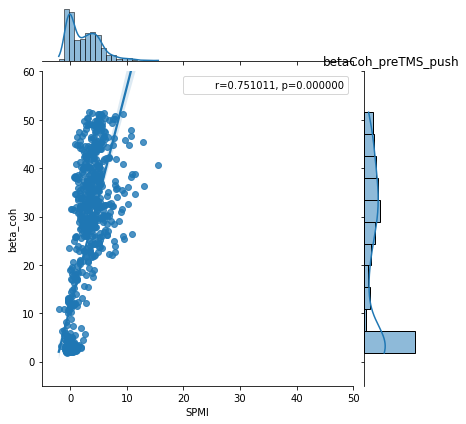

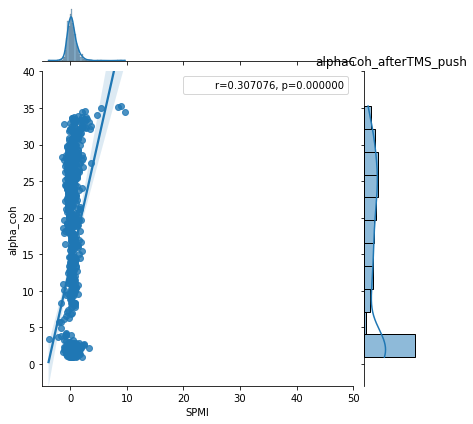

<Figure size 432x288 with 0 Axes>

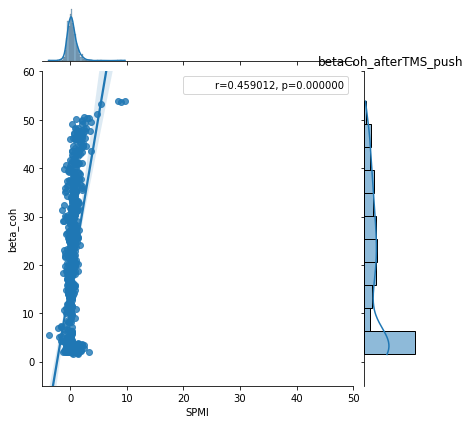

In [19]:
########## Import ##############
import os,numpy as np, pandas as pd, mne, warnings
import scipy.stats as stats
from warnings import filterwarnings
filterwarnings ('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
################################

################## Dataset Loading ##################
#data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subj_idx = '29'
contraction_type = 'iVC'
data_dir = r'E:\masterSJTU\MultiEEGEMG_stroke'
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]
# data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir

list_epochs_push_be4TMS = []
for session_idx in ['01','02','03']:
    epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_push_epo.fif')
    list_epochs_push_be4TMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
epochs_push_be4TMS = mne.concatenate_epochs(list_epochs_push_be4TMS)
#####################################################################
con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)

chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                      'Fz','Cz','Pz','Oz',
                       'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T7c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                      'FDS','FCU','FCR','ECU','ECRL','BBS','TBL','LD']

chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                              'Fz','Cz','Pz','Oz',
                   'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                              'Fz','Cz','Pz','Oz',
                   'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                             'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
alpha_coh = np.zeros([40,40])
for freq in freqs:
    if (freq>=8.0) & (freq<=12.0):
        alpha_coh+=con[:,:,np.where(freqs==freq)[0][0]]
alpha_coh+=np.transpose(alpha_coh)
beta_coh = np.zeros([40,40])
for freq in freqs:
    if (freq>=12) & (freq<=30.0):
        beta_coh+=con[:,:,np.where(freqs==freq)[0][0]]
beta_coh+=np.transpose(beta_coh)
alpha_coh_remapped = {}
beta_coh_remapped = {}
for ch1_idx in range(epochs_push_be4TMS.get_data().shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,epochs_push_be4TMS.get_data().shape[1]):
#         print('SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx])
        if affected_h == 'l':
            ch2_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_lParetic[ch2_idx])
            ch1_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_lParetic[ch1_idx])
        elif affected_h == 'r':
            ch2_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_rParetic[ch2_idx])
            ch1_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_rParetic[ch1_idx])
#             print(epochs_push_be4TMS.info['ch_names'][ch1_idx_preImage])
        alpha_coh_remapped['SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx]] =alpha_coh[ch1_idx_preImage,ch2_idx_preImage]
        beta_coh_remapped['SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx]] =beta_coh[ch1_idx_preImage,ch2_idx_preImage]
        
df_SPMI = df.loc[(df['contraction_group'] == 'push')&(df['subj_id']==subj_idx)]
names= alpha_coh_remapped.keys()
SPMI = []
alpha_coh_array = []
beta_coh_array=[]
for name in names:
    SPMI.append(df_SPMI[name].values[0])
    alpha_coh_array.append(alpha_coh_remapped[name])
    beta_coh_array.append(beta_coh_remapped[name])

df2scatter = pd.DataFrame(data={'name':names,'SPMI':SPMI,'alpha_coh':alpha_coh_array,'beta_coh':beta_coh_array})
import seaborn as sns
ax=sns.jointplot(x='SPMI',y='alpha_coh',data=df2scatter,kind='reg',ylim=(-3,40),xlim=(-5,50))
r, p = stats.pearsonr(df2scatter['SPMI'],df2scatter['alpha_coh'])
phantom, = ax.ax_joint.plot([], [], linestyle="", alpha=0)
ax.ax_joint.legend([phantom],['r={:3f}, p={:3f}'.format(r,p)])
plt.title('alphaCoh_preTMS_push')
ax.savefig(os.path.join(iVC_results_dir+'subj'+subj_idx+'_SPMI_alphaCoh_preTMS_push.eps'))
import matplotlib.pyplot as plt
plt.figure()
ax=sns.jointplot(x='SPMI',y='beta_coh',data=df2scatter,kind='reg',ylim=(-5,60),xlim=(-5,50))
r, p = stats.pearsonr(df2scatter['SPMI'],df2scatter['beta_coh'])
phantom, = ax.ax_joint.plot([], [], linestyle="", alpha=0)
ax.ax_joint.legend([phantom],['r={:3f}, p={:3f}'.format(r,p)])
plt.title('betaCoh_preTMS_push')
ax.savefig(os.path.join(iVC_results_dir+'subj'+subj_idx+'_SPMI_betaCoh_preTMS_push.eps'))

list_epochs_push_afterTMS = []
for session_idx in ['04','05','06']:
    epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                      'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_push_epo.fif')
    list_epochs_push_afterTMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
epochs_push_afterTMS = mne.concatenate_epochs(list_epochs_push_afterTMS)
#####################################################################
con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_afterTMS,fmin=1, fmax=40)

for freq in freqs:
    if (freq>=8.0) & (freq<=12.0):
        alpha_coh+=con[:,:,np.where(freqs==freq)[0][0]]
alpha_coh+=np.transpose(alpha_coh)
beta_coh = np.zeros([40,40])
for freq in freqs:
    if (freq>=12) & (freq<=30.0):
        beta_coh+=con[:,:,np.where(freqs==freq)[0][0]]
beta_coh+=np.transpose(beta_coh)
alpha_coh_remapped = {}
beta_coh_remapped = {}
for ch1_idx in range(epochs_push_afterTMS.get_data().shape[1]):
    for ch2_idx in np.arange(ch1_idx+1,epochs_push_be4TMS.get_data().shape[1]):
#         print('SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx])
        if affected_h == 'l':
            ch2_idx_preImage = epochs_push_afterTMS.info['ch_names'].index(chs_list_preImage_lParetic[ch2_idx])
            ch1_idx_preImage = epochs_push_afterTMS.info['ch_names'].index(chs_list_preImage_lParetic[ch1_idx])
        elif affected_h == 'r':
            ch2_idx_preImage = epochs_push_afterTMS.info['ch_names'].index(chs_list_preImage_rParetic[ch2_idx])
            ch1_idx_preImage = epochs_push_afterTMS.info['ch_names'].index(chs_list_preImage_rParetic[ch1_idx])
#             print(epochs_push_be4TMS.info['ch_names'][ch1_idx_preImage])
        alpha_coh_remapped['SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx]] =alpha_coh[ch1_idx_preImage,ch2_idx_preImage]
        beta_coh_remapped['SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx]] =beta_coh[ch1_idx_preImage,ch2_idx_preImage]

df_fName = os.path.join(iVC_results_dir,'patients_TMS_df.csv')
df_SPMI = pd.read_csv(df_fName,index_col=[0])
df_SPMI_push_afterTMS = df_SPMI.loc[(df_SPMI['contraction_group'] == 'push')&(df_SPMI['subj_id']==int(subj_idx))&(df_SPMI['session_group']=='afterTMS')]
names= alpha_coh_remapped.keys()
SPMI = []
alpha_coh_array = []
beta_coh_array=[]
for name in names:
    SPMI.append(df_SPMI_push_afterTMS[name].values[0])
    alpha_coh_array.append(alpha_coh_remapped[name])
    beta_coh_array.append(beta_coh_remapped[name])

df2scatter = pd.DataFrame(data={'name':names,'SPMI':SPMI,'alpha_coh':alpha_coh_array,'beta_coh':beta_coh_array})
import seaborn as sns
ax=sns.jointplot(x='SPMI',y='alpha_coh',data=df2scatter,kind='reg',ylim=(-3,40),xlim=(-5,50))
r, p = stats.pearsonr(df2scatter['SPMI'],df2scatter['alpha_coh'])
phantom, = ax.ax_joint.plot([], [], linestyle="", alpha=0)
ax.ax_joint.legend([phantom],['r={:3f}, p={:3f}'.format(r,p)])
plt.title('alphaCoh_afterTMS_push')
ax.savefig(os.path.join(iVC_results_dir+'subj'+subj_idx+'_SPMI_alphaCoh_afterTMS_push.eps'))
import matplotlib.pyplot as plt
plt.figure()
ax=sns.jointplot(x='SPMI',y='beta_coh',data=df2scatter,kind='reg',ylim=(-5,60),xlim=(-5,50))
r, p = stats.pearsonr(df2scatter['SPMI'],df2scatter['beta_coh'])
phantom, = ax.ax_joint.plot([], [], linestyle="", alpha=0)
ax.ax_joint.legend([phantom],['r={:3f}, p={:3f}'.format(r,p)])
plt.title('betaCoh_afterTMS_push')
ax.savefig(os.path.join(iVC_results_dir+'subj'+subj_idx+'_SPMI_betaCoh_afterTMS_push.eps'))


## Section2: scatter poot (SPMI vs tradictional coherence) for all patients

Reading E:\masterSJTU\MultiEEGEMG_stroke\subj3\epochs_hybrid\subj3_iVC_s01_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
14 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj3\epochs_hybrid\subj3_iVC_s02_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction applied
0 projection items activated
Reading E:\masterSJTU\MultiEEGEMG_stroke\subj3\epochs_hybrid\subj3_iVC_s03_hybrid_push_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    3000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
13 matching events found
No baseline correction ap

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
   

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
  

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
  

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    computing connectivity for epoch 31
    computing connectivity for epoch 32
  

<ipython-input-8-1f7dbe50aaf0>:30: RuntimeWarning: fmin=1.000 Hz corresponds to 3.002 < 5 cycles based on the epoch length 3.002 sec, need at least 5.000 sec epochs or fmin=1.666. Spectrum estimate will be unreliable.
  con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)


    computing connectivity for epoch 6
    computing connectivity for epoch 7
    computing connectivity for epoch 8
    computing connectivity for epoch 9
    computing connectivity for epoch 10
    computing connectivity for epoch 11
    computing connectivity for epoch 12
    computing connectivity for epoch 13
    computing connectivity for epoch 14
    computing connectivity for epoch 15
    computing connectivity for epoch 16
    computing connectivity for epoch 17
    computing connectivity for epoch 18
    computing connectivity for epoch 19
    computing connectivity for epoch 20
    computing connectivity for epoch 21
    computing connectivity for epoch 22
    computing connectivity for epoch 23
    computing connectivity for epoch 24
    computing connectivity for epoch 25
    computing connectivity for epoch 26
    computing connectivity for epoch 27
    computing connectivity for epoch 28
    computing connectivity for epoch 29
    computing connectivity for epoch 30
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

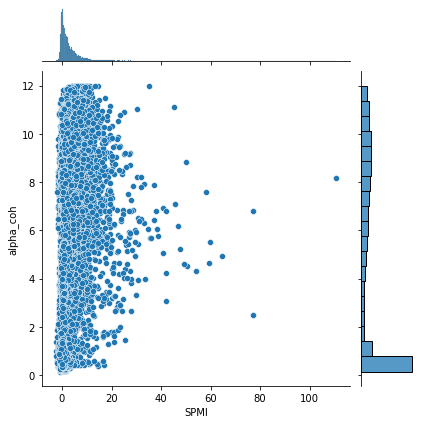

<Figure size 432x288 with 0 Axes>

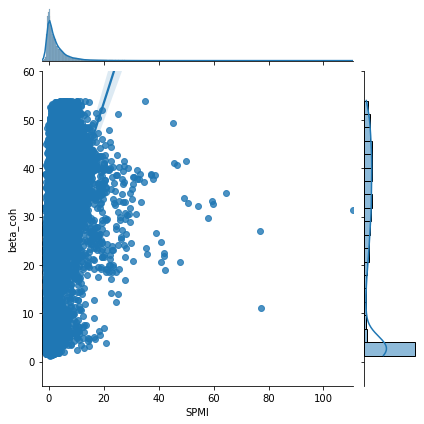

In [8]:
########## Import ##############
import os,numpy as np, pandas as pd, mne, warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings("ignore", category=DeprecationWarning)
################################

################## Dataset Loading ##################
patient_subjs = ['3','6','8','11','31','33','40','22','23','26','28','29', '38','41','37','36','12','16','44','45','50']
df2scatter = None
for patient_subj in patient_subjs:
    subj = 'subj'+patient_subj
    subj_idx = patient_subj
    contraction_type = 'iVC'
    data_dir = r'E:\masterSJTU\MultiEEGEMG_stroke'
    epochs_hybrid_dir = os.path.join(data_dir,subj,'epochs_hybrid')
    subjInfo_fName = os.path.join(data_dir,'subj_info.txt')
    subjInfo = pd.read_csv(subjInfo_fName, skiprows=0,
                           sep = ',',engine = 'python')
    affected_h = subjInfo[subjInfo['subj_idx']==int(subj_idx)]['affected_h'].values[0]
    # data_dir = 'E:/important file/Projects/CM-graph/sample_data' #PC dir

    list_epochs_push_be4TMS = []
    for session_idx in ['01','02','03']:
        epochs_hybrid_fName = os.path.join(epochs_hybrid_dir,
                                          'subj'+subj_idx+'_'+contraction_type+'_s'+session_idx+'_hybrid_push_epo.fif')
        list_epochs_push_be4TMS.append(mne.read_epochs(epochs_hybrid_fName,preload=True))
    epochs_push_be4TMS = mne.concatenate_epochs(list_epochs_push_be4TMS)
    #####################################################################
    con,freqs,times,_,_ = mne.connectivity.spectral_connectivity(epochs_push_be4TMS,fmin=1, fmax=40)

    chs_list_image = ['Fp1i','AF3i','F3i','F7i','FC1i','FC5i','C3i','T7i','CP1i','CP5i','P3i','P7i','PO3i','O1i',
                          'Fz','Cz','Pz','Oz',
                           'Fp1c','AF3c','F3c','F7c','FC1c','FC5c','C3c','T7c','CP1c','CP5c','P3c','P7c','PO3c','O1c',
                          'FDS','FCU','FCR','ECU','ECRL','BBS','TBL','LD']

    chs_list_preImage_lParetic = ['Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                  'Fz','Cz','Pz','Oz',
                       'Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']

    chs_list_preImage_rParetic = ['Fp2','AF4','F4','F8','FC2','FC6','C4','T8','CP2','CP6','P4','P8','PO4','O2',
                                  'Fz','Cz','Pz','Oz',
                       'Fp1','AF3','F3','F7','FC1','FC5','C3','T7','CP1','CP5','P3','P7','PO3','O1',
                                 'emg1','emg2','emg3','emg4','emg5','emg6','emg7','emg8']
    alpha_coh = np.zeros([40,40])
    for freq in freqs:
        if (freq>=8.0) & (freq<=12.0):
            alpha_coh+=con[:,:,np.where(freqs==freq)[0][0]]
    alpha_coh+=np.transpose(alpha_coh)
    beta_coh = np.zeros([40,40])
    for freq in freqs:
        if (freq>=12) & (freq<=30.0):
            beta_coh+=con[:,:,np.where(freqs==freq)[0][0]]
    beta_coh+=np.transpose(beta_coh)
    alpha_coh_remapped = {}
    beta_coh_remapped = {}
    for ch1_idx in range(epochs_push_be4TMS.get_data().shape[1]):
        for ch2_idx in np.arange(ch1_idx+1,epochs_push_be4TMS.get_data().shape[1]):
    #         print('SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx])
            if affected_h == 'l':
                ch2_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_lParetic[ch2_idx])
                ch1_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_lParetic[ch1_idx])
            elif affected_h == 'r':
                ch2_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_rParetic[ch2_idx])
                ch1_idx_preImage = epochs_push_be4TMS.info['ch_names'].index(chs_list_preImage_rParetic[ch1_idx])
    #             print(epochs_push_be4TMS.info['ch_names'][ch1_idx_preImage])
            alpha_coh_remapped['SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx]] =alpha_coh[ch1_idx_preImage,ch2_idx_preImage]
            beta_coh_remapped['SPMI_'+chs_list_image[ch1_idx]+'_'+chs_list_image[ch2_idx]] =beta_coh[ch1_idx_preImage,ch2_idx_preImage]

    df_SPMI = df.loc[(df['contraction_group'] == 'push')&(df['subj_id']==subj_idx)]
    names= alpha_coh_remapped.keys()
    SPMI = []
    alpha_coh_array = []
    beta_coh_array=[]
    for name in names:
        SPMI.append(df_SPMI[name].values[0])
        alpha_coh_array.append(alpha_coh_remapped[name])
        beta_coh_array.append(beta_coh_remapped[name])
    if df2scatter is None:
        df2scatter = pd.DataFrame(data={'name':names,'SPMI':SPMI,'alpha_coh':alpha_coh_array,'beta_coh':beta_coh_array})
    else:
        df2scatter = pd.concat([df2scatter,pd.DataFrame(data={'name':names,'SPMI':SPMI,'alpha_coh':alpha_coh_array,'beta_coh':beta_coh_array})])

ax=sns.jointplot(x='SPMI',y='alpha_coh',data=df2scatter)
ax.savefig(os.path.join(iVC_results_dir+'patient_SPMI_betaCoh_be4TMS_push.eps'))
plt.figure()
ax=sns.jointplot(x='SPMI',y='beta_coh',data=df2scatter,kind='reg',ylim=(-5,60))
ax.savefig(os.path.join(iVC_results_dir+'.patient_SPMI_betaCoh_be4TMS_push.eps'))

## Section3: mean of zth SPMI

In [12]:
mean_zth_SPMIs = []
for subj in healthy_subjs:
    for contraction_group in ['push','pull']:
        temp_dir = os.path.join(data_dir,'subj'+subj,'temp')
        SPMI_withoutD_zth_fName = os.path.join(temp_dir,contraction_type+'_zth_SPMI_'+contraction_group+'_be4TMS')
        SPMI_withoutD_zth = np.load(SPMI_withoutD_zth_fName+'.npy')
        mean_zth_SPMIs.append(SPMI_withoutD_zth.mean())
for subj in patient_subjs:
    for contraction_group in ['push','pull']:
        temp_dir = os.path.join(data_dir,'subj'+subj,'temp')
        SPMI_withoutD_zth_fName = os.path.join(temp_dir,contraction_type+'_zth_SPMI_'+contraction_group+'_be4TMS')
        SPMI_withoutD_zth = np.load(SPMI_withoutD_zth_fName+'.npy')
        mean_zth_SPMIs.append(SPMI_withoutD_zth.mean())
        SPMI_withoutD_zth_fName = os.path.join(temp_dir,contraction_type+'_zth_SPMI_'+contraction_group+'_afterTMS')
        SPMI_withoutD_zth = np.load(SPMI_withoutD_zth_fName+'.npy')
        mean_zth_SPMIs.append(SPMI_withoutD_zth.mean())
print(np.mean(mean_zth_SPMIs))
print(np.std(mean_zth_SPMIs))

1.3348298943739396
1.1796227136968191
